# Business objective

This app predicts if an applicant will be approved for a credit card or not. Each time there is a hard enquiry your credit score is affected negatively. This app predict the probability of being approved without affecting your credit score. This app can be used by applicant who wants to find out if they will be approved for a credit card without affecting their credit score.

In [124]:
pip install --upgrade pandas


In [125]:
!pip install pandas-profiling

In [126]:
from pandas.errors import SettingWithCopyWarning


In [127]:
pip install pandas-profiling

In [128]:
!pip install scikit-plot

# 0. import the necessary packages

In [6]:
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from pathlib import Path
from scipy.stats import probplot, chi2_contingency, chi2
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, cross_val_predict
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibratedClassifierCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OrdinalEncoder
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, roc_curve, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.inspection import permutation_importance
import scikitplot as skplt
from yellowbrick.model_selection import FeatureImportances
import scipy.stats as stats
import joblib
import os
%matplotlib inline

In [7]:
!pip install scikit-plot


# 1. Get the data

## 1.1 import csv file

In [8]:
cc_data_full_data = pd.read_csv('/content/application_record.csv')
credit_status = pd.read_csv('/content/credit_record.csv')

## 1.2 creating the target variable

In [9]:
begin_month=pd.DataFrame(credit_status.groupby(['ID'])['MONTHS_BALANCE'].agg(min))
begin_month=begin_month.rename(columns={'MONTHS_BALANCE':'Account age'})
cc_data_full_data=pd.merge(cc_data_full_data,begin_month,how='left',on='ID')
credit_status['dep_value'] = None
credit_status['dep_value'][credit_status['STATUS'] =='2']='Yes'
credit_status['dep_value'][credit_status['STATUS'] =='3']='Yes'
credit_status['dep_value'][credit_status['STATUS'] =='4']='Yes'
credit_status['dep_value'][credit_status['STATUS'] =='5']='Yes'
cpunt=credit_status.groupby('ID').count()
cpunt['dep_value'][cpunt['dep_value'] > 0]='Yes'
cpunt['dep_value'][cpunt['dep_value'] == 0]='No'
cpunt = cpunt[['dep_value']]
cc_data_full_data = pd.merge(cc_data_full_data,cpunt,how='inner',on='ID')
cc_data_full_data['Is high risk']=cc_data_full_data['dep_value']
cc_data_full_data.loc[cc_data_full_data['Is high risk']=='Yes','Is high risk']=1
cc_data_full_data.loc[cc_data_full_data['Is high risk']=='No','Is high risk']=0
cc_data_full_data.drop('dep_value',axis=1,inplace=True)
pd.options.mode.chained_assignment = None # hide warning SettingWithCopyWarning

<ipython-input-9-00652fac5015>:1: FutureWarning: The provided callable <built-in function min> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  begin_month=pd.DataFrame(credit_status.groupby(['ID'])['MONTHS_BALANCE'].agg(min))
<ipython-input-9-00652fac5015>:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and 

## 1.3 Rename features

In [10]:
# rename the features to a more readable feature names
cc_data_full_data = cc_data_full_data.rename(columns={
    'CODE_GENDER':'Gender',
    'FLAG_OWN_CAR':'Has a car',
    'FLAG_OWN_REALTY':'Has a property',
    'CNT_CHILDREN':'Children count',
    'AMT_INCOME_TOTAL':'Income',
    'NAME_INCOME_TYPE':'Employment status',
    'NAME_EDUCATION_TYPE':'Education level',
    'NAME_FAMILY_STATUS':'Marital status',
    'NAME_HOUSING_TYPE':'Dwelling',
    'DAYS_BIRTH':'Age',
    'DAYS_EMPLOYED': 'Employment length',
    'FLAG_MOBIL': 'Has a mobile phone',
    'FLAG_WORK_PHONE': 'Has a work phone',
    'FLAG_PHONE': 'Has a phone',
    'FLAG_EMAIL': 'Has an email',
    'OCCUPATION_TYPE': 'Job title',
    'CNT_FAM_MEMBERS': 'Family member count',
    'Account age': 'Account age'
    })

## 1.4 Split the data into training and test sets, creating a copy of the datasets

In [11]:
# split the data into train and test
def data_split(df, test_size):
    train_df, test_df = train_test_split(df, test_size=test_size, random_state=42)
    return train_df.reset_index(drop=True), test_df.reset_index(drop=True)

In [12]:
cc_train_original, cc_test_original = data_split(cc_data_full_data, 0.2)

In [13]:
cc_train_original.shape

(18708, 20)

In [14]:
cc_test_original.shape

(4678, 20)

In [15]:
cc_train_original.to_csv('/content/train_data.csv',index=False)

In [16]:
cc_test_original.to_csv('/content/test_data.csv',index=False)

In [17]:
# creating a copy of the dataset so that the original stays untouched
cc_train_copy = cc_train_original.copy()
cc_test_copy = cc_test_original.copy()

# 2. Explore the Data

## 2.0 Pandas Profiling

> Indented block

> Indented block





In [18]:
!pip install --upgrade pydantic


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 394.8/394.8 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 18.0 MB/s eta 0:00:00
  Attempting uninstall: pydantic-core
    Found existing installation: pydantic_core 2.16.1
    Uninstalling pydantic_core-2.16.1:
      Successfully uninstalled pydantic_core-2.16.1
  Attempting uninstall: pydantic
    Found existing installation: pydantic 2.6.0
    Uninstalling pydantic-2.6.0:
      Successfully uninstalled pydantic-2.6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
llmx 0.0.15a0 requires cohere, which is not installed.
llmx 0.0.15a0 requires openai, which is n

In [19]:
from ydata_profiling import ProfileReport

profile_report = ProfileReport(cc_train_copy, explorative=True, dark_mode=True)
profile_report_file_path = Path('/content/credit_pred_profile.html')
profile_report.to_file(output_file=profile_report_file_path)


/usr/local/lib/python3.10/dist-packages/ydata_profiling/profile_report.py:354: UserWarning: Try running command: 'pip install --upgrade Pillow' to avoid ValueError
  warnings.warn(


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/ydata_profiling/model/pandas/summary_pandas.py:39: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  series = series.fillna(np.nan)
/usr/local/lib/python3.10/dist-packages/ydata_profiling/model/correlations.py:66: UserWarning: There was an attempt to calculate the auto correlation, but this failed.
To hide this warning, disable the calculation
(using `df.profile_report(correlations={"auto": {"calculate": False}})`
If this is problematic for your use case, please report this as an issue:
https://github.com/ydataai/ydata-profiling/issues
(include the error message: 'could not convert string to float: 'House / apartment'')
  warnings.warn(


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [20]:
profile_report = ProfileReport(cc_train_copy, explorative=True, dark_mode=True)
profile_report_file_path = Path('/content/credit_pred_profile.html')

# checking if the pandas profile report file exists in the current directory
try:
    profile_report_file_path.resolve(strict=True)
except FileNotFoundError:
    profile_report.to_file("/content/credit_pred_profile.html")

## 2.1 Quick glance at the data

In [21]:
cc_data_full_data.head()

ID Gender Has a car Has a property  Children count    Income  \
0  5008804      M         Y              Y               0  427500.0   
1  5008805      M         Y              Y               0  427500.0   
2  5008806      M         Y              Y               0  112500.0   
3  5008808      F         N              Y               0  270000.0   
4  5008809      F         N              Y               0  270000.0   

      Employment status                Education level        Marital status  \
0               Working               Higher education        Civil marriage   
1               Working               Higher education        Civil marriage   
2               Working  Secondary / secondary special               Married   
3  Commercial associate  Secondary / secondary special  Single / not married   
4  Commercial associate  Secondary / secondary special  Single / not married   

            Dwelling    Age  Employment length  Has a mobile phone  \
0   Rented apartment -12005            -4542.0                 1.0   
1   Rented apartment -12005            -4542.0                 1.0   
2  House / apartment -21474            -1134.0                 1.0   
3  House / apartment -19110            -3051.0                 1.0   
4  House / apartment -19110            -3051.0                 1.0   

   Has a work phone  Has a phone  Has an email       Job title  \
0               1.0          0.0           0.0             NaN   
1               1.0          0.0           0.0             NaN   
2               0.0          0.0           0.0  Security staff   
3               0.0          1.0           1.0     Sales staff   
4               0.0          1.0           1.0     Sales staff   

   Family member count  Account age Is high risk  
0                  2.0        -15.0            0  
1                  2.0        -14.0            0  
2                  2.0        -29.0            0  
3                  1.0         -4.0            0  
4                  1.0        -26.0            0

In [22]:
cc_data_full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23386 entries, 0 to 23385
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   23386 non-null  int64  
 1   Gender               23386 non-null  object 
 2   Has a car            23386 non-null  object 
 3   Has a property       23386 non-null  object 
 4   Children count       23386 non-null  int64  
 5   Income               23386 non-null  float64
 6   Employment status    23386 non-null  object 
 7   Education level      23386 non-null  object 
 8   Marital status       23386 non-null  object 
 9   Dwelling             23386 non-null  object 
 10  Age                  23386 non-null  int64  
 11  Employment length    23386 non-null  float64
 12  Has a mobile phone   23386 non-null  float64
 13  Has a work phone     23386 non-null  float64
 14  Has a phone          23386 non-null  float64
 15  Has an email         23386 non-null 

In [23]:
cc_data_full_data.describe()

ID  Children count        Income           Age  \
count  2.338600e+04    23386.000000  2.338600e+04  23386.000000   
mean   5.052447e+06        0.407038  1.876280e+05 -16188.418584   
std    2.616243e+04        0.718443  1.000682e+05   4221.676918   
min    5.008804e+06        0.000000  3.015000e+04 -25140.000000   
25%    5.028790e+06        0.000000  1.215000e+05 -19780.000000   
50%    5.051170e+06        0.000000  1.575000e+05 -15812.000000   
75%    5.068872e+06        1.000000  2.250000e+05 -12674.000000   
max    5.096541e+06       14.000000  1.350000e+06  -7489.000000   

       Employment length  Has a mobile phone  Has a work phone   Has a phone  \
count       23386.000000             23386.0      23386.000000  23386.000000   
mean        62745.274480                 1.0          0.202771      0.290174   
std        140729.536168                 0.0          0.402072      0.453852   
min        -15227.000000                 1.0          0.000000      0.000000   
25%         -3174.000000                 1.0          0.000000      0.000000   
50%         -1539.000000                 1.0          0.000000      0.000000   
75%          -398.000000                 1.0          0.000000      1.000000   
max        365243.000000                 1.0          1.000000      1.000000   

       Has an email  Family member count   Account age  
count  23386.000000         23386.000000  23386.000000  
mean       0.099504             2.166082    -26.129522  
std        0.299344             0.894593     16.545688  
min        0.000000             1.000000    -60.000000  
25%        0.000000             2.000000    -39.000000  
50%        0.000000             2.000000    -24.000000  
75%        0.000000             3.000000    -12.000000  
max        1.000000            15.000000      0.000000

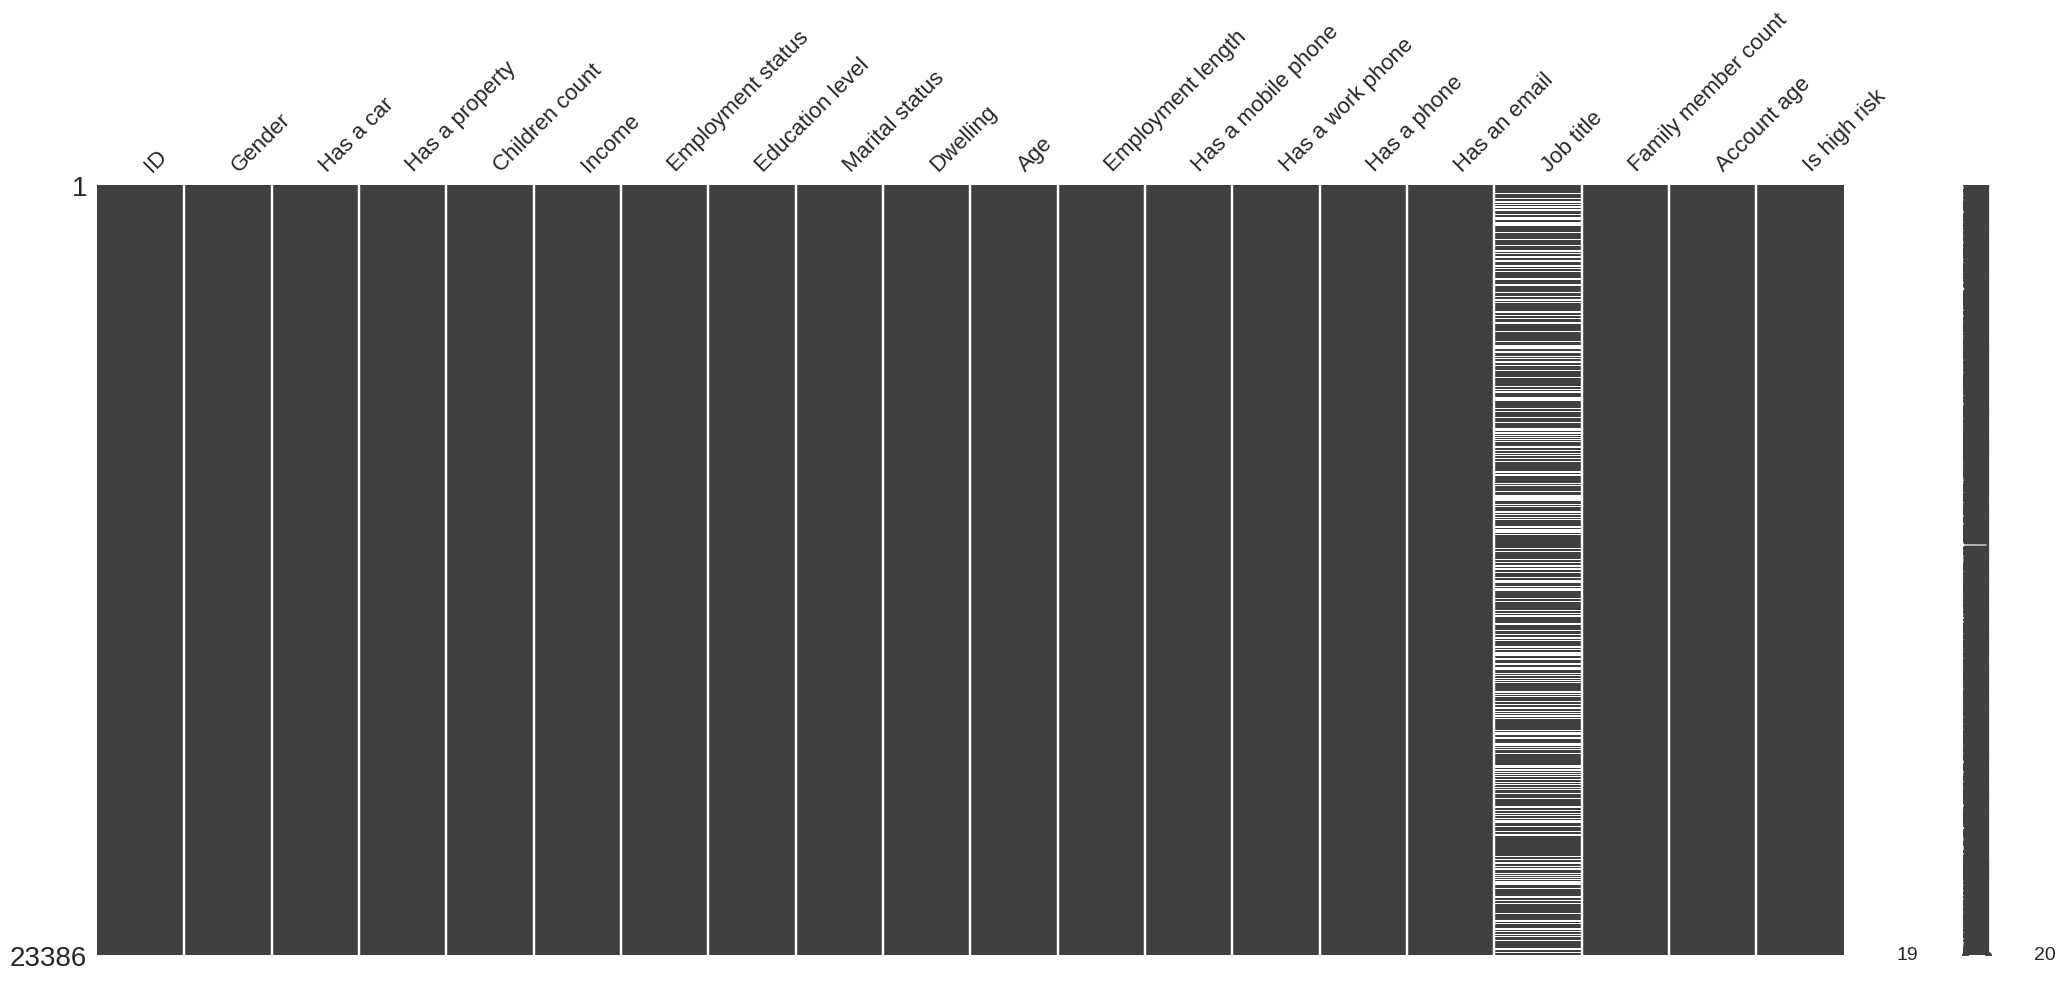

In [24]:
msno.matrix(cc_data_full_data)
plt.show()

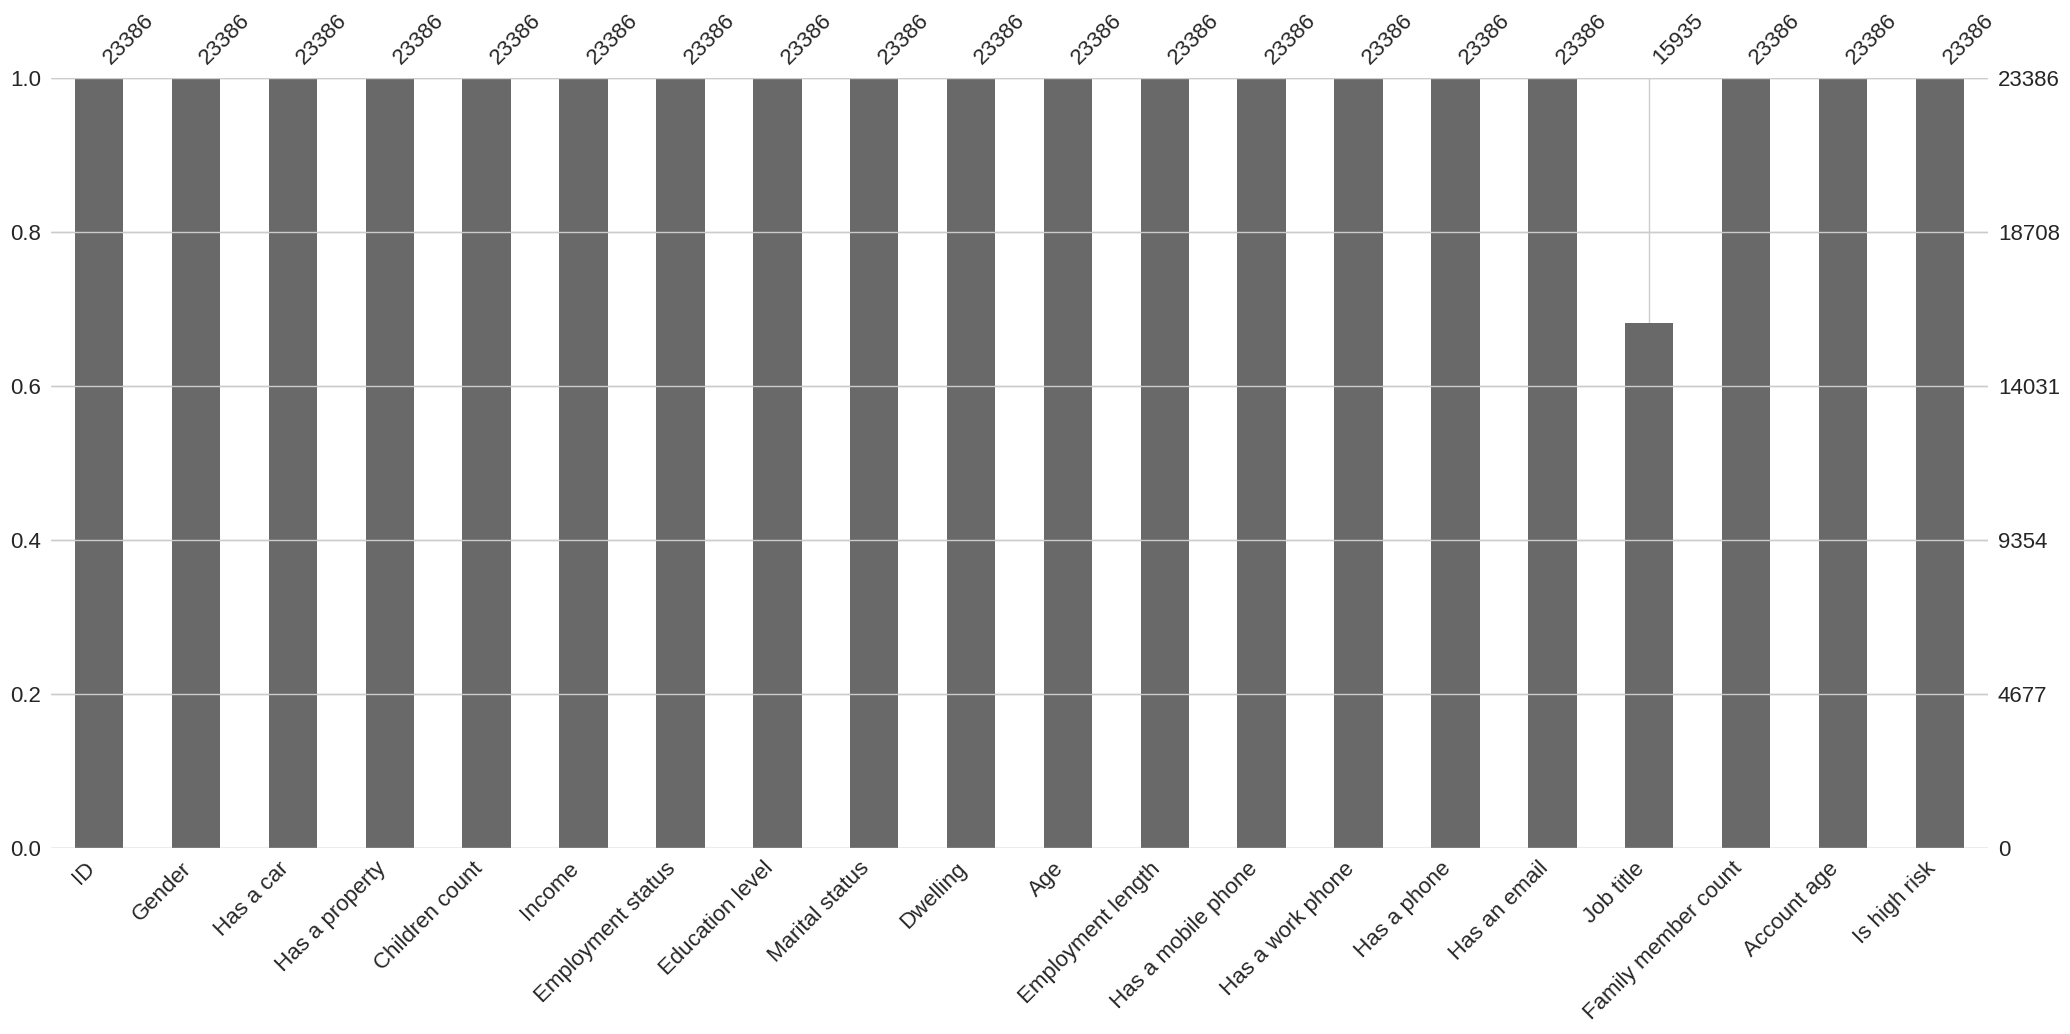

In [25]:
msno.bar(cc_data_full_data)
plt.show()

## 2.2 Functions used to explore each feature

In [26]:
#Function that will return the value count and frequency of each observation within a feature
def value_cnt_norm_cal(df,feature):
    ftr_value_cnt = df[feature].value_counts()
    ftr_value_cnt_norm = df[feature].value_counts(normalize=True) * 100
    ftr_value_cnt_concat = pd.concat([ftr_value_cnt, ftr_value_cnt_norm], axis=1)
    ftr_value_cnt_concat.columns = ['Count', 'Frequency (%)']
    return ftr_value_cnt_concat

In [27]:
# function to create display general information about the feature
def gen_info_feat(df,feature):
    match feature:
        case 'Age':
            # change the feature to be express in positive numbers days
            print('Description:\n{}'.format((np.abs(df[feature])/365.25).describe()))
            print('*'*50)
            print('Object type:{}'.format(df[feature].dtype))
        case 'Employment length':
            # select only the rows where the rows are negative to ignore whose who have retired or unemployed
            employment_len_no_ret = cc_train_copy['Employment length'][cc_train_copy['Employment length'] < 0]
            employment_len_no_ret_yrs = np.abs(employment_len_no_ret)/365.25
            print('Description:\n{}'.format((employment_len_no_ret_yrs).describe()))
            print('*'*50)
            print('Object type:{}'.format(employment_len_no_ret.dtype))
        case 'Account age':
            # change the account age to a positive number of months
            print('Description:\n{}'.format((np.abs(df[feature])).describe()))
            print('*'*50)
            print('Object type:{}'.format(df[feature].dtype))
        case _:
            print('Description:\n{}'.format(df[feature].describe()))
            print('*'*50)
            print('Object type:\n{}'.format(df[feature].dtype))
            print('*'*50)
            value_cnt = value_cnt_norm_cal(df,feature)
            print('Value count:\n{}'.format(value_cnt))


In [28]:
# function to create a pie chart plot
def create_pie_plot(df,feature):
    match feature:
        case 'Dwelling' | 'Education level':
            ratio_size = value_cnt_norm_cal(df, feature)
            ratio_size_len = len(ratio_size.index)
            ratio_list = []
            for i in range(ratio_size_len):
                ratio_list.append(ratio_size.iloc[i]['Frequency (%)'])
            fig, ax = plt.subplots(figsize=(8,8))
            # %1.2f%% display decimals in the pie chart with 2 decimal places
            plt.pie(ratio_list, startangle=90, wedgeprops={'edgecolor' :'black'})
            plt.title('Pie chart of {}'.format(feature))
            plt.legend(loc='best',labels=ratio_size.index)
            plt.axis('equal')
            return plt.show()
        case _:
            ratio_size = value_cnt_norm_cal(df, feature)
            ratio_size_len = len(ratio_size.index)
            ratio_list = []
            for i in range(ratio_size_len):
                ratio_list.append(ratio_size.iloc[i]['Frequency (%)'])
            fig, ax = plt.subplots(figsize=(8,8))
            # %1.2f%% display decimals in the pie chart with 2 decimal places
            plt.pie(ratio_list, labels=ratio_size.index, autopct='%1.2f%%', startangle=90, wedgeprops={'edgecolor' :'black'})
            plt.title('Pie chart of {}'.format(feature))
            plt.legend(loc='best')
            plt.axis('equal')
            return plt.show()

In [29]:
# function to create a bar chart plot
def create_bar_plot(df,feature):
    match feature:
        case 'Marital status' | 'Dwelling' | 'Job title' | 'Employment status' | 'Education level':
            fig, ax = plt.subplots(figsize=(6,10))
            sns.barplot(x=value_cnt_norm_cal(df,feature).index,y=value_cnt_norm_cal(df,feature).values[:,0])
            ax.set_xticklabels(labels=value_cnt_norm_cal(df,feature).index,rotation=45,ha='right')
            plt.xlabel('{}'.format(feature))
            plt.ylabel('Count')
            plt.title('{} count'.format(feature))
            return plt.show()
        case _:
            fig, ax = plt.subplots(figsize=(6,10))
            sns.barplot(x=value_cnt_norm_cal(df,feature).index,y=value_cnt_norm_cal(df,feature).values[:,0])
            plt.xlabel('{}'.format(feature))
            plt.ylabel('Count')
            plt.title('{} count'.format(feature))
            return plt.show()

In [30]:
# function to create a box plot
def create_box_plot(df,feature):
    match feature:
        case 'Age':
            fig, ax = plt.subplots(figsize=(2,8))
            # change the feature to be express in positive numbers days
            sns.boxplot(y=np.abs(df[feature])/365.25)
            plt.title('{} distribution(Boxplot)'.format(feature))
            return plt.show()
        case 'Children count':
            fig, ax = plt.subplots(figsize=(2,8))
            sns.boxplot(y=df[feature])
            plt.title('{} distribution(Boxplot)'.format(feature))
            plt.yticks(np.arange(0,df[feature].max(),1))
            return plt.show()
        case 'Employment length':
            fig, ax = plt.subplots(figsize=(2,8))
            employment_len_no_ret = cc_train_copy['Employment length'][cc_train_copy['Employment length'] < 0]
            # employement length in days is a negative number so we need to change it to positive and change it to days
            employment_len_no_ret_yrs = np.abs(employment_len_no_ret)/365.25
            sns.boxplot(y=employment_len_no_ret_yrs)
            plt.title('{} distribution(Boxplot)'.format(feature))
            plt.yticks(np.arange(0,employment_len_no_ret_yrs.max(),2))
            return plt.show()
        case 'Income':
            fig, ax = plt.subplots(figsize=(2,8))
            sns.boxplot(y=df[feature])
            plt.title('{} distribution(Boxplot)'.format(feature))
            # suppress scientific notation
            ax.get_yaxis().set_major_formatter(
                matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
            return plt.show()
        case 'Account age':
            fig, ax = plt.subplots(figsize=(2,8))
            sns.boxplot(y=np.abs(df[feature]))
            plt.title('{} distribution(Boxplot)'.format(feature))
            return plt.show()
        case _:
            fig, ax = plt.subplots(figsize=(2,8))
            sns.boxplot(y=df[feature])
            plt.title('{} distribution(Boxplot)'.format(feature))
            return plt.show()

In [31]:
# function to create a histogram plot
def create_hist_plot(df,feature, the_bins=50):
    match feature:
        case 'Age':
            fig, ax = plt.subplots(figsize=(18,10))
            # change the feature to be express in positive numbers days
            sns.histplot(np.abs(df[feature])/365.25,bins=the_bins,kde=True)
            plt.title('{} distribution'.format(feature))
            return plt.show()
        case 'Income':
            fig, ax = plt.subplots(figsize=(18,10))
            sns.histplot(df[feature],bins=the_bins,kde=True)
            # suppress scientific notation
            ax.get_xaxis().set_major_formatter(
                matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
            plt.title('{} distribution'.format(feature))
            return plt.show()
        case 'Employment length':
            employment_len_no_ret = cc_train_copy['Employment length'][cc_train_copy['Employment length'] < 0]
            # change the feature to be express in positive numbers days
            employment_len_no_ret_yrs = np.abs(employment_len_no_ret)/365.25
            fig, ax = plt.subplots(figsize=(18,10))
            sns.histplot(employment_len_no_ret_yrs,bins=the_bins,kde=True)
            plt.title('{} distribution'.format(feature))
            return plt.show()
        case 'Account age':
            fig, ax = plt.subplots(figsize=(18,10))
            sns.histplot(np.abs(df[feature]),bins=the_bins,kde=True)
            plt.title('{} distribution'.format(feature))
            return plt.show()
        case _:
            fig, ax = plt.subplots(figsize=(18,10))
            sns.histplot(df[feature],bins=the_bins,kde=True)
            plt.title('{} distribution'.format(feature))
            return plt.show()

In [32]:
# High risk vs low risk applicants compared on a box plot
def low_high_risk_box_plot(df,feature):
    match feature:
        case 'Age':
            print(np.abs(df.groupby('Is high risk')[feature].mean()/365.25))
            fig, ax = plt.subplots(figsize=(5,8))
            sns.boxplot(y=np.abs(df[feature])/365.25,x=df['Is high risk'])
            plt.xticks(ticks=[0,1],labels=['no','yes'])
            plt.title('High risk individuals grouped by age')
            return plt.show()
        case 'Income':
            print(np.abs(df.groupby('Is high risk')[feature].mean()))
            fig, ax = plt.subplots(figsize=(5,8))
            sns.boxplot(y=np.abs(df[feature]),x=df['Is high risk'])
            plt.xticks(ticks=[0,1],labels=['no','yes'])
            # suppress scientific notation
            ax.get_yaxis().set_major_formatter(
                matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
            plt.title('High risk individuals grouped by {}'.format(feature))
            return plt.show()
        case 'Employment length':
            #checking is an applicant is high risk or not (for those who have negative employment length aka the employed ones)
            employment_no_ret = cc_train_copy['Employment length'][cc_train_copy['Employment length'] <0]
            employment_no_ret_idx = employment_no_ret.index
            employment_len_no_ret_yrs = np.abs(employment_no_ret)/365.25
            employment_no_ret_df = cc_train_copy.iloc[employment_no_ret_idx][['Employment length','Is high risk']]
            employment_no_ret_is_high_risk = employment_no_ret_df.groupby('Is high risk')['Employment length'].mean()
            # compare the age of high risk individuals with the age of low risk individuals (those who are employed)
            print(np.abs(employment_no_ret_is_high_risk)/365.25)
            fig, ax = plt.subplots(figsize=(5,8))
            sns.boxplot(y=employment_len_no_ret_yrs,x=df['Is high risk'])
            plt.xticks(ticks=[0,1],labels=['no','yes'])
            plt.title('High vs low risk individuals grouped by {}'.format(feature))
            return plt.show()
        case _:
            print(np.abs(df.groupby('Is high risk')[feature].mean()))
            fig, ax = plt.subplots(figsize=(5,8))
            sns.boxplot(y=np.abs(df[feature]),x=df['Is high risk'])
            plt.xticks(ticks=[0,1],labels=['no','yes'])
            plt.title('High risk individuals grouped by {}'.format(feature))
            return plt.show()

In [33]:
# High risk vs low risk applicants compared on a bar plot
def low_high_risk_bar_plot(df,feature):
    is_high_risk_grp = df.groupby(feature)['Is high risk'].sum()
    is_high_risk_grp_srt = is_high_risk_grp.sort_values(ascending=False)
    print(dict(is_high_risk_grp_srt))
    fig, ax = plt.subplots(figsize=(6,10))
    sns.barplot(x=is_high_risk_grp_srt.index,y=is_high_risk_grp_srt.values)
    ax.set_xticklabels(labels=is_high_risk_grp_srt.index,rotation=45, ha='right')
    plt.ylabel('Count')
    plt.title('High risk applicants count grouped by {}'.format(feature))
    return plt.show()

In [34]:
cc_train_copy.shape

(18708, 20)

## 2.3 Univariate analysis

### 2.3.1. Gender

In [35]:
gen_info_feat(cc_train_copy,'Gender')

Description:
count     18708
unique        2
top           F
freq      12751
Name: Gender, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
        Count  Frequency (%)
Gender                      
F       12751      68.158007
M        5957      31.841993


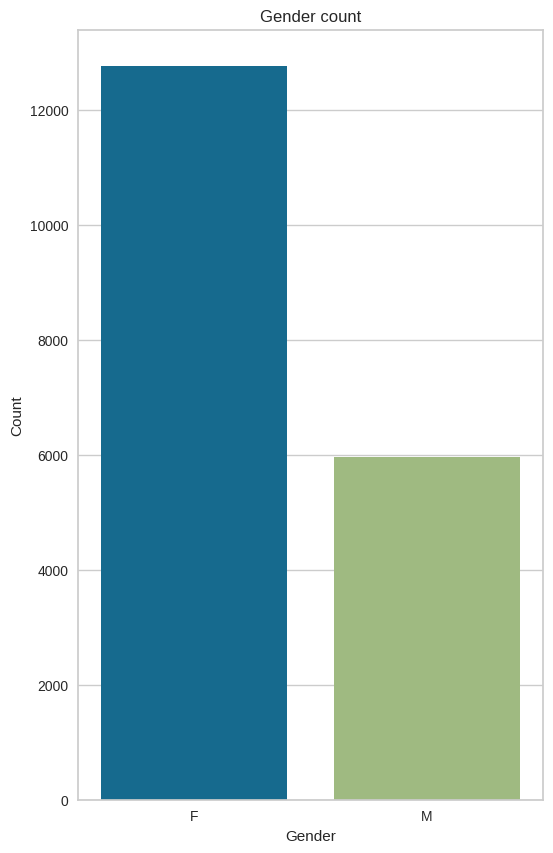

In [36]:
create_bar_plot(cc_train_copy,'Gender')

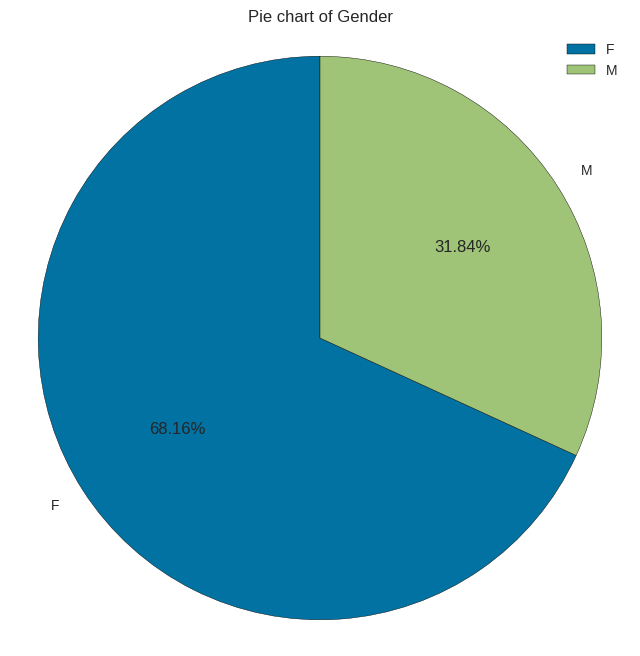

In [37]:
create_pie_plot(cc_train_copy,'Gender')

Interpretation:
- We have more female applicants than male (67% vs 32%)

### 2.3.2 Age

In [38]:
gen_info_feat(cc_train_copy,'Age')

Description:
count    18708.000000
mean        44.358849
std         11.585914
min         20.503765
25%         34.702259
50%         43.290897
75%         54.184805
max         68.829569
Name: Age, dtype: float64
**************************************************
Object type:int64


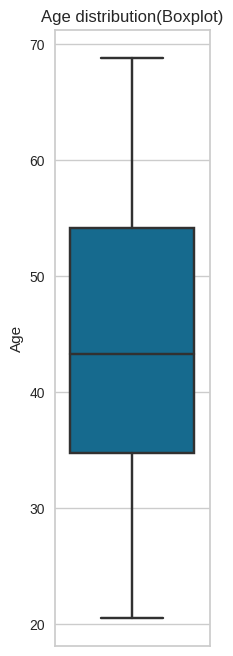

In [39]:
create_box_plot(cc_train_copy,'Age')

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


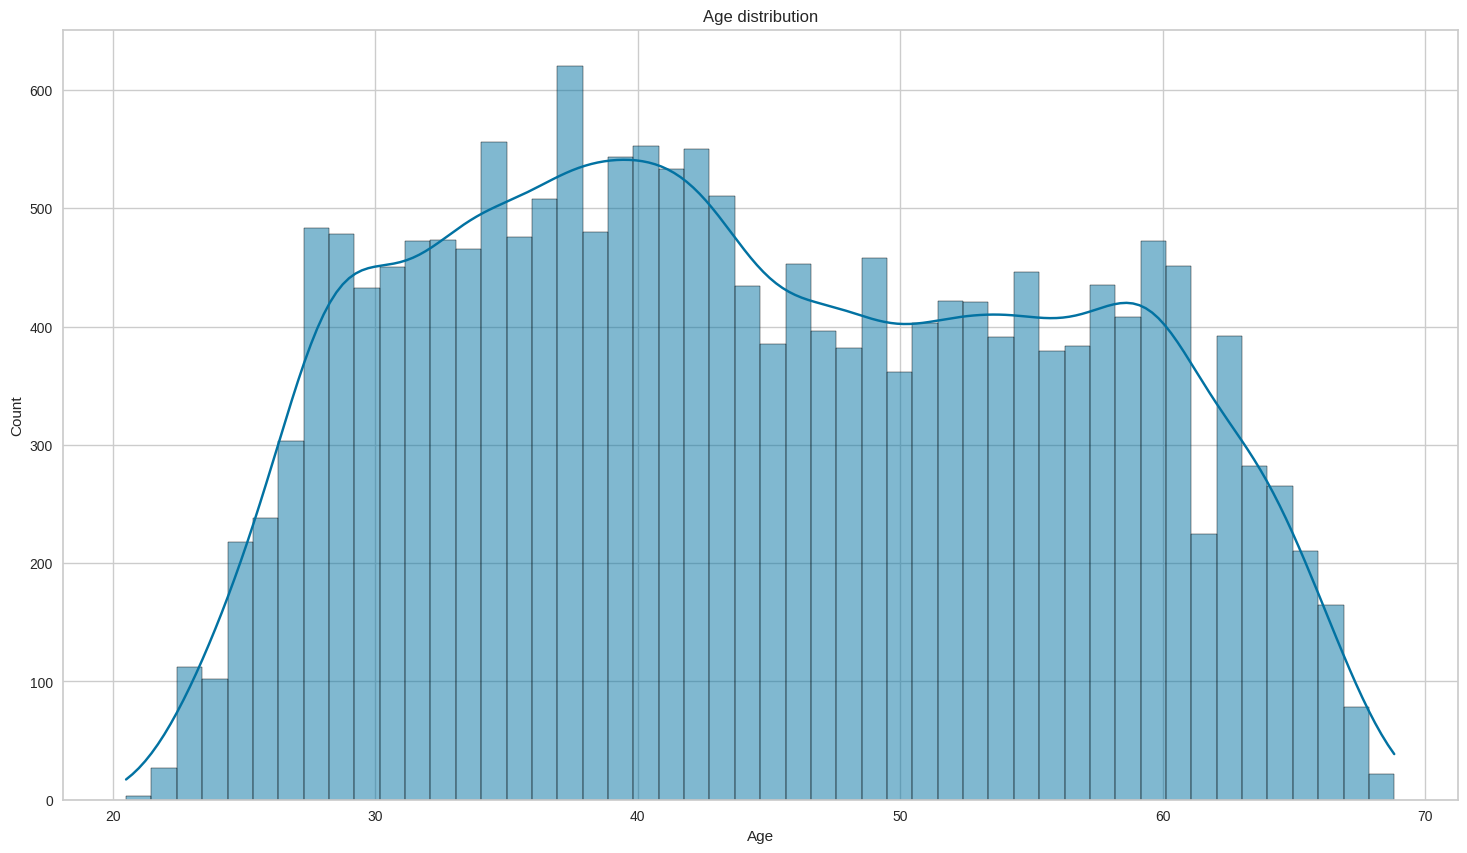

In [40]:
create_hist_plot(cc_train_copy,'Age')

* bivariate analysis with target variable

Is high risk
0    44.354034
1    45.117391
Name: Age, dtype: float64


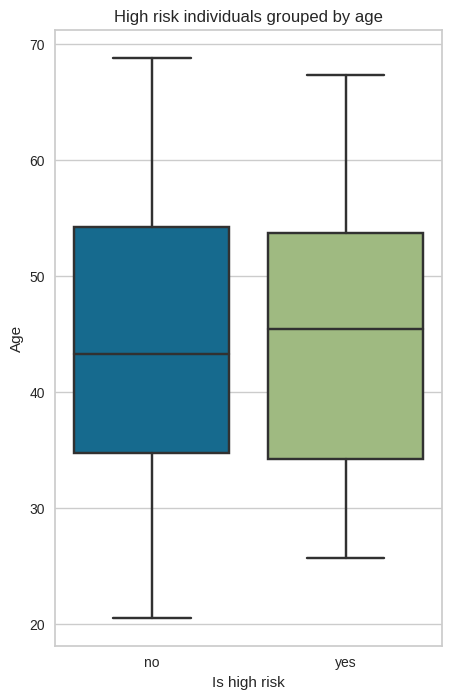

In [41]:
low_high_risk_box_plot(cc_train_copy,'Age')

Interpretation:
- The youngest applicant is 21 years old while the oldest is 68 years old. with the average of 44.3 and median of 43.2(outliers insensitive)
- Age feature is not normally distributed, it is slightly positively skew
- There is no difference between the average age of high and low risk applicants

### 2.3.3 Marital status

In [42]:
gen_info_feat(cc_train_copy,'Marital status')

Description:
count       18708
unique          5
top       Married
freq        12630
Name: Marital status, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
                      Count  Frequency (%)
Marital status                            
Married               12630      67.511225
Single / not married   2463      13.165491
Civil marriage         1560       8.338679
Separated              1164       6.221937
Widow                   891       4.762668


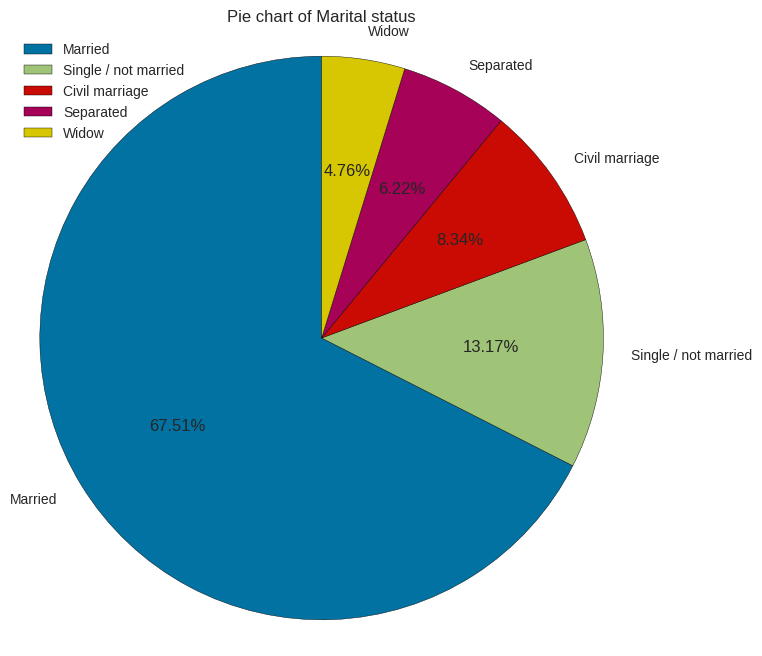

In [43]:
create_pie_plot(cc_train_copy,'Marital status')

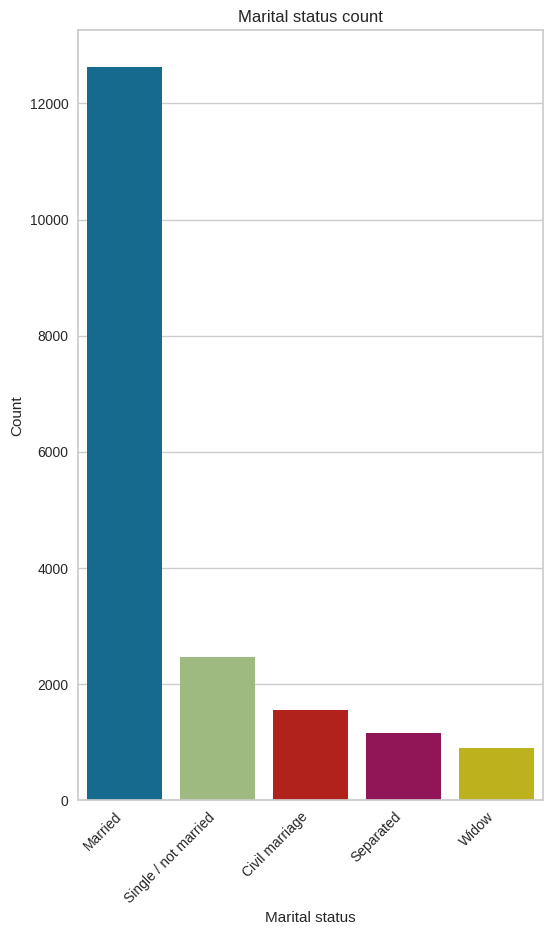

In [44]:
create_bar_plot(cc_train_copy,'Marital status')

{'Married': 79, 'Single / not married': 16, 'Widow': 10, 'Civil marriage': 7, 'Separated': 6}


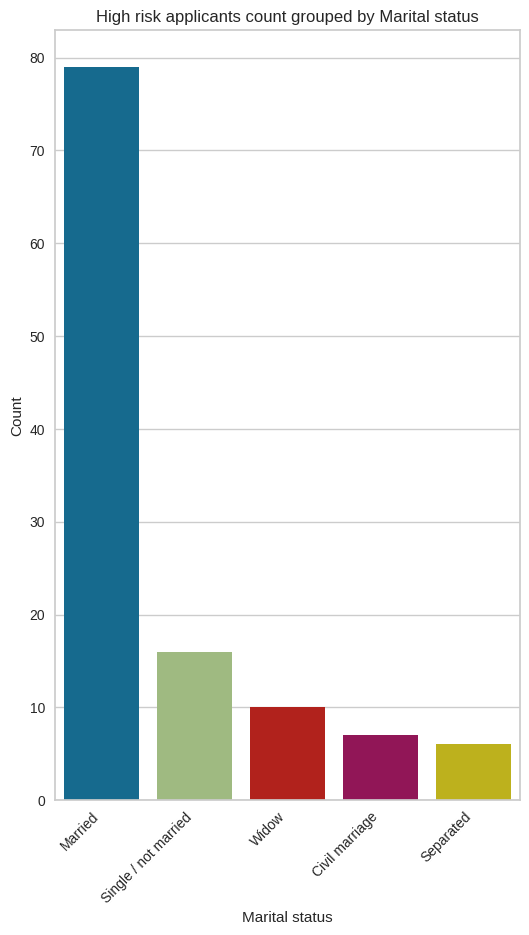

In [45]:
low_high_risk_bar_plot(cc_train_copy,'Marital status')

Interpretation:
- Most applicants are married
- Even though we have a higher number of applicants who are separated than those who are separated, it seems like separated applicants are high risk than those who are widow.

### 2.3.4 Family member count

In [46]:
gen_info_feat(cc_train_copy,'Family member count')

Description:
count    18708.000000
mean         2.160359
std          0.888470
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max         15.000000
Name: Family member count, dtype: float64
**************************************************
Object type:
float64
**************************************************
Value count:
                     Count  Frequency (%)
Family member count                      
2.0                  10134      54.169339
1.0                   3771      20.157152
3.0                   3094      16.538379
4.0                   1486       7.943126
5.0                    205       1.095788
6.0                     16       0.085525
15.0                     2       0.010691


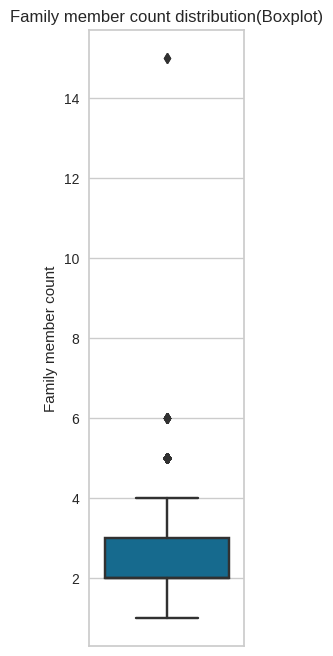

In [47]:
create_box_plot(cc_train_copy,'Family member count')

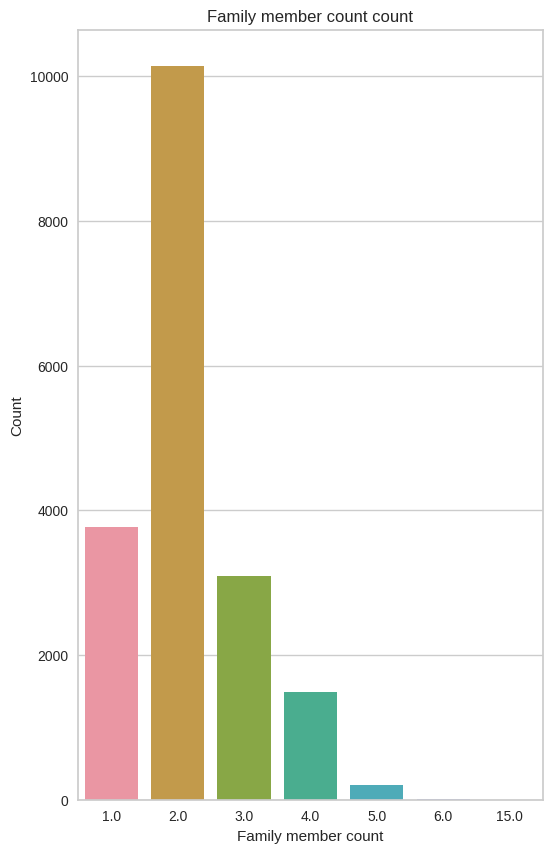

In [48]:
create_bar_plot(cc_train_copy,'Family member count')

Interpretation:
-   Most applicants are two in their household, this is also confirmed with the fact that most don’t have a child (more on this in a bit)
-   We also have 3 outliers


### 2.3.5 Children count

In [49]:
gen_info_feat(cc_train_copy,'Children count')

Description:
count    18708.000000
mean         0.401860
std          0.711527
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max         14.000000
Name: Children count, dtype: float64
**************************************************
Object type:
int64
**************************************************
Value count:
                Count  Frequency (%)
Children count                      
0               13244      70.793244
1                3690      19.724182
2                1536       8.210391
3                 217       1.159932
4                  18       0.096216
14                  2       0.010691
5                   1       0.005345


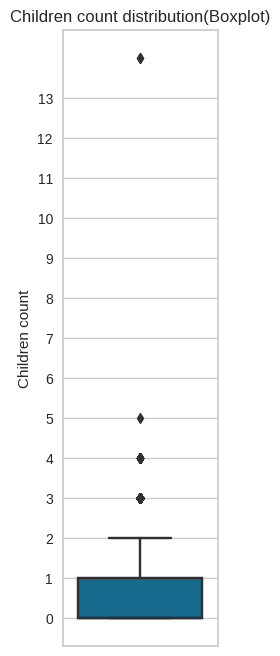

In [50]:
create_box_plot(cc_train_copy,'Children count')

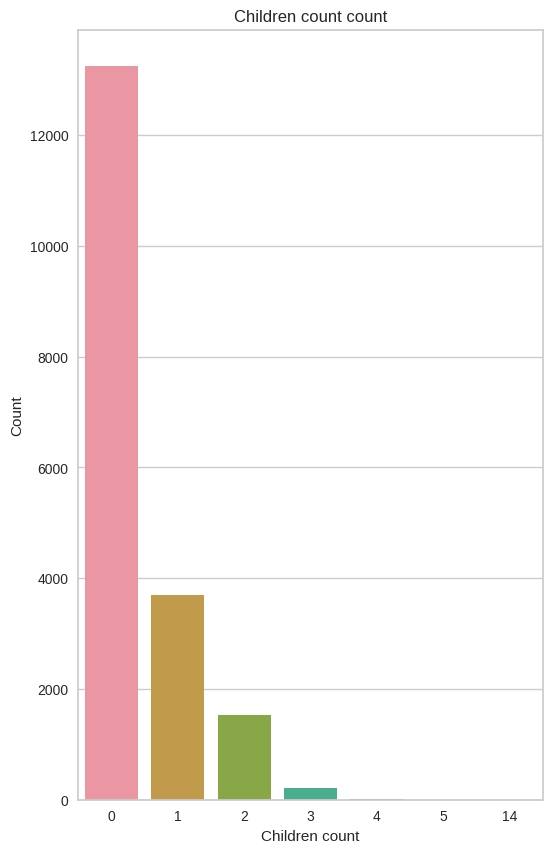

In [51]:
create_bar_plot(cc_train_copy,'Children count')

Interpretation:
-	As previously discussed most applicant don’t have a child
-	Also here we have 4 outliers

### 2.3.6 Dwelling type

In [52]:
gen_info_feat(cc_train_copy,'Dwelling')

Description:
count                 18708
unique                    6
top       House / apartment
freq                  16774
Name: Dwelling, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
                     Count  Frequency (%)
Dwelling                                 
House / apartment    16774      89.662177
With parents           887       4.741287
Municipal apartment    559       2.988027
Rented apartment       306       1.635664
Office apartment       116       0.620056
Co-op apartment         66       0.352790


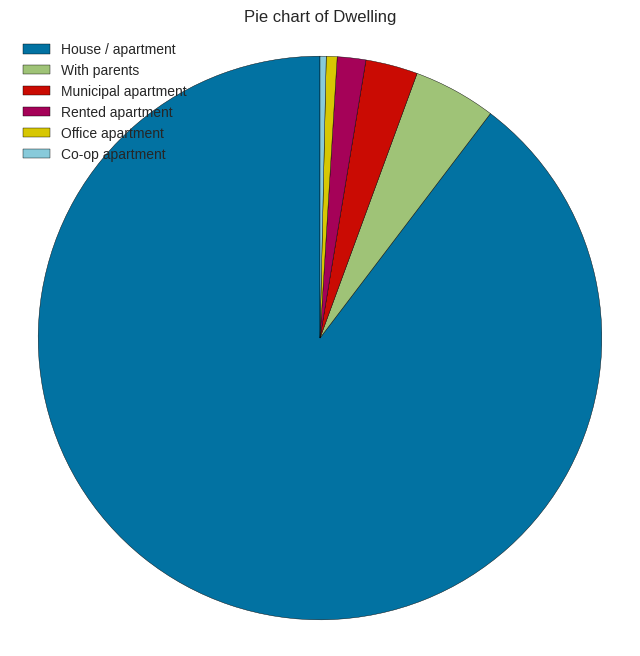

In [53]:
create_pie_plot(cc_train_copy,'Dwelling')

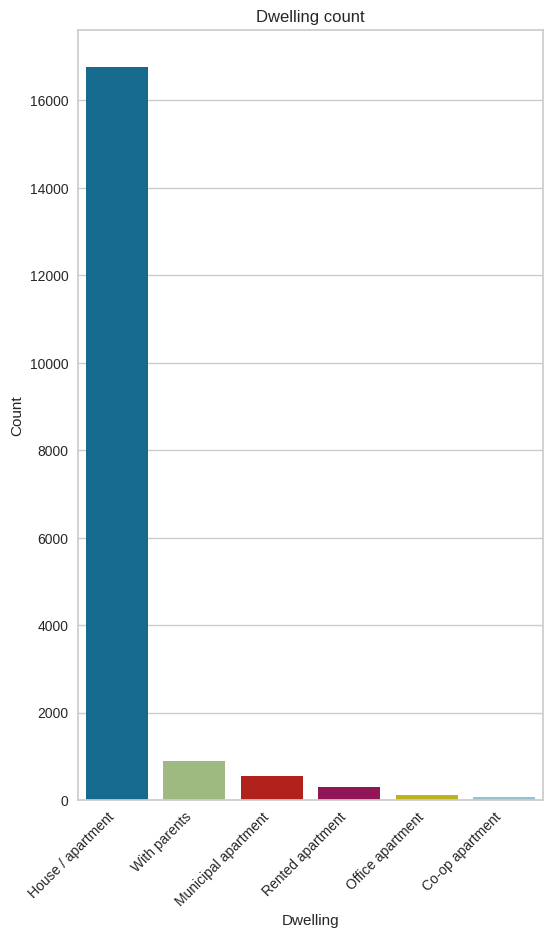

In [54]:
create_bar_plot(cc_train_copy,'Dwelling')

Interpretation:
- Almost every applicants live in house or apartment

### 2.3.7 Income

In [55]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
gen_info_feat(cc_train_copy,'Income')

Description:
count     18708.00
mean     187524.81
std      100861.99
min       30150.00
25%      121500.00
50%      157500.00
75%      225000.00
max     1350000.00
Name: Income, dtype: float64
**************************************************
Object type:
float64
**************************************************
Value count:
           Count  Frequency (%)
Income                         
135000.00   2217          11.85
112500.00   1527           8.16
157500.00   1525           8.15
225000.00   1518           8.11
180000.00   1418           7.58
...          ...            ...
160200.00      1           0.01
51750.00       1           0.01
661500.00      1           0.01
73575.00       1           0.01
191250.00      1           0.01

[209 rows x 2 columns]


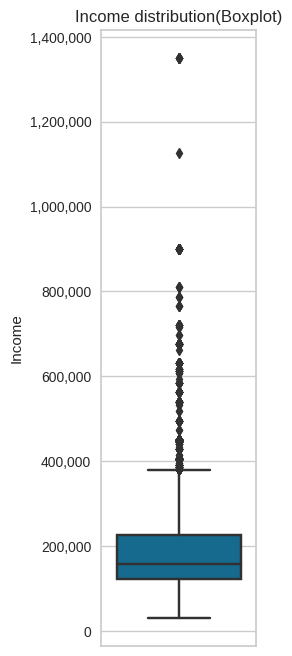

In [56]:
create_box_plot(cc_train_copy,'Income')

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


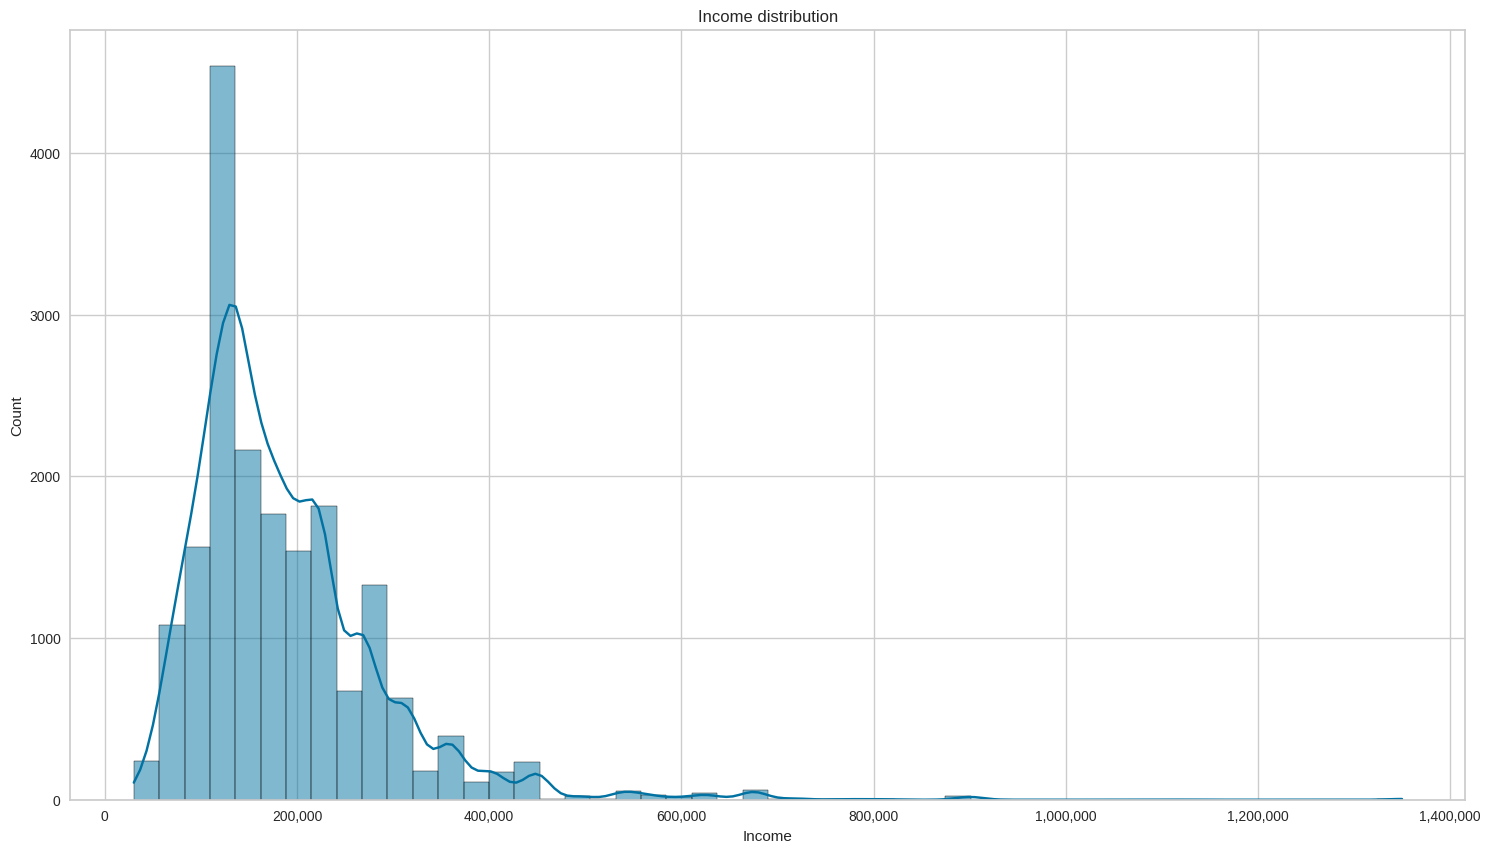

In [57]:
create_hist_plot(cc_train_copy,'Income')

* bivariate analysis with target variable

Is high risk
0   187505.67
1   190540.03
Name: Income, dtype: float64


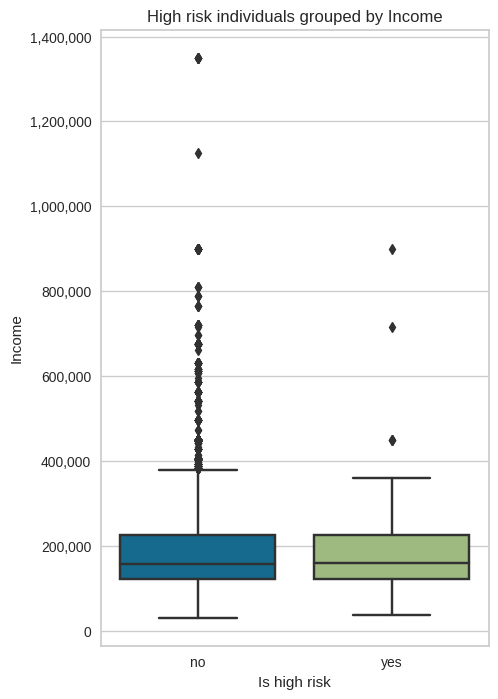

In [58]:
low_high_risk_box_plot(cc_train_copy,'Income')

Interpretation:
-	The average income is 187524.81 but this amount accounts for outliers. If we ignore the outlier most people make 157500
-	We have 2 applicants who makes more than 1000000
-	This feature is positively skewed
-	High risk and low risk applicants have roughly similar income

### 2.3.8 Job title

In [59]:
gen_info_feat(cc_train_copy,'Job title')

Description:
count        12696
unique          18
top       Laborers
freq          3150
Name: Job title, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
                       Count  Frequency (%)
Job title                                  
Laborers                3150          24.81
Core staff              1856          14.62
Sales staff             1713          13.49
Managers                1578          12.43
Drivers                 1114           8.77
High skill tech staff    727           5.73
Medicine staff           605           4.77
Accountants              547           4.31
Cooking staff            333           2.62
Cleaning staff           325           2.56
Security staff           302           2.38
Private service staff    157           1.24
Low-skill Laborers        79           0.62
Secretaries               74           0.58
Waiters/barmen staff      53           0.

In [60]:
job_title_nan_count = cc_train_copy['Job title'].isna().sum()
job_title_nan_count

6012

In [61]:
rows_total_count = cc_train_copy.shape[0]

In [62]:
print('The percentage of missing rows is {:.2f} %'.format(job_title_nan_count * 100 / rows_total_count))

The percentage of missing rows is 32.14 %


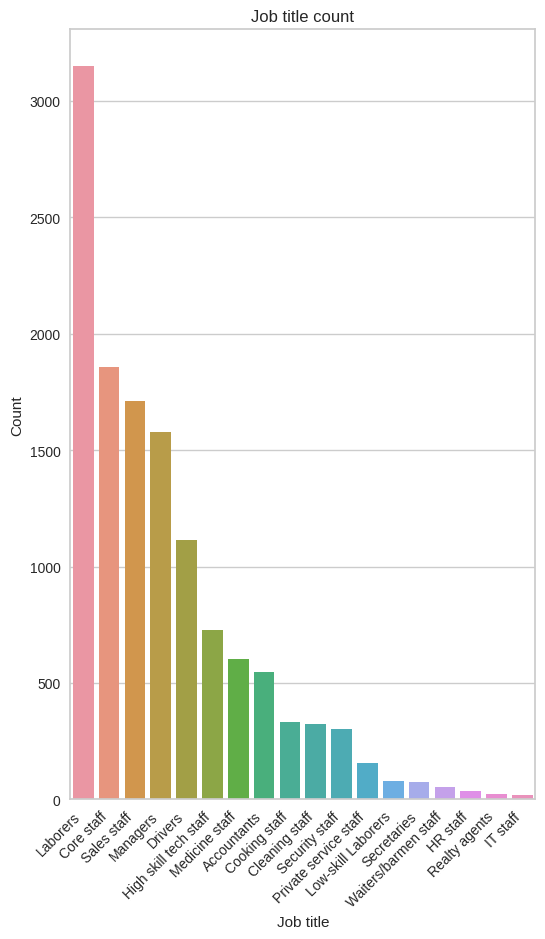

In [63]:
create_bar_plot(cc_train_copy,'Job title')

Interpretation:
-	The most prolific Job title is laborers by far
-	We have 32.14% if missing data

### 2.3.9 Employment status

In [64]:
gen_info_feat(cc_train_copy,'Employment status')

Description:
count       18708
unique          5
top       Working
freq         9509
Name: Employment status, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
                      Count  Frequency (%)
Employment status                         
Working                9509          50.83
Commercial associate   4356          23.28
Pensioner              3381          18.07
State servant          1452           7.76
Student                  10           0.05


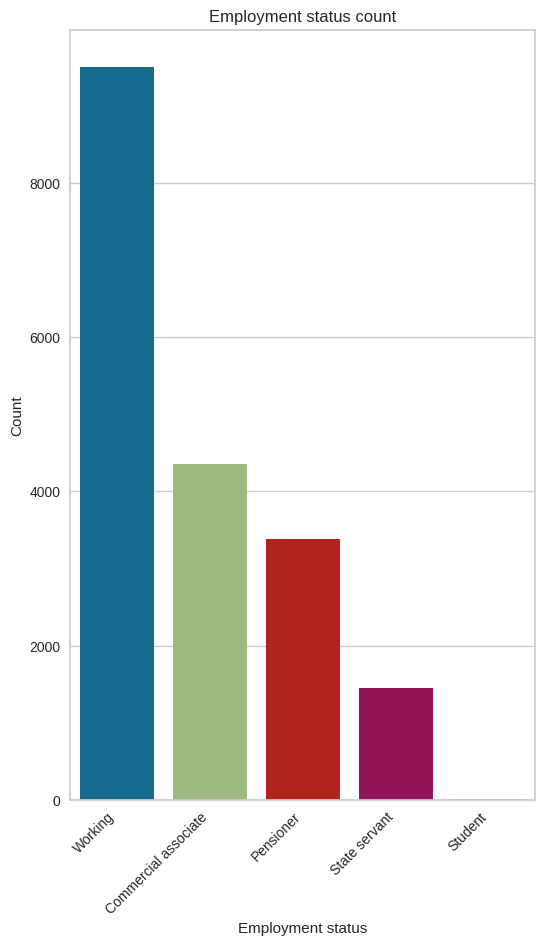

In [65]:
create_bar_plot(cc_train_copy,'Employment status')

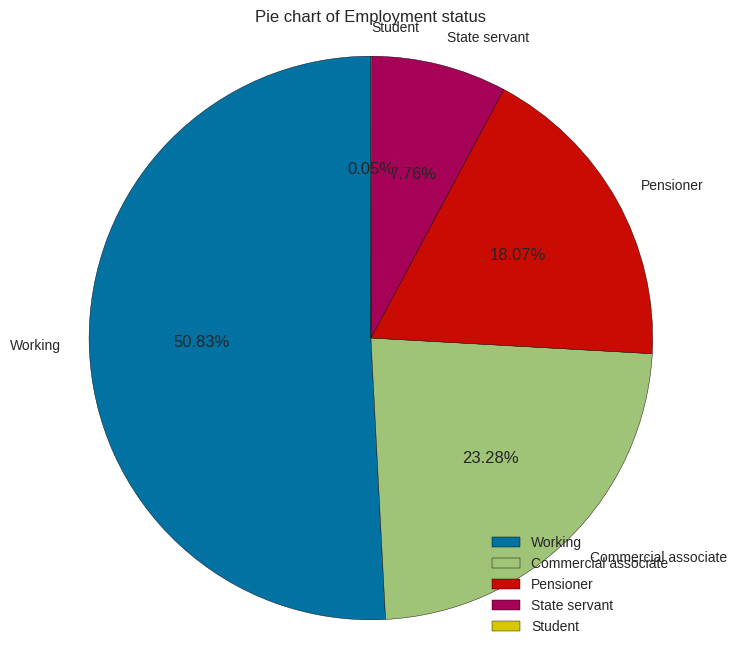

In [66]:
create_pie_plot(cc_train_copy,'Employment status')

Interpretation:
- Most applicants are employed

### 2.3.10 Education level

In [67]:
gen_info_feat(cc_train_copy,'Education level')

Description:
count                             18708
unique                                5
top       Secondary / secondary special
freq                              12754
Name: Education level, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
                               Count  Frequency (%)
Education level                                    
Secondary / secondary special  12754          68.17
Higher education                5045          26.97
Incomplete higher                698           3.73
Lower secondary                  190           1.02
Academic degree                   21           0.11


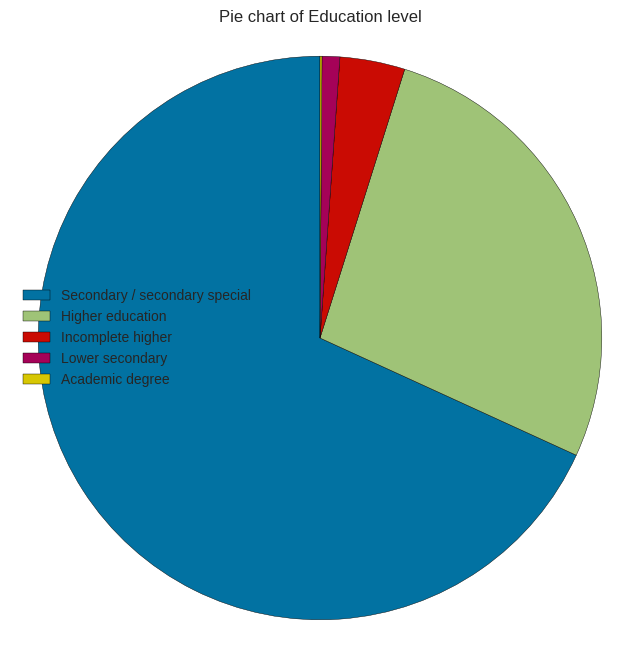

In [68]:
create_pie_plot(cc_train_copy,'Education level')

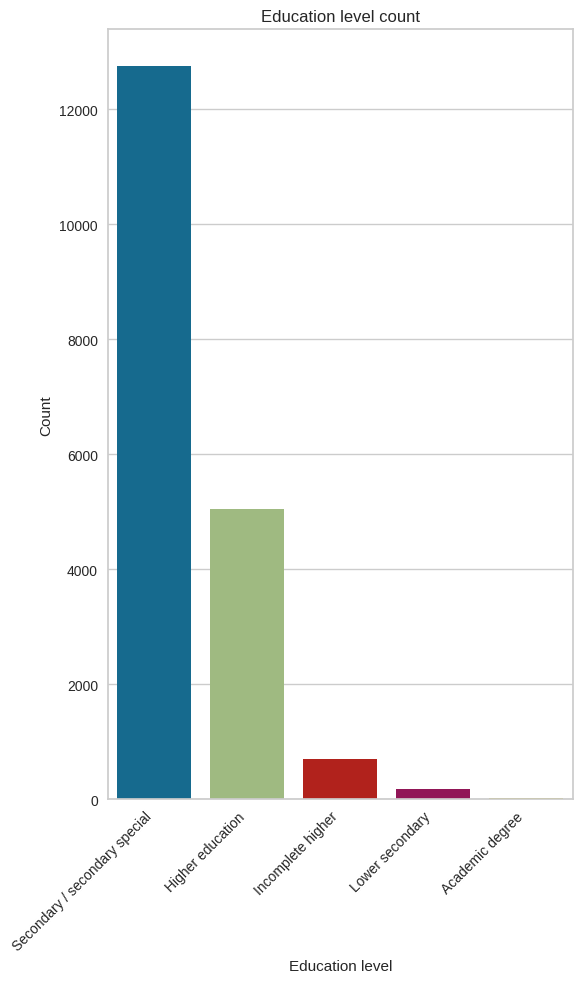

In [69]:
create_bar_plot(cc_train_copy,'Education level')

Interpretation:
-	The majority of applicants have completed their secondary degree, ¼ completed their higher education

### 2.3.11 Employment length

In [70]:
gen_info_feat(cc_train_copy,'Employment length')

Description:
count   15327.00
mean        7.42
std         6.55
min         0.05
25%         2.80
50%         5.51
75%         9.89
max        41.69
Name: Employment length, dtype: float64
**************************************************
Object type:float64


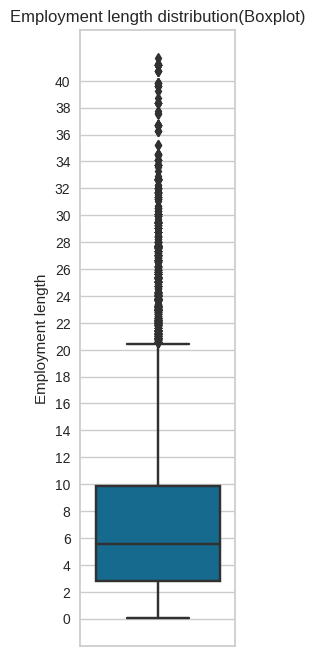

In [71]:
create_box_plot(cc_train_copy,'Employment length')

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


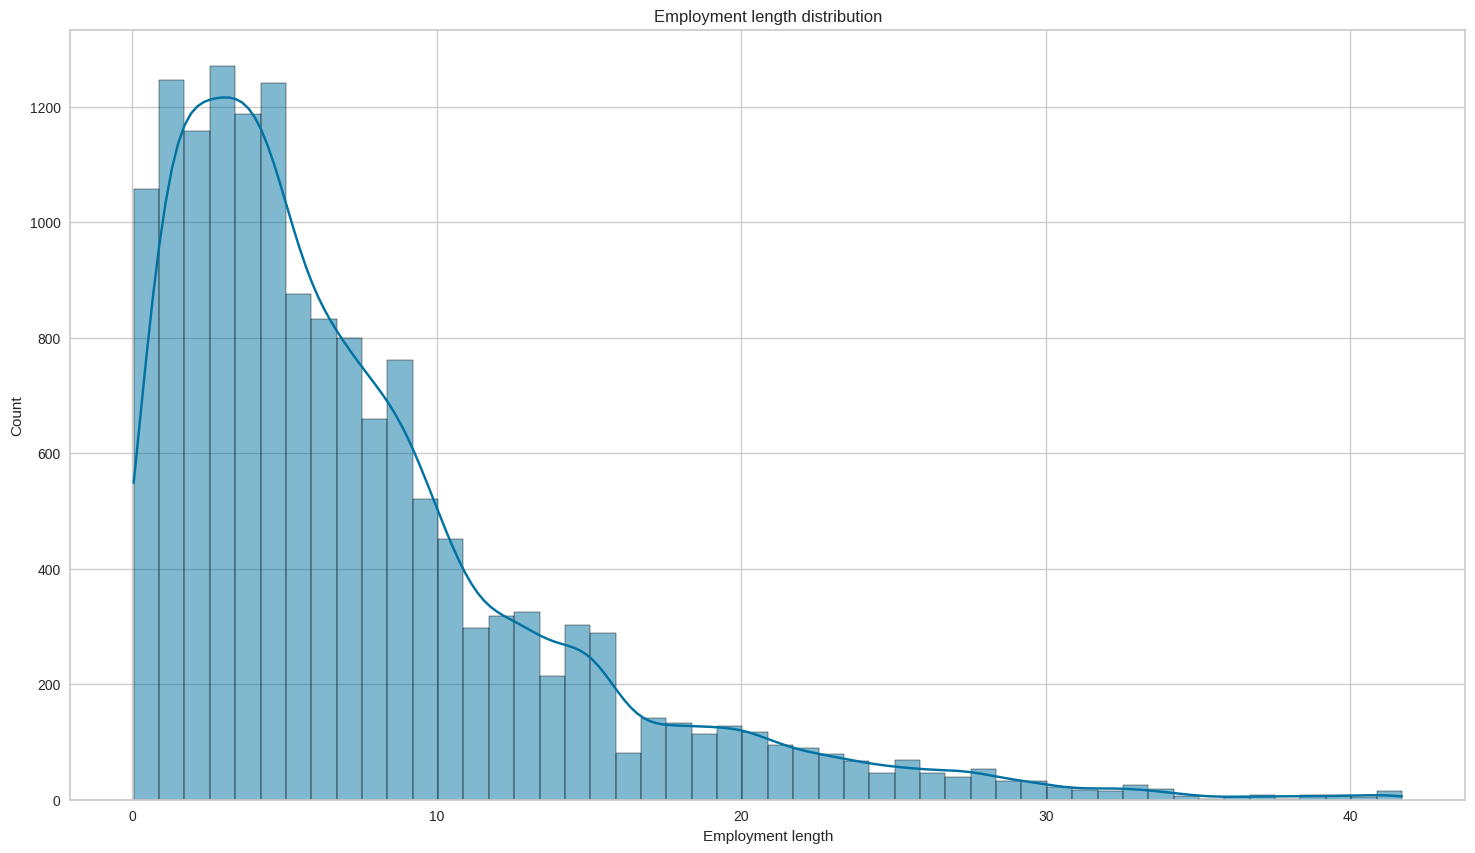

In [72]:
create_hist_plot(cc_train_copy,'Employment length')

* bivariate analysis with target variable

Is high risk
0   7.42
1   6.81
Name: Employment length, dtype: float64


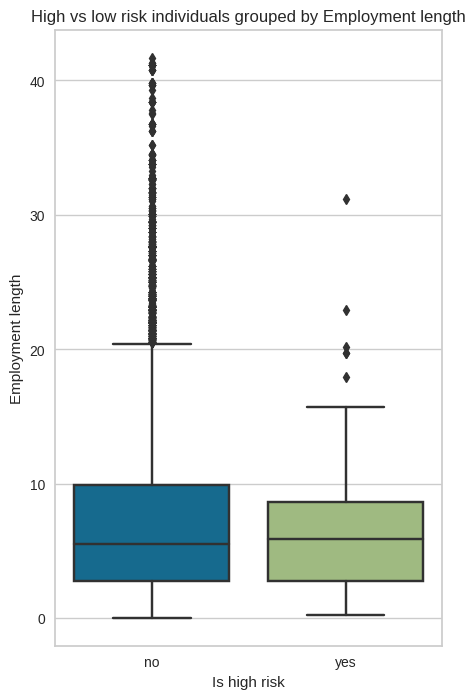

In [73]:
# distribution of employment length for high vs low risk applicants
# Here 0 means No and 1 means Yes
low_high_risk_box_plot(cc_train_copy,'Employment length')

Interpretation:
-	Most of applicant have been working for 5 to 7 years on average
-	We have quite a number of outliers who have been working for more than 20 years+
-	The employment length is positively skewed
-	Those who are high risk have a low employment length of 5 versus 7 years for the low risk


### 2.3.12 Has a car

In [74]:
gen_info_feat(cc_train_copy,'Has a car')

Description:
count     18708
unique        2
top           N
freq      11682
Name: Has a car, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
           Count  Frequency (%)
Has a car                      
N          11682          62.44
Y           7026          37.56


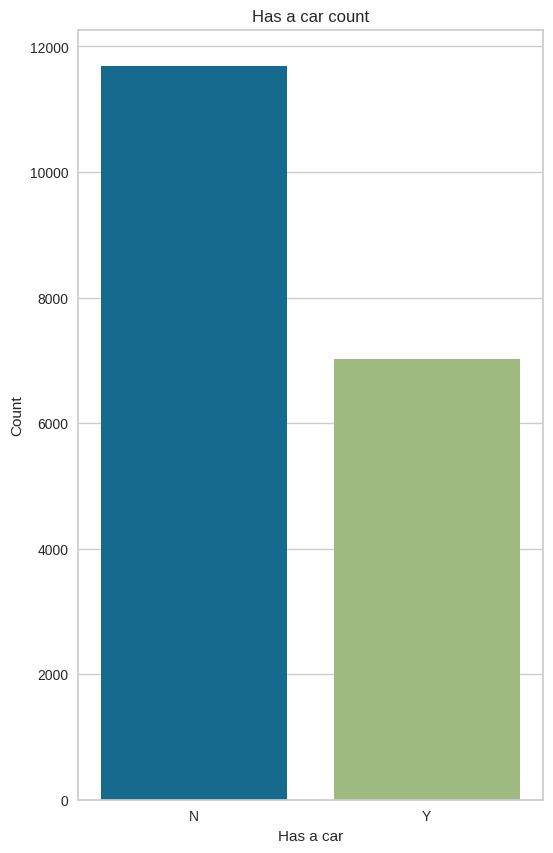

In [75]:
create_bar_plot(cc_train_copy,'Has a car')

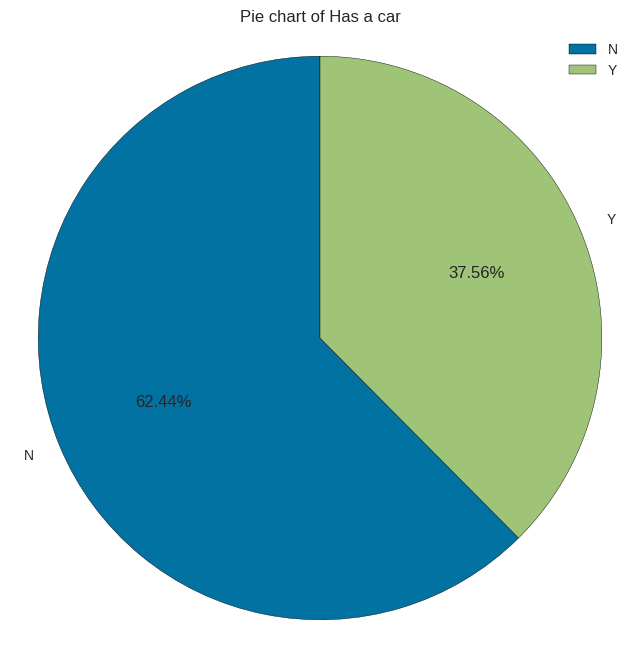

In [76]:
create_pie_plot(cc_train_copy,'Has a car')

Interpretation:
- Most applicant don’t own a car

### 2.3.13 Has a property

In [77]:
gen_info_feat(cc_train_copy,'Has a property')

Description:
count     18708
unique        2
top           Y
freq      13274
Name: Has a property, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
                Count  Frequency (%)
Has a property                      
Y               13274          70.95
N                5434          29.05


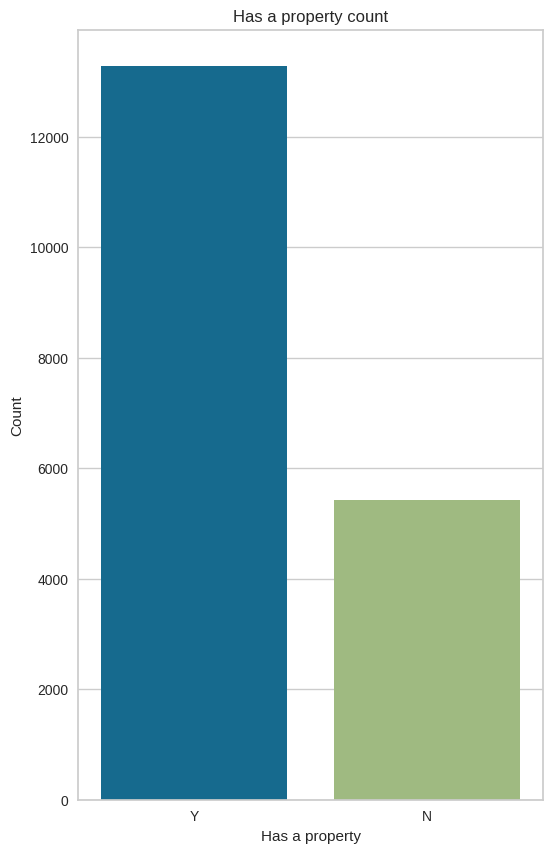

In [78]:
create_bar_plot(cc_train_copy,'Has a property')

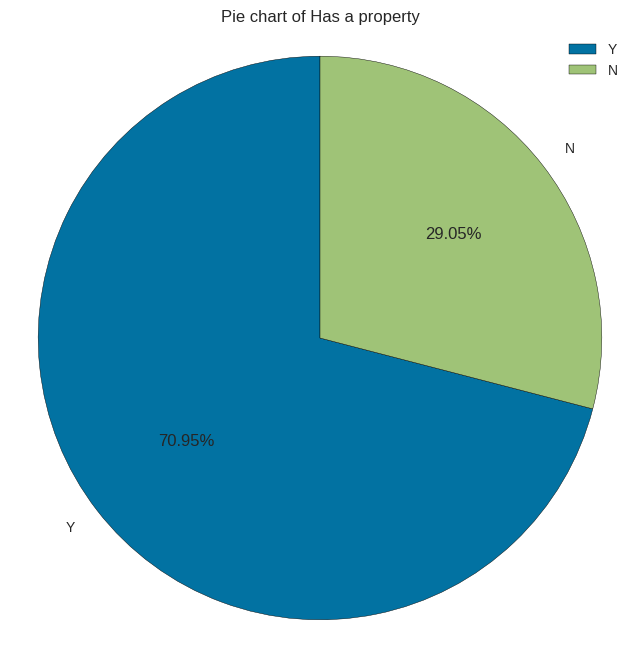

In [79]:
create_pie_plot(cc_train_copy,'Has a property')

Interpretation:
- Most applicants own a property

### 2.3.14 Has a work phone

In [80]:
gen_info_feat(cc_train_copy,'Has a work phone')

Description:
count   18708.00
mean        0.20
std         0.40
min         0.00
25%         0.00
50%         0.00
75%         0.00
max         1.00
Name: Has a work phone, dtype: float64
**************************************************
Object type:
float64
**************************************************
Value count:
                  Count  Frequency (%)
Has a work phone                      
0.00              14919          79.75
1.00               3789          20.25


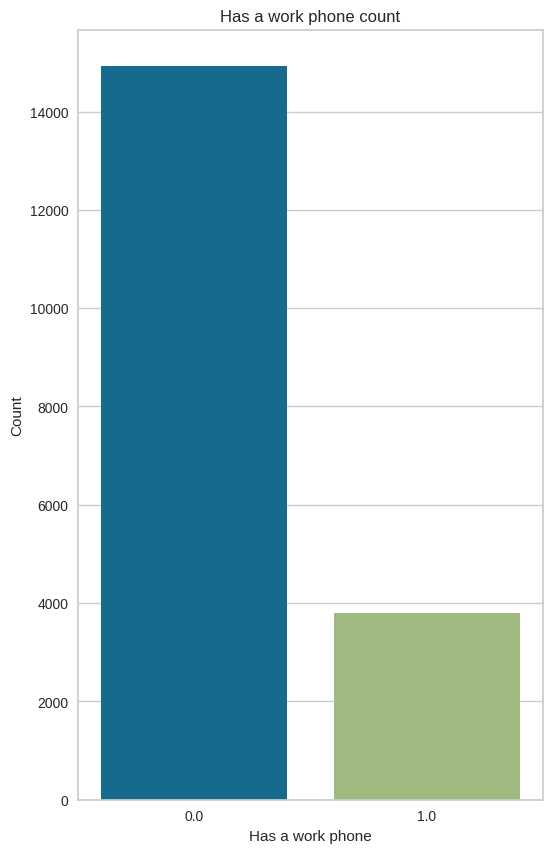

In [81]:
create_bar_plot(cc_train_copy,'Has a work phone')

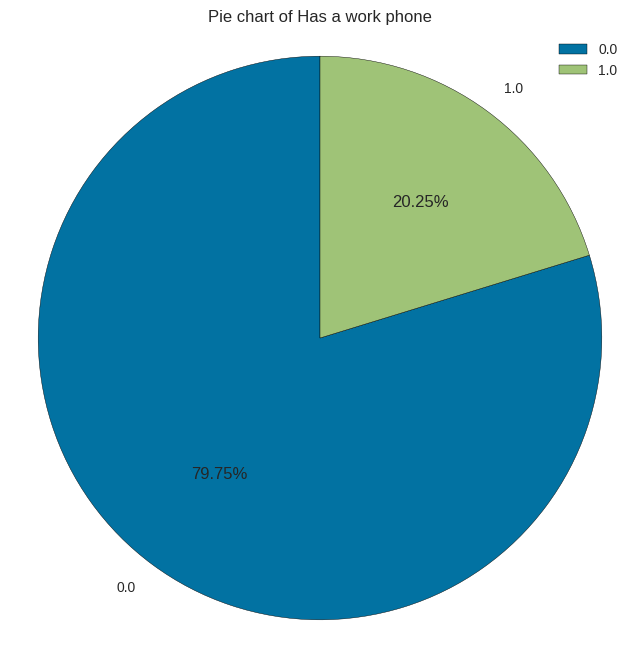

In [82]:
create_pie_plot(cc_train_copy,'Has a work phone')

Interpretation:
- More than ¾ of applicants don’t have a work phone

Note: Here 0 is no and 1 is yes

### 2.3.15 Has a mobile phone

In [83]:
gen_info_feat(cc_train_copy,'Has a mobile phone')

Description:
count   18708.00
mean        1.00
std         0.00
min         1.00
25%         1.00
50%         1.00
75%         1.00
max         1.00
Name: Has a mobile phone, dtype: float64
**************************************************
Object type:
float64
**************************************************
Value count:
                    Count  Frequency (%)
Has a mobile phone                      
1.00                18708         100.00


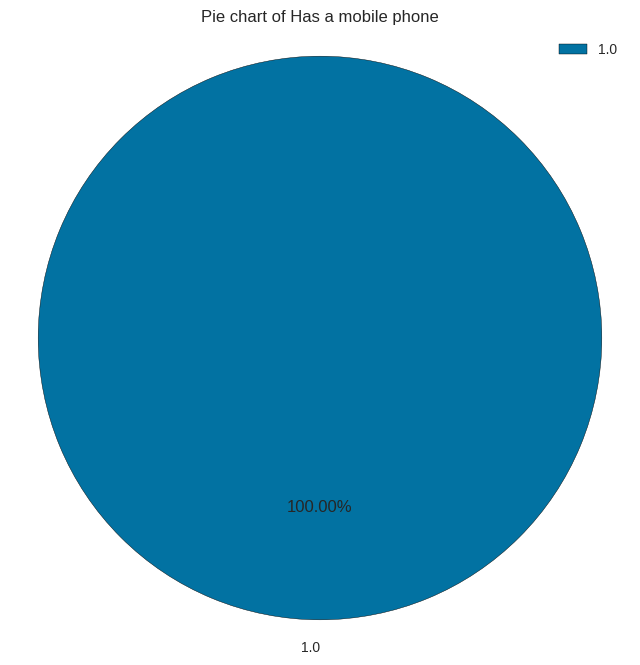

In [84]:
create_pie_plot(cc_train_copy,'Has a mobile phone')

Interpretation:
- All the applicants without exception have a mobile phone

Note: Here 0 is no and 1 is yes

### 2.3.16 Has a phone

In [85]:
gen_info_feat(cc_train_copy,'Has a phone')

Description:
count   18708.00
mean        0.29
std         0.45
min         0.00
25%         0.00
50%         0.00
75%         1.00
max         1.00
Name: Has a phone, dtype: float64
**************************************************
Object type:
float64
**************************************************
Value count:
             Count  Frequency (%)
Has a phone                      
0.00         13288          71.03
1.00          5420          28.97


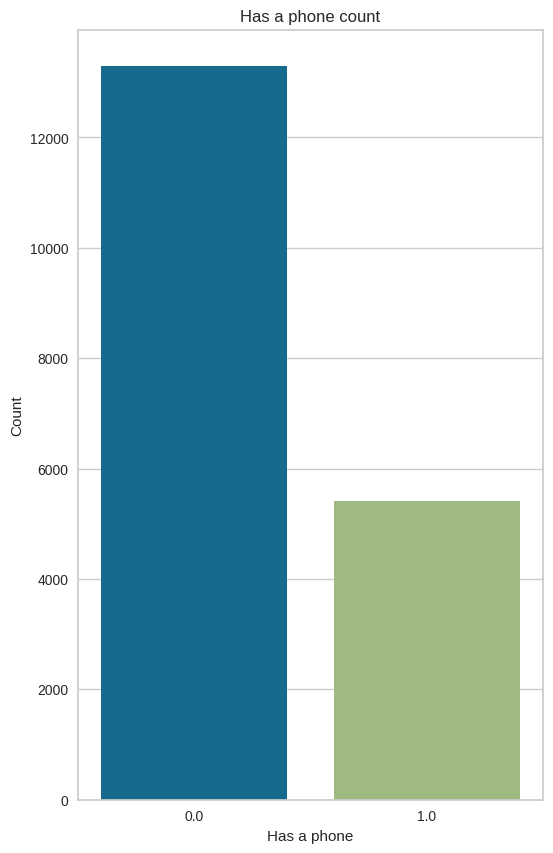

In [86]:
create_bar_plot(cc_train_copy,'Has a phone')

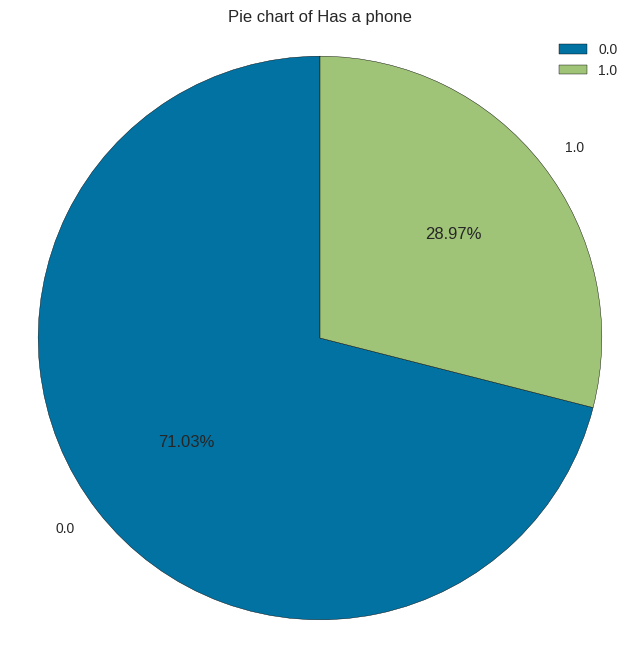

In [87]:
create_pie_plot(cc_train_copy,'Has a phone')

Interpretation:
- Most applicants don’t have a phone (probably a home phone)

Note: Here 0 is no and 1 is yes

### 2.3.17 Has an email

In [88]:
gen_info_feat(cc_train_copy,'Has an email')

Description:
count   18708.00
mean        0.10
std         0.30
min         0.00
25%         0.00
50%         0.00
75%         0.00
max         1.00
Name: Has an email, dtype: float64
**************************************************
Object type:
float64
**************************************************
Value count:
              Count  Frequency (%)
Has an email                      
0.00          16866          90.15
1.00           1842           9.85


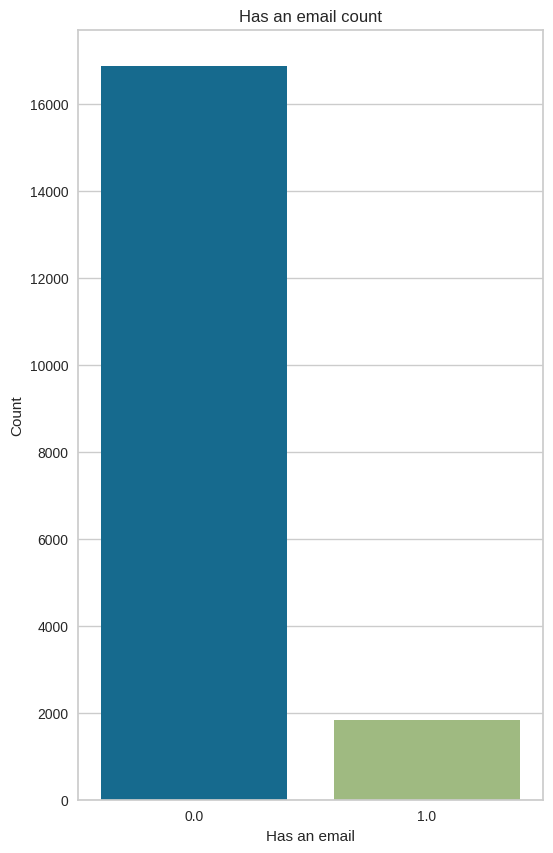

In [89]:
create_bar_plot(cc_train_copy,'Has an email')

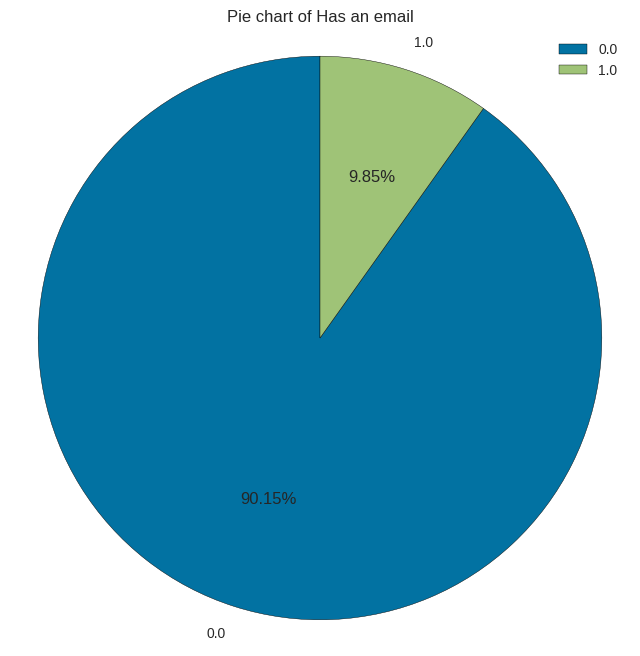

In [90]:
create_pie_plot(cc_train_copy,'Has an email')

Interpretation:
- More than 90% of applicants don’t have an email

Note: Here 0 is no and 1 is yes

### 2.3.18 Account age

In [91]:
gen_info_feat(cc_train_copy,'Account age')

Description:
count   18708.00
mean       26.16
std        16.56
min         0.00
25%        12.00
50%        24.00
75%        39.00
max        60.00
Name: Account age, dtype: float64
**************************************************
Object type:float64


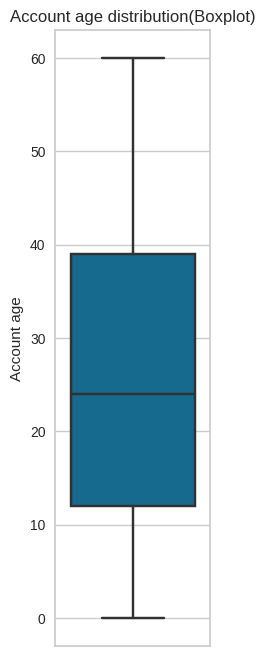

In [92]:
create_box_plot(cc_train_copy,'Account age')

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


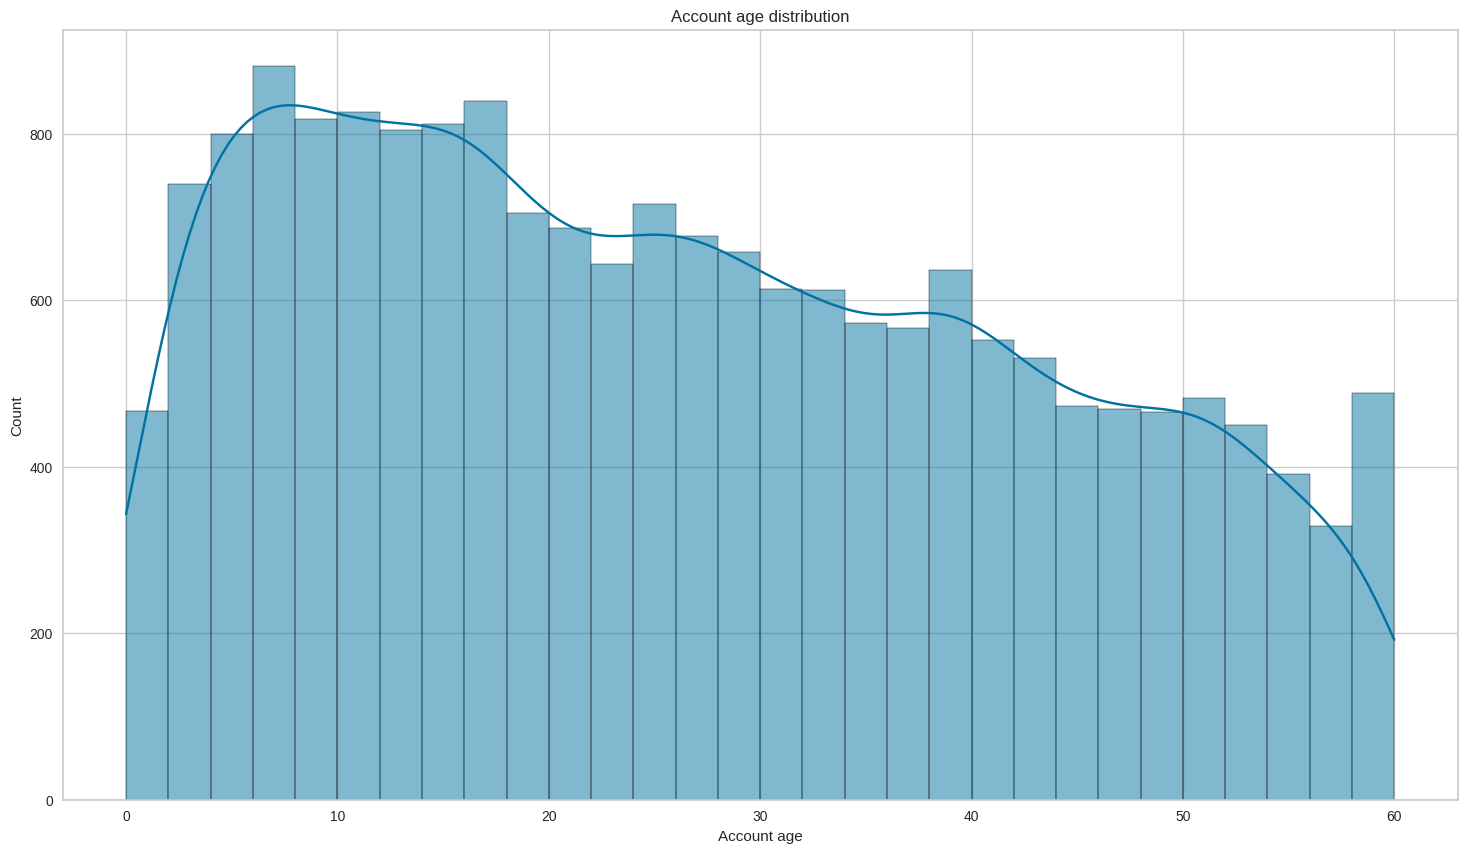

In [93]:
create_hist_plot(cc_train_copy,'Account age', the_bins=30)

* bivariate analysis with target variable

Is high risk
0   26.04
1   45.36
Name: Account age, dtype: float64


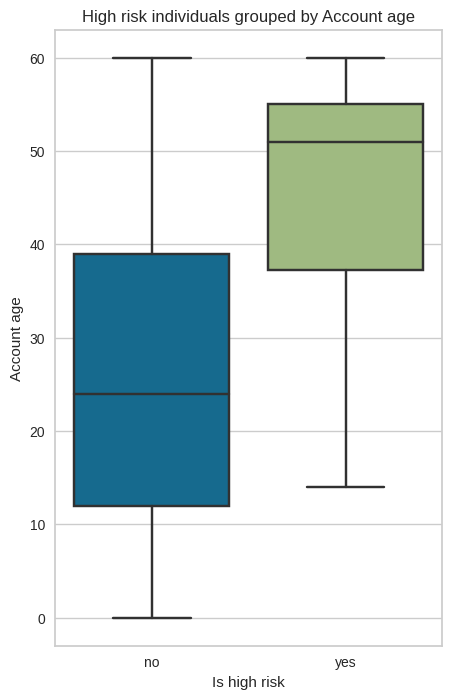

In [94]:
low_high_risk_box_plot(cc_train_copy,'Account age')

Interpretation:
-	Most accounts are 26 months old
-	Account age is not normally distributed, it is positively skewed
-	The accounts that have been flagged as high risk are on average 34 months old vs 26 months old for old account

### 2.3.19 Is high risk (target variable)

In [95]:
gen_info_feat(cc_train_copy,'Is high risk')

Description:
count     18708
unique        2
top           0
freq      18590
Name: Is high risk, dtype: int64
**************************************************
Object type:
object
**************************************************
Value count:
              Count  Frequency (%)
Is high risk                      
0             18590          99.37
1               118           0.63


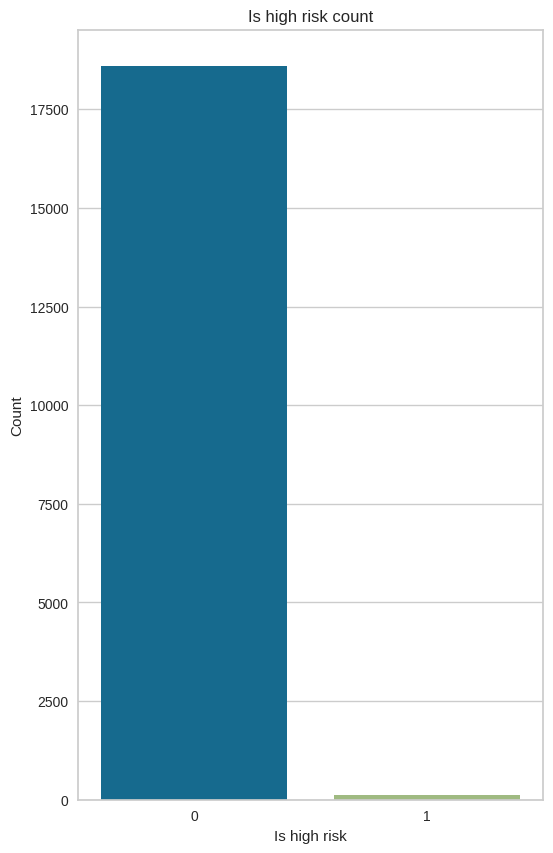

In [96]:
create_bar_plot(cc_train_copy,'Is high risk')

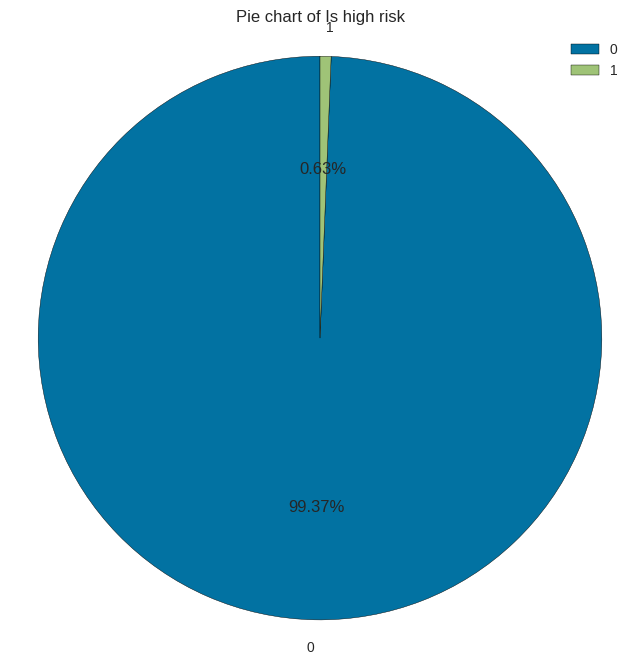

In [97]:
create_pie_plot(cc_train_copy,'Is high risk')

Interpretation:
- A vast majority of applicants are low risk applicants.
- We have a very imbalance data.

Note: Here 0 is no and 1 is yes


## 2.4 Bivariate analysis

### 2.4.1 Numerical vs numerical features (Correlation & scatter plots)

#### 2.4.1.1 Scatter plots

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

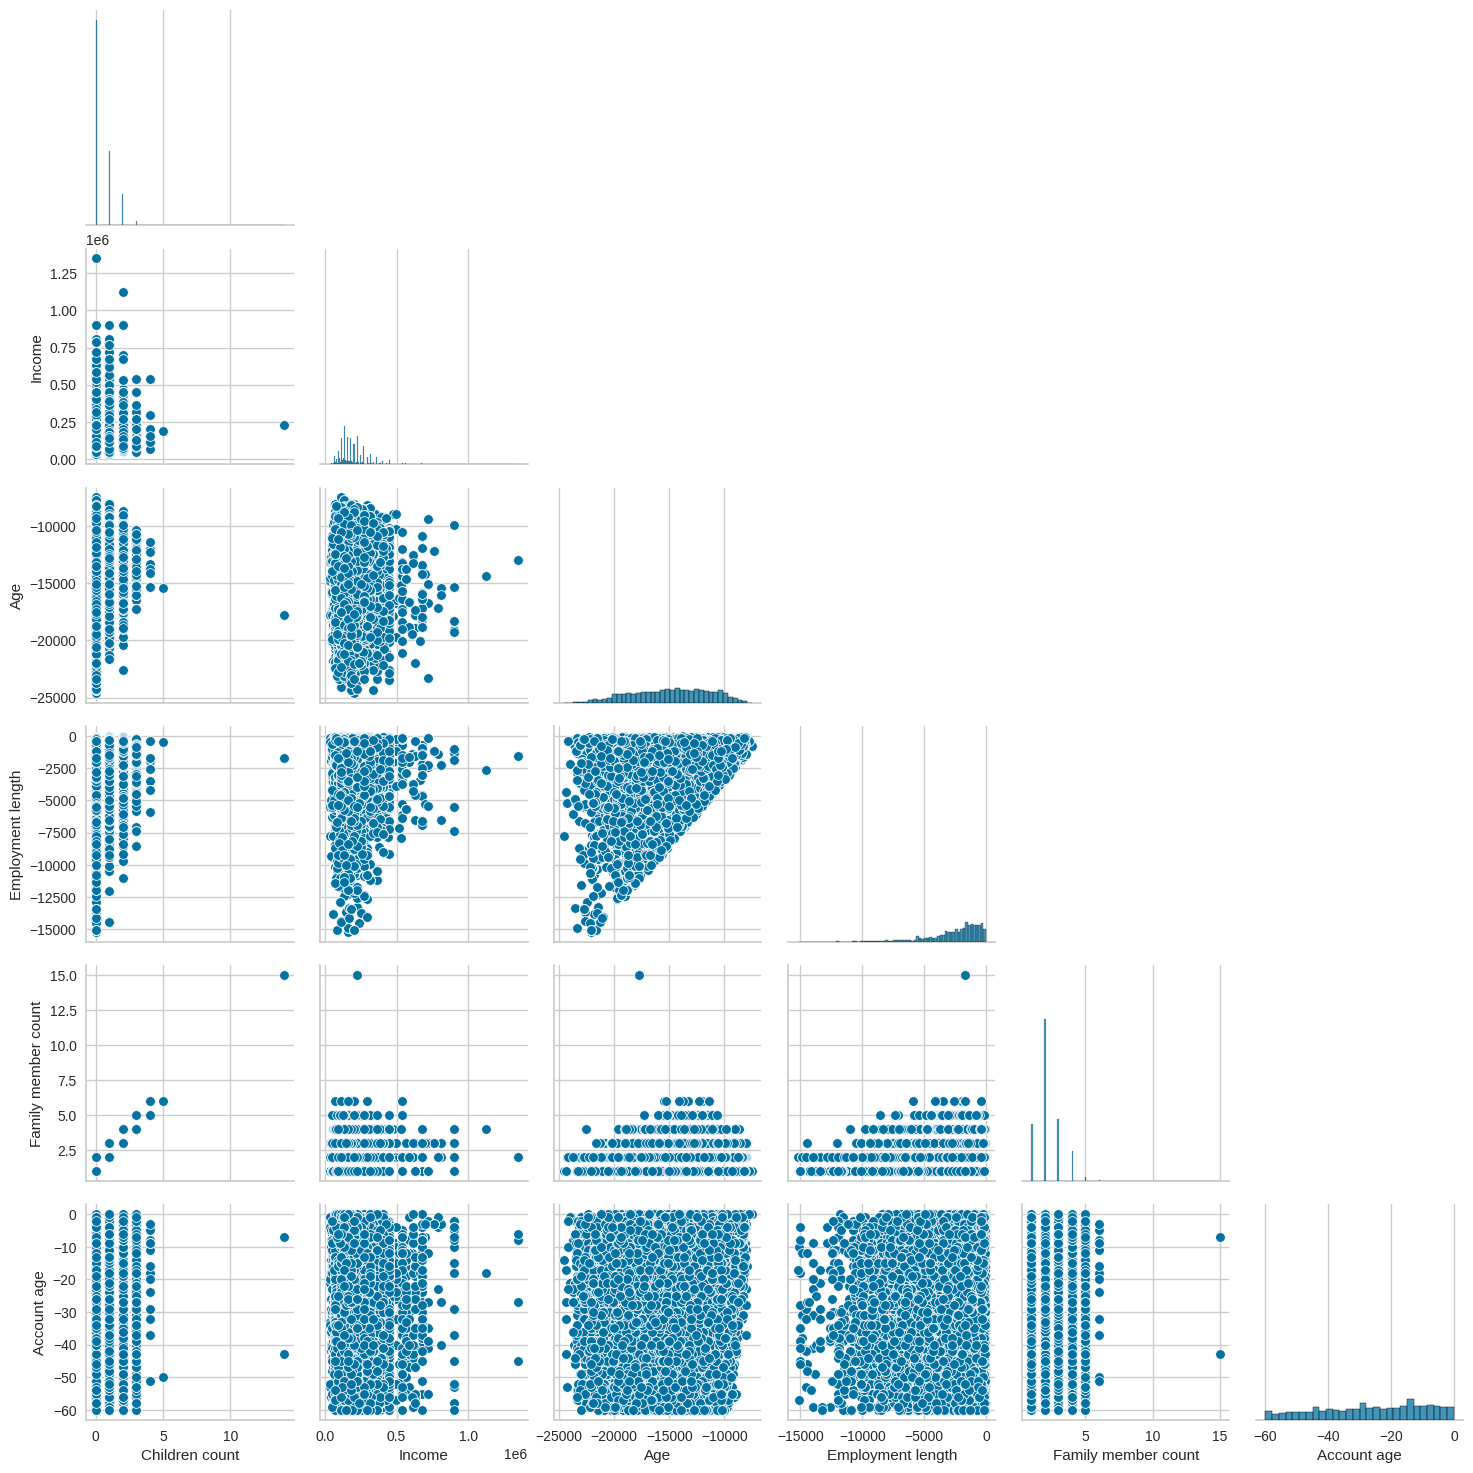

In [98]:
sns.pairplot(cc_train_copy[cc_train_copy['Employment length'] < 0].drop(['ID','Has a mobile phone', 'Has a work phone', 'Has a phone', 'Has an email','Is high risk'],axis=1),corner=True)
plt.show()

Interpretation:
- We can see a positive linear correlation between the family member and the children count. This makes sense, the more the children someone have, the larger the family member count. This is a multicollinearity problem. Meaning that the features are highly correlated. We will need to drop one of them.
- Another interesting trend is the Employment length and age. This also makes sense, the longer the employee has been working, the older they are.

##### 2.4.1.1.1 Family member count vs children count (numerical vs numerical feature comparison)

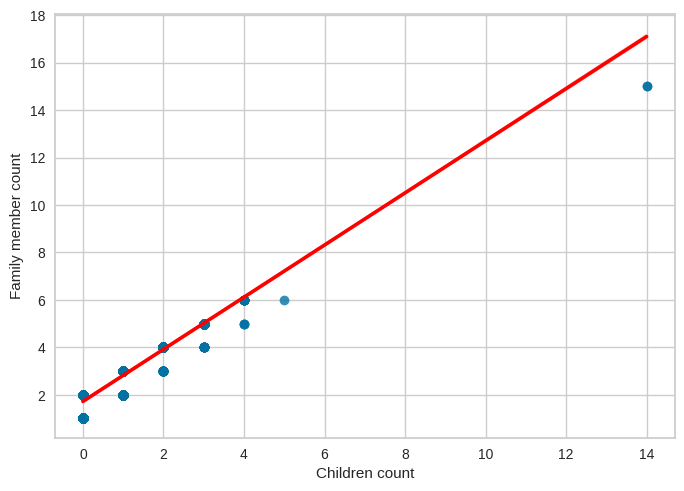

In [99]:
sns.regplot(x='Children count',y='Family member count',data=cc_train_copy,line_kws={'color': 'red'})
plt.show()

Interpretation:
- The more children a person has, the larger the family member count.

# ##### 2.4.1.1.2 Account age vs age (numerical vs numerical feature comparison)

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


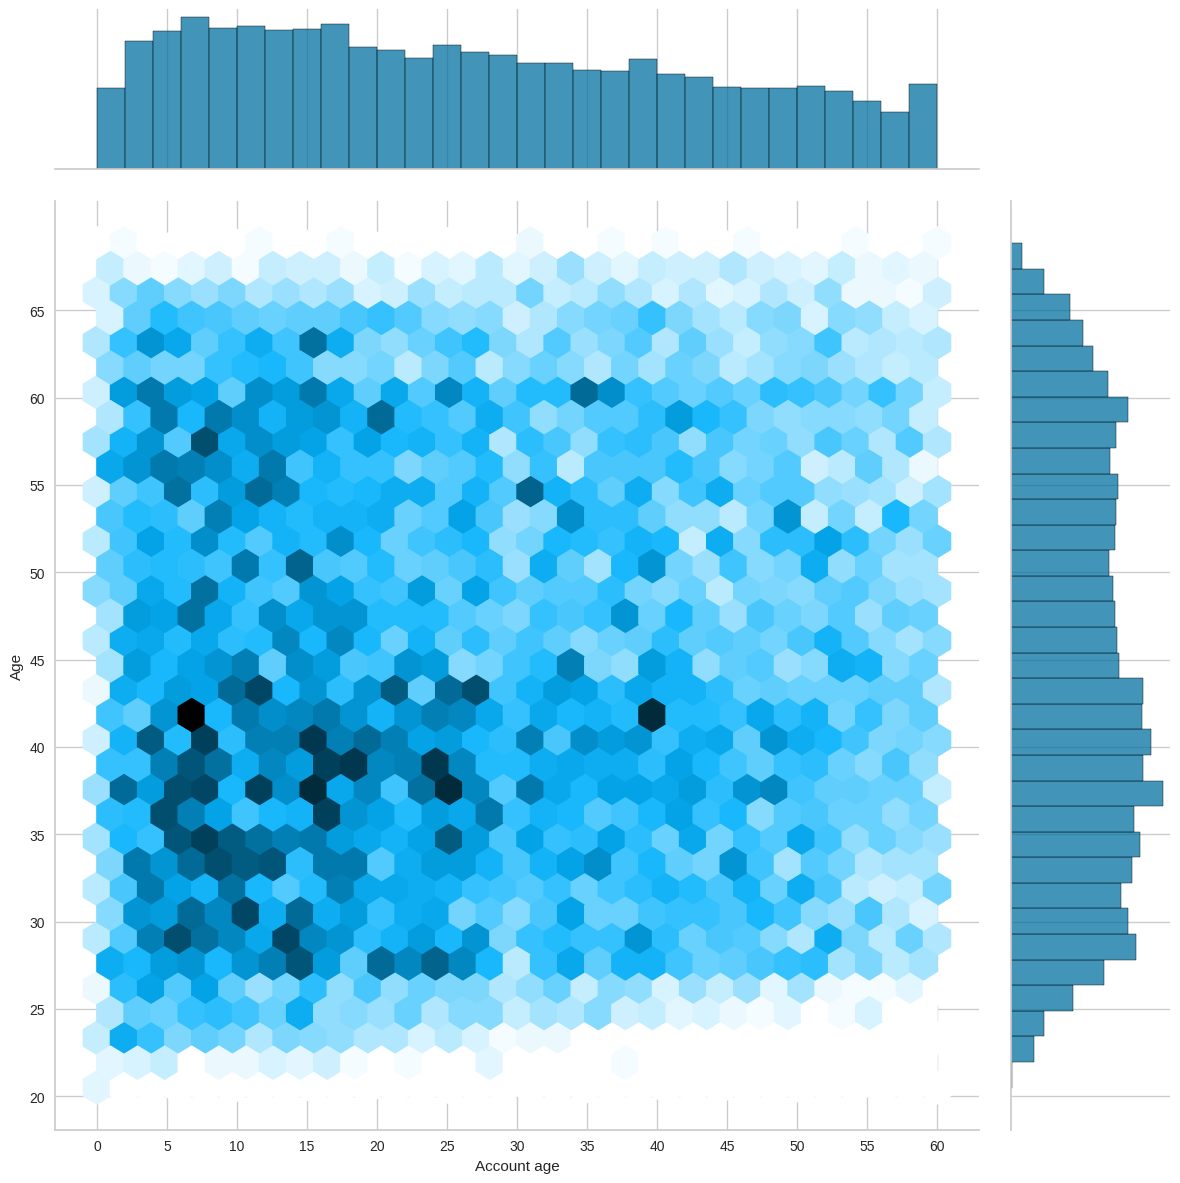

In [100]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

y_age = np.abs(cc_train_copy['Age']) / 365.25
sns.jointplot(x=np.abs(cc_train_copy['Account age']), y=y_age, kind="hex", height=12)
plt.yticks(np.arange(20, y_age.max(), 5))
plt.xticks(np.arange(0, 65, 5))
plt.ylabel('Age')
plt.show()


Interpretation:
- Most of the applicants are between 20 and 45 years old and have an account that is less than 25 months old.

##### 2.4.1.1.3 Employment length vs age (numerical vs numerical feature comparison)

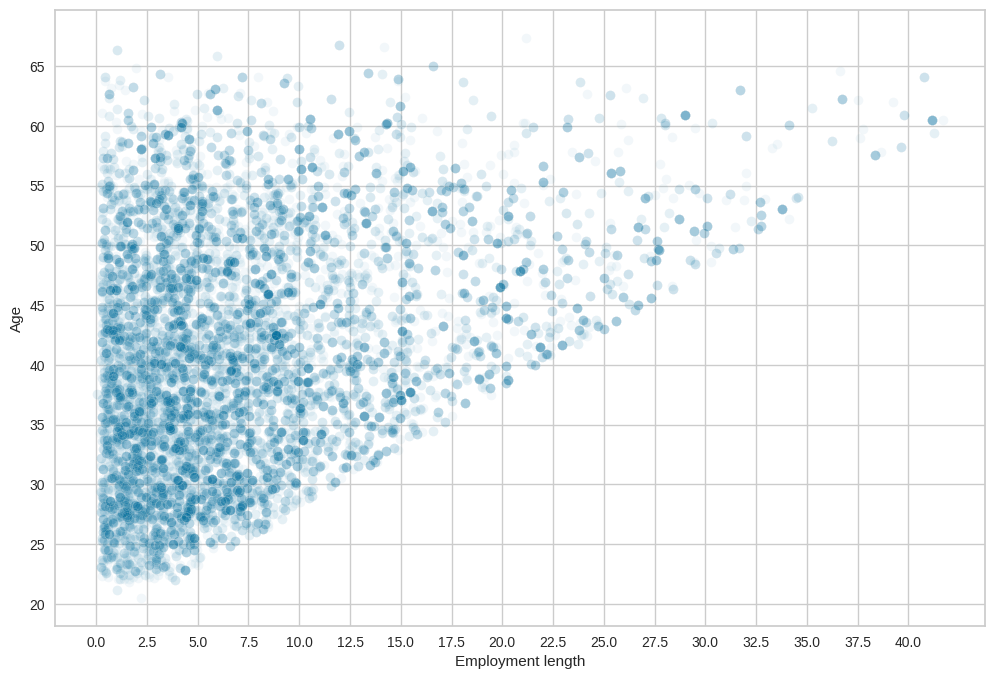

In [101]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

x_employ_length = np.abs(cc_train_copy[cc_train_copy['Employment length'] < 0]['Employment length']) / 365.25
y_age = np.abs(cc_train_copy['Age']) / 365.25

fig, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(x=x_employ_length, y=y_age, alpha=0.05)

# Change the frequency of the x-axis and y-axis labels
plt.xticks(np.arange(0, x_employ_length.max(), 2.5))
plt.yticks(np.arange(20, y_age.max(), 5))

plt.show()


Interpretation:
- This scatterplot shows that the age of the applicants is correlated with the length of the employment.
The reason why it is shaped like a reversed triangle, it is because the age of the applicants increase with the length of the employment. You can't have an employment length > than the age.

#### 2.4.1.2 Correlation analysis

In [102]:
# change the datatype of target feature to int
is_high_risk_int = cc_train_copy['Is high risk'].astype('int32')

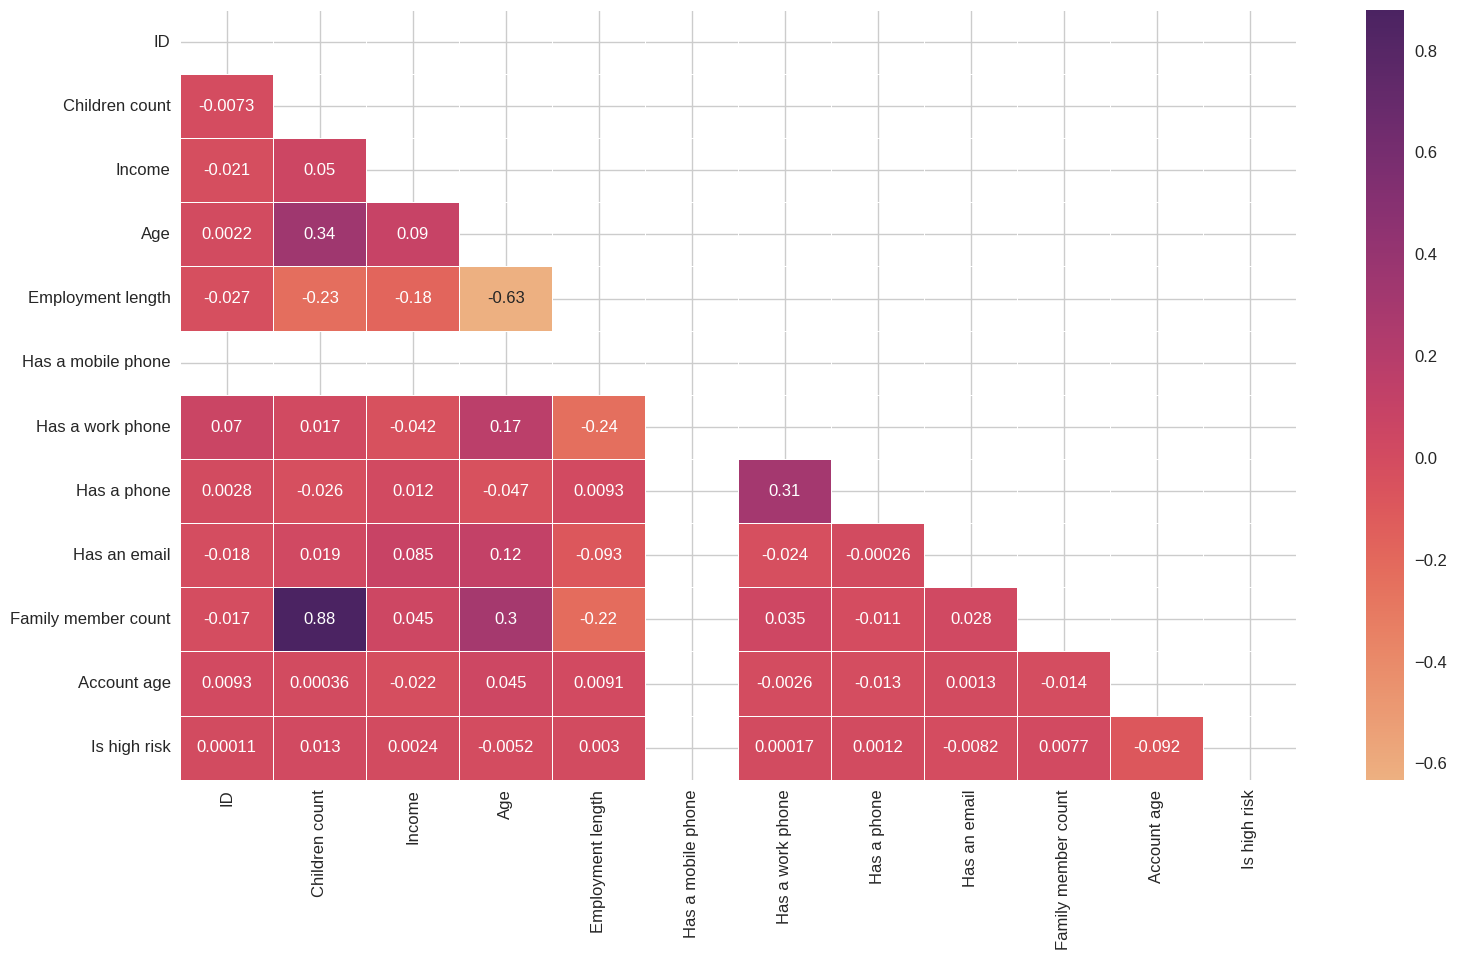

In [153]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Exclude non-numeric columns before correlation analysis
numeric_columns = cc_train_copy.select_dtypes(include=[np.number]).columns
cc_train_copy_corr_no_mobile = cc_train_copy[numeric_columns].corr()

# Get the lower triangle of the correlation matrix
mask = np.zeros_like(cc_train_copy_corr_no_mobile, dtype='bool')
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(18, 10))

# Seaborn heatmap
sns.heatmap(cc_train_copy_corr_no_mobile, annot=True, cmap='flare', mask=mask, linewidths=.5)

# Show the heatmap
plt.show()



Interpretation:
- There is no feature that is correlated with the target feature
- Family member count is highly correlated with children count as previously discussed
- Age has some positive correlation with the family member count and children count. The older a person is, the most likely he/she will have a larger family.
- Another positive correlation is having a phone and having a work phone.
- The final positive correlation is between the age and work phone. The younger someone is the less likely he/she will have a work phone.
- We also have a negative correlation between the employment length and the age as previously seen.

### 2.4.2 Numerical vs categorical features (ANOVA)

#### 2.4.2.1 Age vs the rest of categorical features

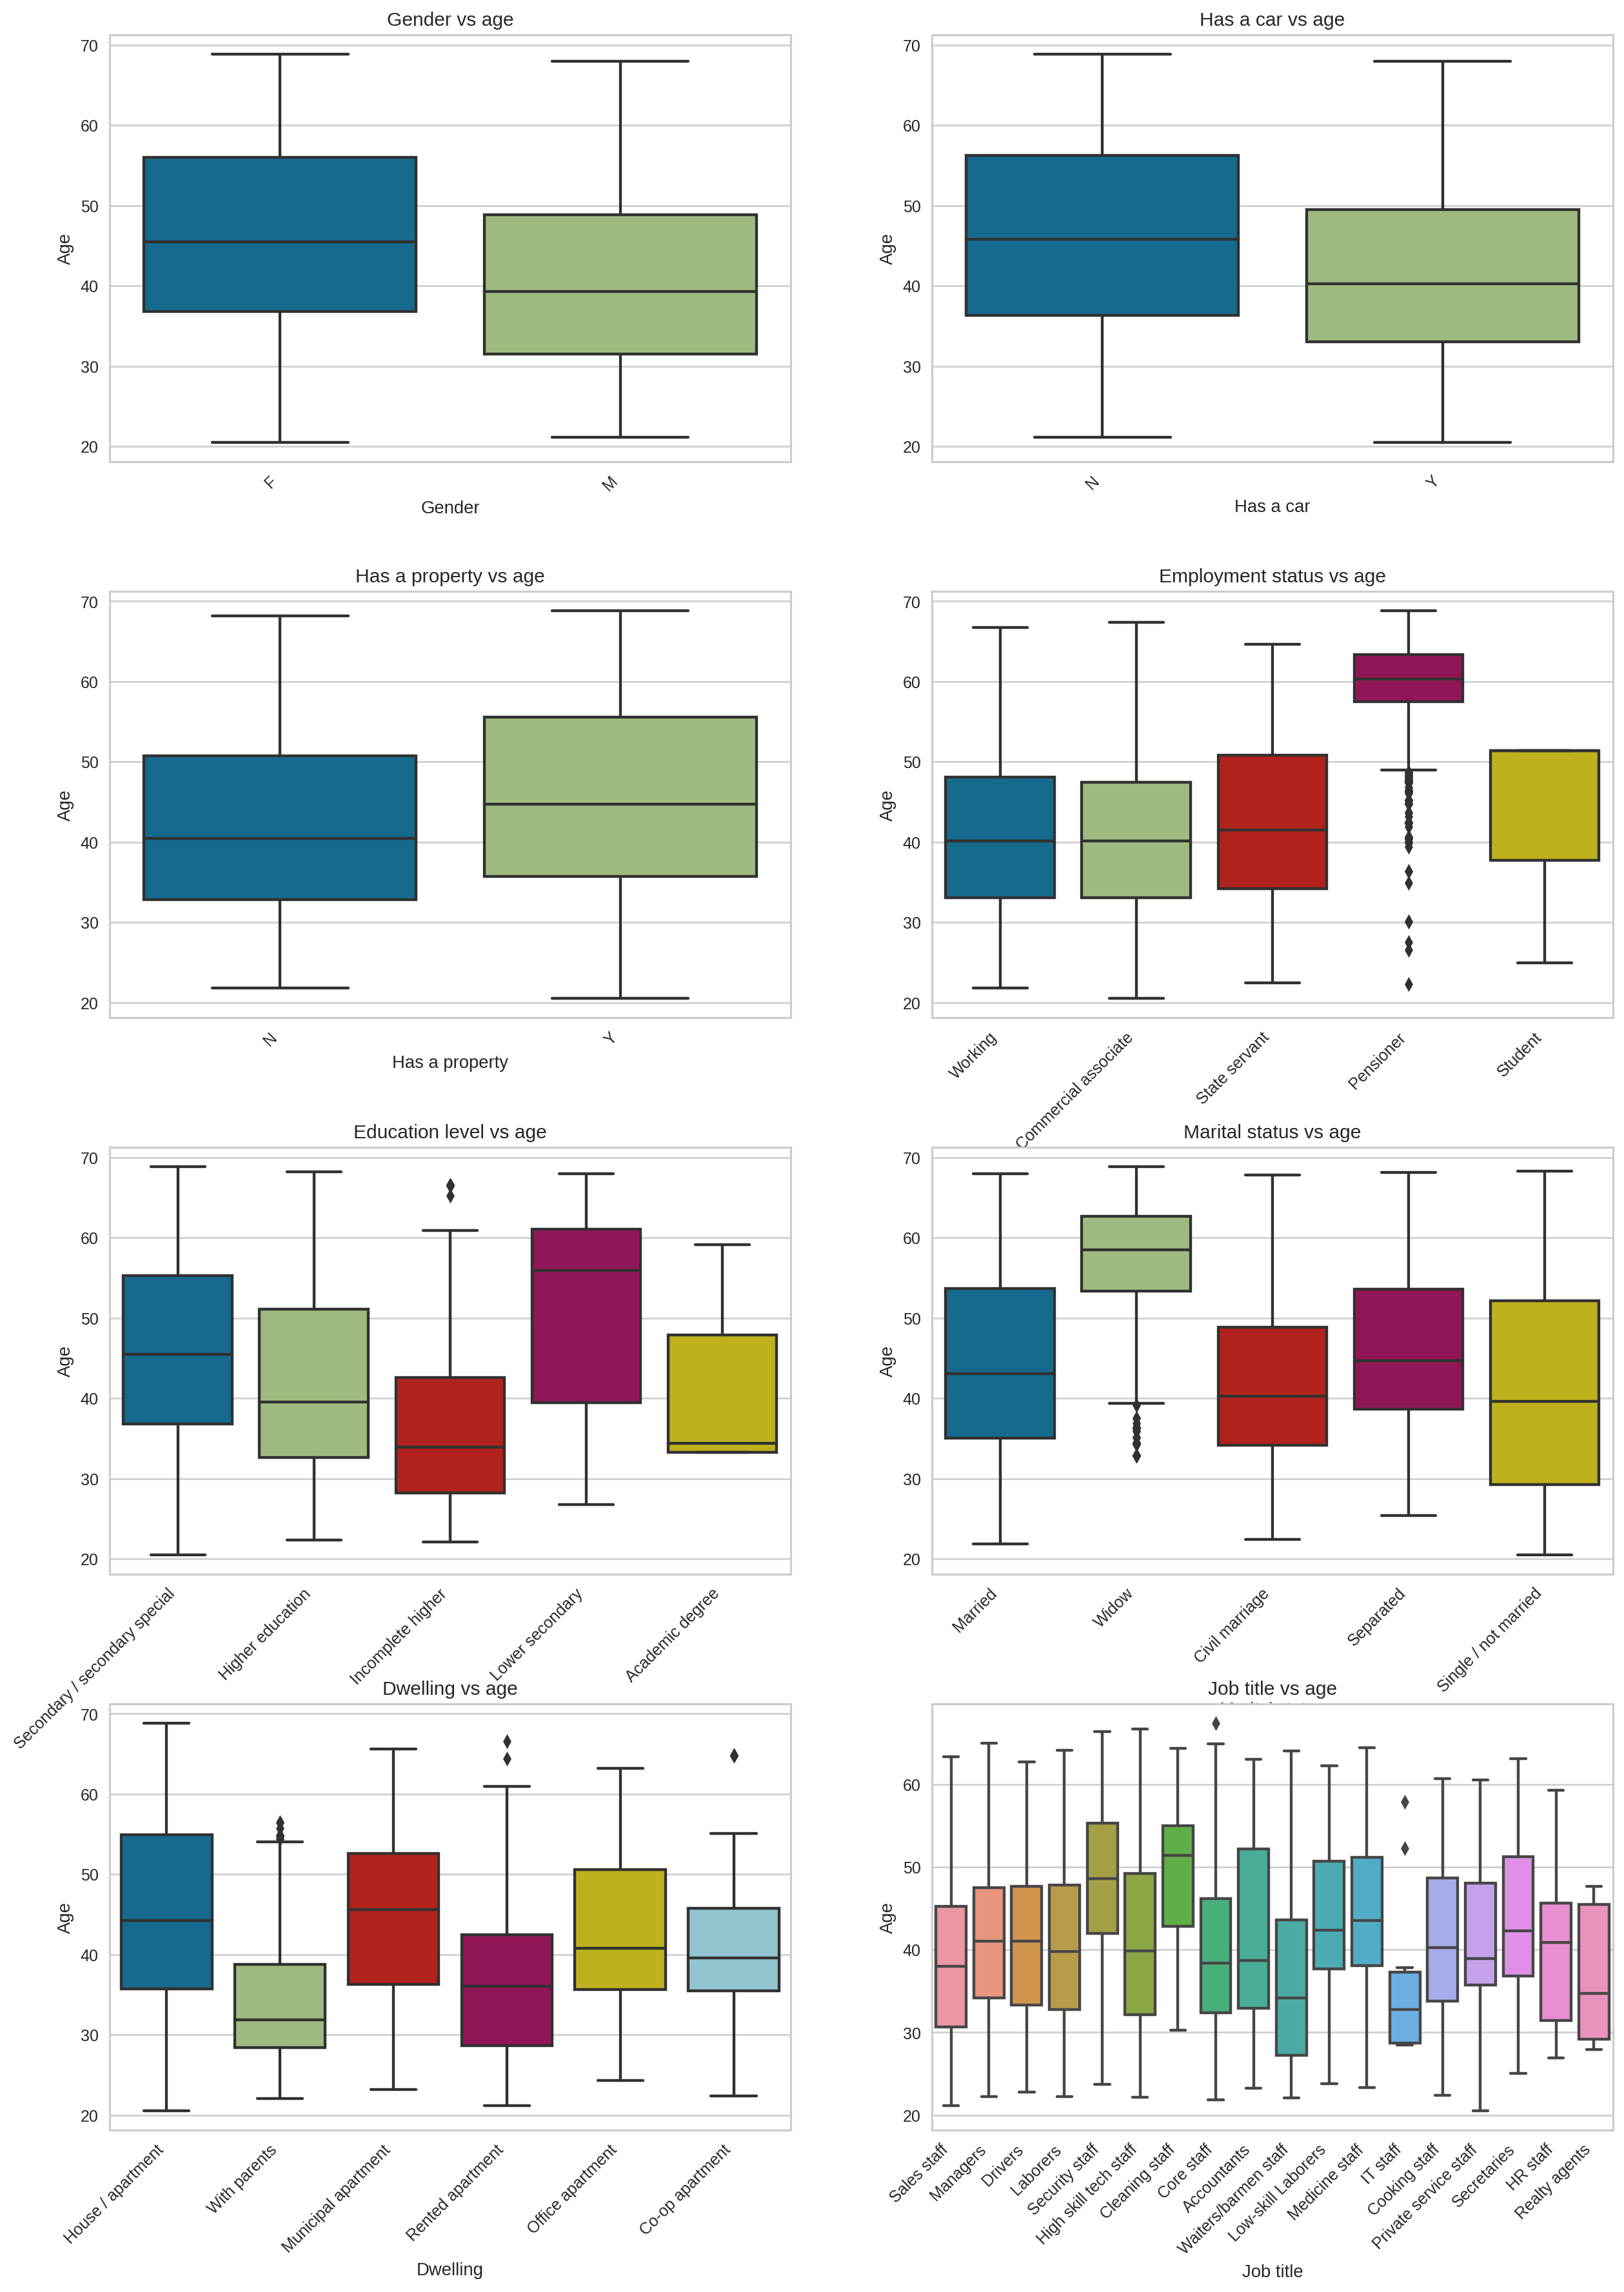

In [104]:
fig, axes = plt.subplots(4,2,figsize=(15,20),dpi=180)
fig.tight_layout(pad=5.0)
cat_features = ['Gender', 'Has a car', 'Has a property', 'Employment status', 'Education level', 'Marital status', 'Dwelling', 'Job title']
for cat_ft_count, ax in enumerate(axes):
    for row_count in range(4):
        for feat_count in range(2):
            sns.boxplot(ax=axes[row_count,feat_count],x=cc_train_copy[cat_features[cat_ft_count]],y=np.abs(cc_train_copy['Age'])/365.25)
            axes[row_count,feat_count].set_title(cat_features[cat_ft_count] + " vs age")
            plt.sca(axes[row_count,feat_count])
            plt.xticks(rotation=45,ha='right')
            plt.ylabel('Age')
            cat_ft_count += 1
    break

Interpretation:
- Female applicants are older than their male counterpart.
- Those who don't own a car tend to be older.
- Those who own a property tend to be older than those who don't.
- Of course, the pensioners are older that those who are working (We also see that some have pensioned at a young age, those are outliers).
- It is also interesting to see that those who hold an academic degree are younger in general than the other groups.
- Obviously, the widows tend to be much older. We also see some outliers in their 30's as well.
- With no surprise, those who live with parent tend to be younger. We also see some outlier as well.
- Lastly, who work as cleaning staff tend to be older while those who work in IT tend to be younger.

#### 2.4.2.2 Income vs the rest of categorical features

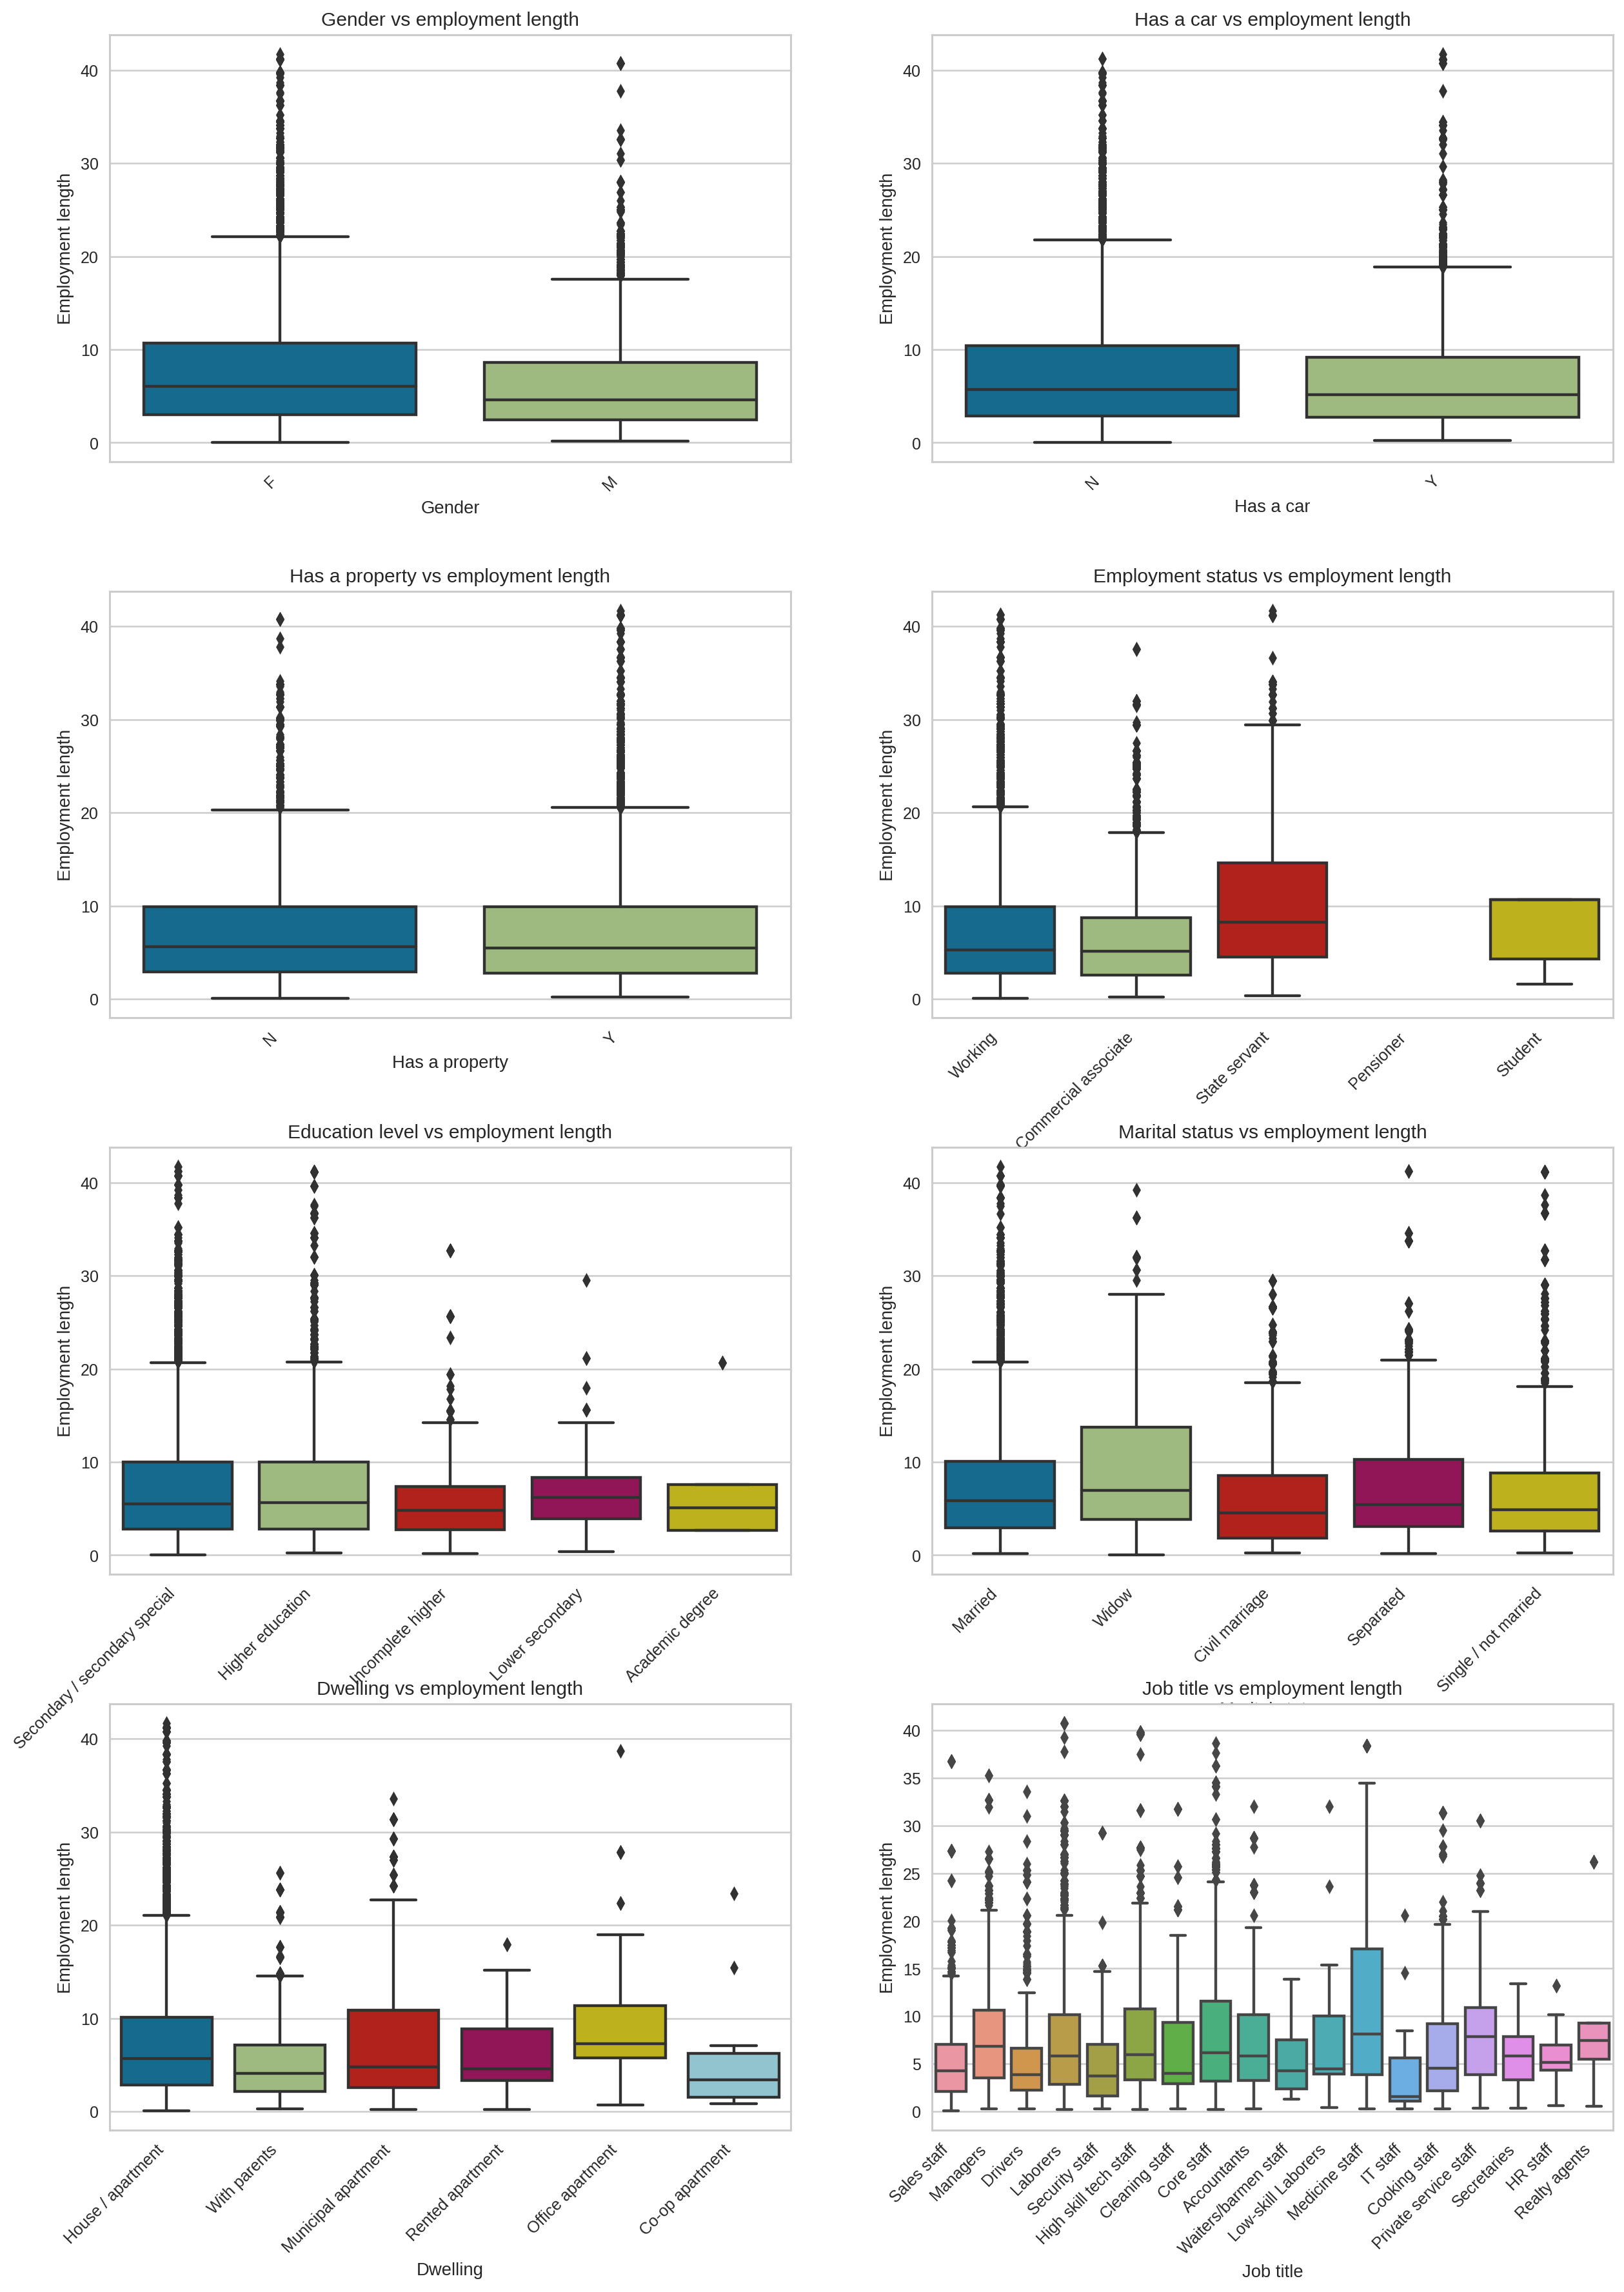

In [105]:
fig, axes = plt.subplots(4,2,figsize=(15,20),dpi=180)
fig.tight_layout(pad=5.0)

for cat_ft_count, ax in enumerate(axes):
    for row_count in range(4):
        for feat_count in range(2):
            sns.boxplot(ax=axes[row_count,feat_count],x=cc_train_copy[cat_features[cat_ft_count]],y=np.abs(cc_train_copy[cc_train_copy['Employment length'] < 0]['Employment length'])/365.25)
            axes[row_count,feat_count].set_title(cat_features[cat_ft_count] + " vs employment length")
            plt.sca(axes[row_count,feat_count])
            plt.ylabel('Employment length')
            plt.xticks(rotation=45,ha='right')
            cat_ft_count += 1
    break

Interpretation:
- State employed applicant tend to have been employed longer than the rest.
- Those who work in the medical field, have been employed longer than the rest.

### 2.4.3 Categorical vs categorical features (Chi-square test)

Null hypothesis: the feature's categories have no effect on the target variable.
Alternate hypothesis: one(or more) of the feature categories has a significant effect on the target variable.

In [106]:
def chi_func(feature):
    # selection row with high risk
    high_risk_ft = cc_train_copy[cc_train_copy['Is high risk'] == 1][feature]
    high_risk_ft_ct = pd.crosstab(index=high_risk_ft, columns=['Count']).rename_axis(None, axis=1)
    # drop the index feature name
    high_risk_ft_ct.index.name = None
    # observe values
    obs = high_risk_ft_ct
    print('Observed values:\n')
    print(obs)
    print('\n')
    # expected values
    print(obs.index)
    exp = pd.DataFrame([obs['Count'].sum()/len(obs)] * len(obs.index),columns=['Count'], index=obs.index)
    print('Expected values:\n')
    print(exp)
    print('\n')
    # chi-square test
    chi_squared_stat = (((obs-exp)**2)/exp).sum()
    print('Chi-square:\n')
    print(chi_squared_stat[0])
    print('\n')
    #critical value
    crit = stats.chi2.ppf(q = 0.95, df = len(obs) - 1)
    print('Critical value:\n')
    print(crit)
    print('\n')
    # p-value
    p_value = 1 - stats.chi2.cdf(x = chi_squared_stat, df = len(obs) - 1)
    print('P-value:\n')
    print(p_value)
    print('\n')
    if chi_squared_stat[0] >= crit:
        print('Reject the null hypothesis')
    elif chi_squared_stat[0] <= crit:
        print('Fail to reject the null hypothesis')

In [107]:
cat_ft = ['Gender', 'Has a car', 'Has a property', 'Employment status', 'Education level', 'Marital status', 'Dwelling', 'Job title']
for ft in cat_ft:
    print('\n\n**** {} ****\n'.format(ft))
    chi_func(ft)



**** Gender ****

Observed values:

   Count
F     91
M     27


Index(['F', 'M'], dtype='object')
Expected values:

   Count
F  59.00
M  59.00


Chi-square:

34.71186440677966


Critical value:

3.841458820694124


P-value:

[3.82294596e-09]


Reject the null hypothesis


**** Has a car ****

Observed values:

   Count
N     71
Y     47


Index(['N', 'Y'], dtype='object')
Expected values:

   Count
N  59.00
Y  59.00


Chi-square:

4.88135593220339


Critical value:

3.841458820694124


P-value:

[0.02714828]


Reject the null hypothesis


**** Has a property ****

Observed values:

   Count
N     39
Y     79


Index(['N', 'Y'], dtype='object')
Expected values:

   Count
N  59.00
Y  59.00


Chi-square:

13.559322033898304


Critical value:

3.841458820694124


P-value:

[0.00023114]


Reject the null hypothesis


**** Employment status ****

Observed values:

                      Count
Commercial associate     30
Pensioner                23
State servant             8
Working       

<ipython-input-106-b0fc2b77ab4e>:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(chi_squared_stat[0])
<ipython-input-106-b0fc2b77ab4e>:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if chi_squared_stat[0] >= crit:
<ipython-input-106-b0fc2b77ab4e>:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(chi_squared_stat[0])
<ipython-input-106-b0fc2b77ab4e>:33: FutureWarning: Series.__getitem__ treating keys as positions is 

## 2.5 Business findings from the EDA

- ***Typical profile of an applicant is: a Female in her early 40’s, married with a partner and no child. She has been employed for 5 years with a salary of 157500. She has completed her secondary education. She does not own a car but owns a property (a house/ apartment). Her account is 26 months old.***
- ***Age and income do not have any effects on the target variable***
- ***Those who are flagged as bad client, tend to have a shorter employment length and older accounts. They also constitute less than 2% of total applicants.***
- ***Most applicants are 20 to 45 years old and have an account that is 25 months old or less.***

# 3. Prepare the data

## 3.1 Transform to be done on each feature

ID:
* Drop the feature

Gender:
* One hot encoding

Age:
* Min-max scaling
* Fix skewness
* Abs value and div 365.25

Marital status:
* One hot encoding

Family member count
* Fix outliers

Children count
* Fix outliers
* Drop feature

Dwelling type
* One hot encoding

Income
* Remove outliers
* Fix skewness
* Min-max scaling

Job title
* One hot encoding
* Impute missing values

Employment status:
* One hot encoding

Education level:
* Ordinal encoding

Employment length:
* Remove outliers
* Min-max scaling
* Abs value and div 365.25
* change days of employments of retirees to 0

Has a car:
* Change it numerical
* One-hot encoding

Has a property:
* Change it numerical
* One-hot encoding

Has a mobile phone:
* Drop feature

Has a work phone:
* One-hot encoding

Has a phone:
* One-hot encoding

Has an email:
* One-hot encoding

Account age:
* Drop feature

Is high risk(Target):
* Change the data type to numerical
* balance the data with SMOTE

## 3.2 Data Cleaning

### 3.2.1 Outliers handling

In [108]:
class OutlierRemover(BaseEstimator, TransformerMixin):
    def __init__(self,feat_with_outliers = ['Family member count','Income', 'Employment length']):
        self.feat_with_outliers = feat_with_outliers
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.feat_with_outliers).issubset(df.columns)):
            # 25% quantile
            Q1 = df[self.feat_with_outliers].quantile(.25)
            # 75% quantile
            Q3 = df[self.feat_with_outliers].quantile(.75)
            IQR = Q3 - Q1
            # keep the data within 3 IQR
            df = df[~((df[self.feat_with_outliers] < (Q1 - 3 * IQR)) |(df[self.feat_with_outliers] > (Q3 + 3 * IQR))).any(axis=1)]
            return df
        else:
            print("One or more features are not in the dataframe")
            return df

## 3.3 Feature selection

### 3.3.1 Drop features

In [109]:
class DropFeatures(BaseEstimator,TransformerMixin):
    def __init__(self,feature_to_drop = ['ID','Has a mobile phone','Children count','Job title','Account age']):
        self.feature_to_drop = feature_to_drop
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.feature_to_drop).issubset(df.columns)):
            df.drop(self.feature_to_drop,axis=1,inplace=True)
            return df
        else:
            print("One or more features are not in the dataframe")
            return df

Why are we droping these features?
- ID: ID is not useful for prediction, it helped us when we were merging the two datasets but after that, there is no need to keep it.
- Has a mobile phone: Since everyone has a mobile phone, this feature does not inform us about anything.
- Children count: is highly correlated with Family member count, and to avoid multicollinearity, we drop it.
- Job title: Has some missing values and the count of each category is not very different to justify the use of mode. So we drop it.
- Account age: Because account was used to create the target, reusing will make our model to overfit. Plus, this information is unknown while applying for a credit card.

## 3.4 Feature engineering

### 3.4.1 Time conversion


In [110]:
class TimeConversionHandler(BaseEstimator, TransformerMixin):
    def __init__(self, feat_with_days = ['Employment length', 'Age']):
        self.feat_with_days = feat_with_days
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        if (set(self.feat_with_days).issubset(X.columns)):
            # convert days to absolute value
            X[['Employment length','Age']] = np.abs(X[['Employment length','Age']])
            return X
        else:
            print("One or more features are not in the dataframe")
            return X

### 3.4.2 Retiree handling (in the employment length feature)

In [111]:
class RetireeHandler(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, df):
        return self
    def transform(self, df):
        if 'Employment length' in df.columns:
            # select rows with employment length is 365243 which corresponds to retirees
            df_ret_idx = df['Employment length'][df['Employment length'] == 365243].index
            # change 365243 to 0
            df.loc[df_ret_idx,'Employment length'] = 0
            return df
        else:
            print("Employment length is not in the dataframe")
            return df

### 3.4.3 Skewness handling

In [112]:
class SkewnessHandler(BaseEstimator, TransformerMixin):
    def __init__(self,feat_with_skewness=['Income','Age']):
        self.feat_with_skewness = feat_with_skewness
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.feat_with_skewness).issubset(df.columns)):
            # Handle skewness with cubic root transformation
            df[self.feat_with_skewness] = np.cbrt(df[self.feat_with_skewness])
            return df
        else:
            print("One or more features are not in the dataframe")
            return df

### 3.4.4 Binning

In [113]:
class BinningNumToYN(BaseEstimator, TransformerMixin):
    def __init__(self,feat_with_num_enc=['Has a work phone','Has a phone','Has an email']):
        self.feat_with_num_enc = feat_with_num_enc
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.feat_with_num_enc).issubset(df.columns)):
            # Change 0 to N and 1 to Y for all the features in feat_with_num_enc
            for ft in self.feat_with_num_enc:
                df[ft] = df[ft].map({1:'Y',0:'N'})
            return df
        else:
            print("One or more features are not in the dataframe")
            return df

### 3.4.5 One hot encoding (with feature's name)

In [114]:
class OneHotWithFeatNames(BaseEstimator,TransformerMixin):
    def __init__(self,one_hot_enc_ft = ['Gender', 'Marital status', 'Dwelling', 'Employment status', 'Has a car', 'Has a property', 'Has a work phone', 'Has a phone', 'Has an email']):
        self.one_hot_enc_ft = one_hot_enc_ft
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.one_hot_enc_ft).issubset(df.columns)):
            # function to one hot encode the features in one_hot_enc_ft
            def one_hot_enc(df,one_hot_enc_ft):
                one_hot_enc = OneHotEncoder()
                one_hot_enc.fit(df[one_hot_enc_ft])
                # get the result of the one hot encoding columns names
                feat_names_one_hot_enc = one_hot_enc.get_feature_names_out(one_hot_enc_ft)
                # change the array of the one hot encoding to a dataframe with the column names
                df = pd.DataFrame(one_hot_enc.transform(df[self.one_hot_enc_ft]).toarray(),columns=feat_names_one_hot_enc,index=df.index)
                return df
            # function to concatenat the one hot encoded features with the rest of features that were not encoded
            def concat_with_rest(df,one_hot_enc_df,one_hot_enc_ft):
                # get the rest of the features
                rest_of_features = [ft for ft in df.columns if ft not in one_hot_enc_ft]
                # concatenate the rest of the features with the one hot encoded features
                df_concat = pd.concat([one_hot_enc_df, df[rest_of_features]],axis=1)
                return df_concat
            # one hot encoded dataframe
            one_hot_enc_df = one_hot_enc(df,self.one_hot_enc_ft)
            # returns the concatenated dataframe
            full_df_one_hot_enc = concat_with_rest(df,one_hot_enc_df,self.one_hot_enc_ft)
            return full_df_one_hot_enc
        else:
            print("One or more features are not in the dataframe")
            return df

### 3.4.6 Ordinal encoding (with feature's names)

In [115]:
class OrdinalFeatNames(BaseEstimator,TransformerMixin):
    def __init__(self,ordinal_enc_ft = ['Education level']):
        self.ordinal_enc_ft = ordinal_enc_ft
    def fit(self,df):
        return self
    def transform(self,df):
        if 'Education level' in df.columns:
            ordinal_enc = OrdinalEncoder()
            df[self.ordinal_enc_ft] = ordinal_enc.fit_transform(df[self.ordinal_enc_ft])
            return df
        else:
            print("Education level is not in the dataframe")
            return df

### 3.4.7 Min-Max scaling (with feature's names)

In [116]:
class MinMaxWithFeatNames(BaseEstimator,TransformerMixin):
    def __init__(self,min_max_scaler_ft = ['Age', 'Income', 'Employment length']):
        self.min_max_scaler_ft = min_max_scaler_ft
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.min_max_scaler_ft).issubset(df.columns)):
            min_max_enc = MinMaxScaler()
            df[self.min_max_scaler_ft] = min_max_enc.fit_transform(df[self.min_max_scaler_ft])
            return df
        else:
            print("One or more features are not in the dataframe")
            return df

### 3.4.8 Change the data types of the target feature

In [117]:
class ChangeToNumTarget(BaseEstimator,TransformerMixin):
    def __init__(self):
        pass
    def fit(self,df):
        return self
    def transform(self,df):
        if 'Is high risk' in df.columns:
            df['Is high risk'] = pd.to_numeric(df['Is high risk'])
            return df
        else:
            print("Is high risk is not in the dataframe")
            return df

### 3.4.9 Oversampling

In [118]:
class Oversample(BaseEstimator,TransformerMixin):
    def __init__(self):
        pass
    def fit(self,df):
        return self
    def transform(self,df):
        if 'Is high risk' in df.columns:
            # smote function to oversample the minority class to fix the imbalance data
            oversample = SMOTE(sampling_strategy='minority')
            X_bal, y_bal = oversample.fit_resample(df.loc[:, df.columns != 'Is high risk'],df['Is high risk'])
            df_bal = pd.concat([pd.DataFrame(X_bal),pd.DataFrame(y_bal)],axis=1)
            return df_bal
        else:
            print("Is high risk is not in the dataframe")
            return df

We are oversampling with SMOTE because the minority class (Is high risk = 1) is very rare in the data.

## 3.5 Data Preprocessing

In [119]:
def full_pipeline(df):
    # Create the pipeline that will call all the class from OutlierRemoval to OversampleSMOTE in one go
    pipeline = Pipeline([
        ('outlier_remover', OutlierRemover()),
        ('feature_dropper', DropFeatures()),
        ('time_conversion_handler', TimeConversionHandler()),
        ('retiree_handler', RetireeHandler()),
        ('skewness_handler', SkewnessHandler()),
        ('binning_num_to_yn', BinningNumToYN()),
        ('one_hot_with_feat_names', OneHotWithFeatNames()),
        ('ordinal_feat_names', OrdinalFeatNames()),
        ('min_max_with_feat_names', MinMaxWithFeatNames()),
        ('change_to_num_target', ChangeToNumTarget()),
        ('oversample', Oversample())
    ])
    df_pipe_prep = pipeline.fit_transform(df)
    return df_pipe_prep

In [120]:
pd.options.mode.chained_assignment = None  # Hide the copy warning
cc_train_prep = full_pipeline(cc_train_copy)

In [121]:
cc_train_prep.shape

(29716, 33)

In [122]:
pd.set_option('display.max_columns', None)
cc_train_prep.head()

Gender_F  Gender_M  Marital status_Civil marriage  Marital status_Married  \
0      1.00      0.00                           0.00                    1.00   
1      1.00      0.00                           0.00                    0.00   
2      0.00      1.00                           0.00                    1.00   
3      1.00      0.00                           0.00                    1.00   
4      0.00      1.00                           1.00                    0.00   

   Marital status_Separated  Marital status_Single / not married  \
0                      0.00                                 0.00   
1                      0.00                                 0.00   
2                      0.00                                 0.00   
3                      0.00                                 0.00   
4                      0.00                                 0.00   

   Marital status_Widow  Dwelling_Co-op apartment  Dwelling_House / apartment  \
0                  0.00                      0.00                        1.00   
1                  1.00                      0.00                        1.00   
2                  0.00                      0.00                        1.00   
3                  0.00                      0.00                        1.00   
4                  0.00                      0.00                        1.00   

   Dwelling_Municipal apartment  Dwelling_Office apartment  \
0                          0.00                       0.00   
1                          0.00                       0.00   
2                          0.00                       0.00   
3                          0.00                       0.00   
4                          0.00                       0.00   

   Dwelling_Rented apartment  Dwelling_With parents  \
0                       0.00                   0.00   
1                       0.00                   0.00   
2                       0.00                   0.00   
3                       0.00                   0.00   
4                       0.00                   0.00   

   Employment status_Commercial associate  Employment status_State servant  \
0                                    0.00                             0.00   
1                                    1.00                             0.00   
2                                    1.00                             0.00   
3                                    0.00                             0.00   
4                                    0.00                             0.00   

   Employment status_Student  Employment status_Working  Has a car_N  \
0                       0.00                       1.00         1.00   
1                       0.00                       0.00         1.00   
2                       0.00                       0.00         0.00   
3                       0.00                       1.00         1.00   
4                       0.00                       1.00         1.00   

   Has a car_Y  Has a property_N  Has a property_Y  Has a work phone_N  \
0         0.00              1.00              0.00                1.00   
1         0.00              1.00              0.00                1.00   
2         1.00              0.00              1.00                1.00   
3         0.00              1.00              0.00                1.00   
4         0.00              0.00              1.00                1.00   

   Has a work phone_Y  Has a phone_N  Has a phone_Y  Has an email_N  \
0                0.00           1.00           0.00            1.00   
1                0.00           0.00           1.00            1.00   
2                0.00           1.00           0.00            1.00   
3                0.00           0.00           1.00            1.00   
4                0.00           1.00           0.00            1.00   

   Has an email_Y  Income  Education level  Age  Employment length  \
0            0.00    0.31             4.00 0.33               0.10   
1       

In [123]:
# split the train data into X and y (target)
X_cc_train_prep, y_cc_train_prep = cc_train_prep.loc[:, cc_train_prep.columns != 'Is high risk'], cc_train_prep['Is high risk'].astype('int64')

# 4. Short-list promising models

## 4.1 Models training

In [129]:
classifiers = {
    'sgd':SGDClassifier(random_state=42,loss='perceptron'),
    'logistic_regression':LogisticRegression(random_state=42,max_iter=1000),

    'decision_tree':DecisionTreeClassifier(random_state=42),
    'random_forest':RandomForestClassifier(random_state=42),
    'gaussian_naive_bayes':GaussianNB(),
    'k_nearest_neighbors':KNeighborsClassifier(),
    'gradient_boosting':GradientBoostingClassifier(random_state=42),
    'linear_discriminant_analysis':LinearDiscriminantAnalysis(),
    'bagging':BaggingClassifier(random_state=42),
    'neural_network':MLPClassifier(random_state=42,max_iter=1000),
    'adaboost':AdaBoostClassifier(random_state=42),
    'extra_trees':ExtraTreesClassifier(random_state=42),
    }

In [130]:
# Function to get the feature importance of the classifier, and plot it
def feat_importance_plot(model_trn, model_name):
    if model_name not in ['sgd','gaussian_naive_bayes','k_nearest_neighbors','bagging','neural_network']:
        # change xtick font size
        plt.rcParams['xtick.labelsize'] = 12
        plt.rcParams['ytick.labelsize'] = 12
        # top 10 most predictive features
        top_10_feat = FeatureImportances(model_trn, relative=False, topn=10)
        # top 10 least predictive features
        bottom_10_feat = FeatureImportances(model_trn, relative=False, topn=-10)
        #change the figure size
        plt.figure(figsize=(10, 4))
        #change x label font size
        plt.xlabel('xlabel', fontsize=14)
        # Fit to get the feature importances
        top_10_feat.fit(X_cc_train_prep, y_cc_train_prep)
        # show the plot
        top_10_feat.show()
        print('\n')
        plt.figure(figsize=(10, 4))
        plt.xlabel('xlabel', fontsize=14)
        # Fit to get the feature importances
        bottom_10_feat.fit(X_cc_train_prep, y_cc_train_prep)
        # show the plot
        bottom_10_feat.show()
        print('\n')
    else:
        print('No feature importance for {0}'.format(model_name))
        print('\n')

In [131]:
# Function to get the y prediction
def y_prediction_func(model_trn,model_name,final_model=False):
    if final_model == False:
        # check if y_train_copy_pred exists, if not create it
        y_cc_train_pred_path = Path('saved_models/{0}/y_train_copy_pred_{0}.sav'.format(model_name))
        try:
            y_cc_train_pred_path.resolve(strict=True)
        except FileNotFoundError:
            #cross validation prediction with kfold = 10
            y_cc_train_pred = cross_val_predict(model_trn,X_cc_train_prep,y_cc_train_prep,cv=10,n_jobs=-1)
            #save the predictions
            joblib.dump(y_cc_train_pred,y_cc_train_pred_path)
            return y_cc_train_pred
        else:
            # if it exist load the predictions
            y_cc_train_pred = joblib.load(y_cc_train_pred_path)
            return y_cc_train_pred
    else:
        # check if y_train_copy_pred exists, if not create it
        y_cc_train_pred_path_final = Path('saved_models_final/{0}/y_train_copy_pred_{0}_final.sav'.format(model_name))
        try:
            y_cc_train_pred_path_final.resolve(strict=True)
        except FileNotFoundError:
            #cross validation prediction with kfold = 10
            y_cc_train_pred_final = cross_val_predict(model_trn,X_cc_train_prep,y_cc_train_prep,cv=10,n_jobs=-1)
            #save the predictions
            joblib.dump(y_cc_train_pred_final,y_cc_train_pred_path_final)
            return y_cc_train_pred_final
        else:
            # if it exist load the predictions
            y_cc_train_pred_final = joblib.load(y_cc_train_pred_path_final)
            return y_cc_train_pred_final

In [132]:
# Function to plot the confusion matrix
def confusion_matrix_func(model_trn,model_name,final_model=False):
    if final_model == False:
        fig, ax = plt.subplots(figsize=(8,8))
        #plot confusion matrix
        conf_matrix = ConfusionMatrixDisplay.from_predictions(y_cc_train_prep,y_prediction_func(model_trn,model_name),ax=ax, cmap='Blues',values_format='d')
        # remove the grid
        plt.grid(visible=None)
        # increase the font size of the x and y labels
        plt.xlabel('Predicted label', fontsize=14)
        plt.ylabel('True label', fontsize=14)
        #give a title to the plot using the model name
        plt.title('Confusion Matrix', fontsize=14)
        #show the plot
        plt.show()
        print('\n')
    else:
        fig, ax = plt.subplots(figsize=(8,8))
        #plot confusion matrix
        conf_matrix_final = ConfusionMatrixDisplay.from_predictions(y_cc_train_prep,y_prediction_func(model_trn,model_name,final_model=True),ax=ax, cmap='Blues',values_format='d')
        # remove the grid
        plt.grid(visible=None)
        # increase the font size of the x and y labels
        plt.xlabel('Predicted label', fontsize=14)
        plt.ylabel('True label', fontsize=14)
        #give a title to the plot using the model name
        plt.title('Confusion Matrix', fontsize=14)
        #show the plot
        plt.show()
        print('\n')

In [133]:
# Function to plot the roc curve
def roc_curve_func(model_trn,model_name,final_model=False):
    if final_model == False:
        # check if y probabilities file exists, if not create it
        y_proba_path = Path('saved_models/{0}/y_cc_train_proba_{0}.sav'.format(model_name))
        try:
            y_proba_path.resolve(strict=True)
        except FileNotFoundError:
            y_cc_train_proba = model_trn.predict_proba(X_cc_train_prep)
            joblib.dump(y_cc_train_proba,y_proba_path)
        else:
            # if path exist load the y probabilities file
            y_cc_train_proba = joblib.load(y_proba_path)
        skplt.metrics.plot_roc(y_cc_train_prep, y_cc_train_proba, title = 'ROC curve for {0}'.format(model_name), cmap='cool',figsize=(8,6), text_fontsize='large')
        #remove the grid
        plt.grid(visible=None)
        plt.show()
        print('\n')
    else:
        # check if y probabilities file exists, if not create it
        y_proba_path_final = Path('saved_models_final/{0}/y_cc_train_proba_{0}_final.sav'.format(model_name))
        try:
            y_proba_path_final.resolve(strict=True)
        except FileNotFoundError:
            y_cc_train_proba_final = model_trn.predict_proba(X_cc_train_prep)
            joblib.dump(y_cc_train_proba_final,y_proba_path_final)
        else:
            # if path exist load the y probabilities file
            y_cc_train_proba_final = joblib.load(y_proba_path_final)
        skplt.metrics.plot_roc(y_cc_train_prep, y_cc_train_proba_final, title = 'ROC curve for {0}'.format(model_name), cmap='cool',figsize=(8,6), text_fontsize='large')
        #remove the grid
        plt.grid(visible=None)
        plt.show()
        print('\n')

In [134]:
# Function to display the classification report
def score_func(model_trn, model_name, final_model=False):
    if final_model == False:
        class_report = classification_report(y_cc_train_prep,y_prediction_func(model_trn,model_name))
        print(class_report)
    else:
        class_report_final = classification_report(y_cc_train_prep,y_prediction_func(model_trn,model_name,final_model=True))
        print(class_report_final)

In [135]:
# Function to train the model
def train_model(model,model_name,final_model=False):
    # if we are not training the final model
    if final_model == False:
        # check if the model file exist and if not create, train and save it
        model_file_path = Path('saved_models/{0}/{0}_model.sav'.format(model_name))
        try:
            model_file_path.resolve(strict=True)
        except FileNotFoundError:
            if model_name == 'sgd':
                # for sgd, loss = 'hinge' does not have a predict_proba method. Therefore, we use a calibrated model
                calibrated_model = CalibratedClassifierCV(model, cv=10, method='sigmoid')
                model_trn = calibrated_model.fit(X_cc_train_prep,y_cc_train_prep)
            else:
                model_trn = model.fit(X_cc_train_prep,y_cc_train_prep)
            joblib.dump(model_trn,model_file_path)
            # plot the most and least predictive features
            return model_trn
        else:
            # if path exist load the model
            model_trn = joblib.load(model_file_path)
            # plot the most and least predictive features
            return model_trn
    else:
        # check if the final model file exist and if not create, train and save it
        final_model_file_path = Path('saved_models_final/{0}/{0}_model.sav'.format(model_name))
        try:
            final_model_file_path.resolve(strict=True)
        except FileNotFoundError:
            model_trn = model.fit(X_cc_train_prep,y_cc_train_prep)
            joblib.dump(model_trn,final_model_file_path)
            # plot the most and least predictive features
            return model_trn
        else:
            # if path exist load the model
            model_trn = joblib.load(final_model_file_path)
            # plot the most and least predictive features
            return model_trn

In [136]:
def folder_check_model():
    # check if the folder for saving the model exists, if not create it
    if not os.path.exists('saved_models/{}'.format(model_name)):
        os.makedirs('saved_models/{}'.format(model_name))





----------------------  sgd  ----------------------


              precision    recall  f1-score   support

           0       0.65      0.57      0.61     14858
           1       0.62      0.70      0.66     14858

    accuracy                           0.63     29716
   macro avg       0.64      0.63      0.63     29716
weighted avg       0.64      0.63      0.63     29716



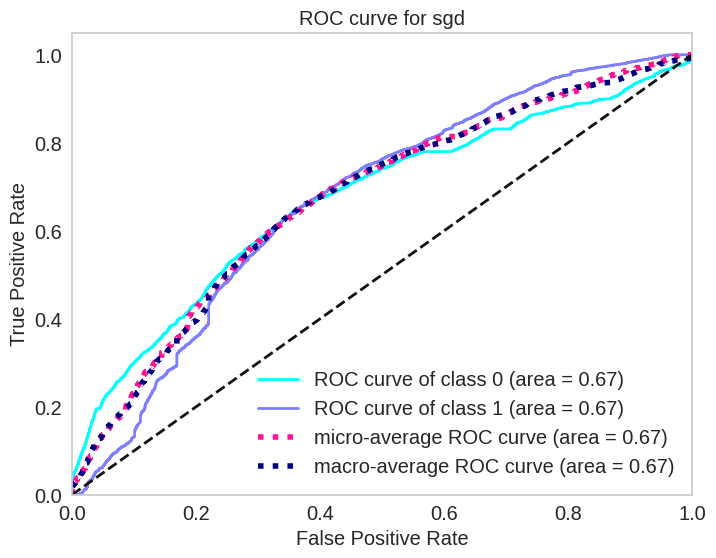

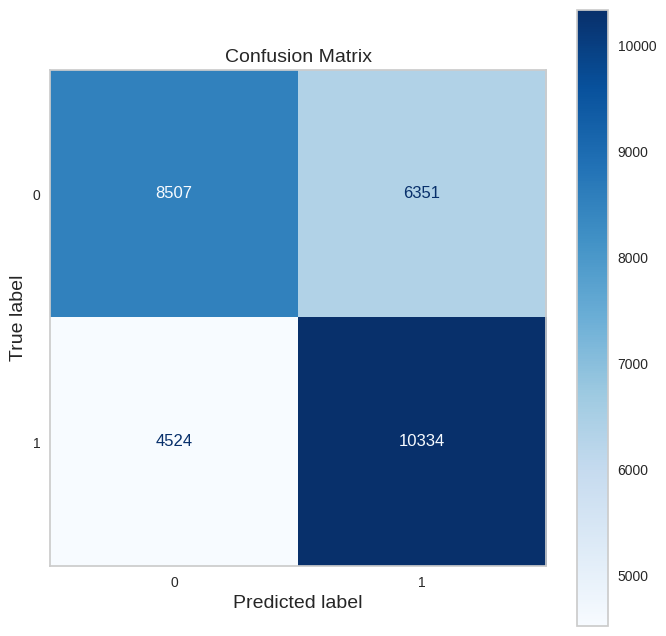



No feature importance for sgd






----------------------  logistic_regression  ----------------------


              precision    recall  f1-score   support

           0       0.67      0.58      0.62     14858
           1       0.63      0.71      0.67     14858

    accuracy                           0.65     29716
   macro avg       0.65      0.65      0.65     29716
weighted avg       0.65      0.65      0.65     29716



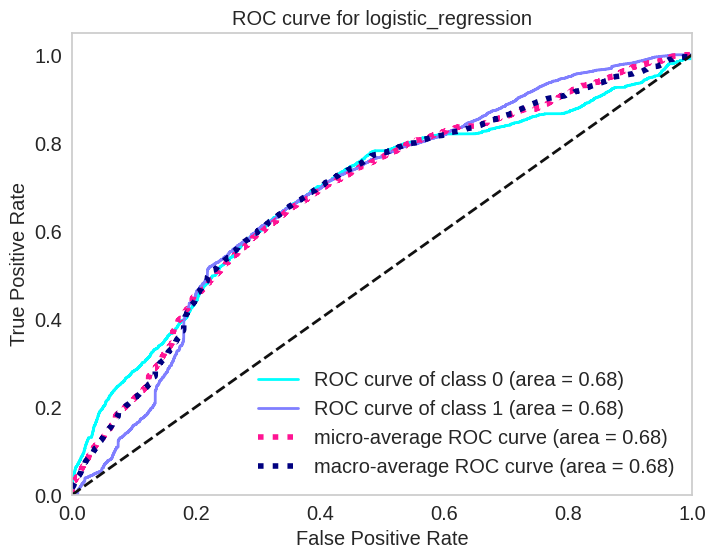

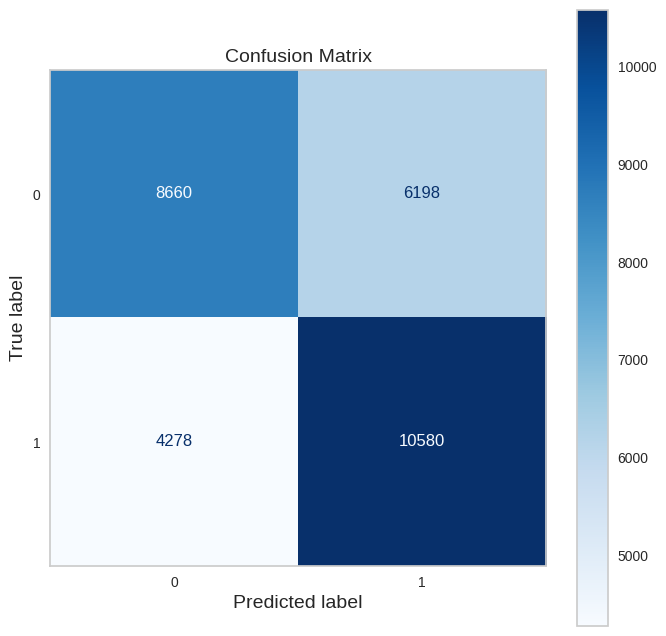

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/yellowbrick/model_selection/importances.py:194: YellowbrickWarning: detected multi-dimensional feature importances but stack=False, using mean to aggregate them.
  warnings.warn(


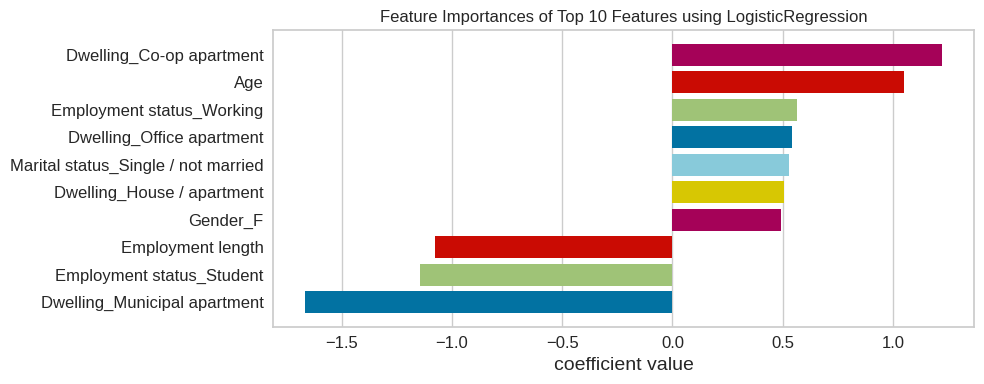

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/yellowbrick/model_selection/importances.py:194: YellowbrickWarning: detected multi-dimensional feature importances but stack=False, using mean to aggregate them.
  warnings.warn(


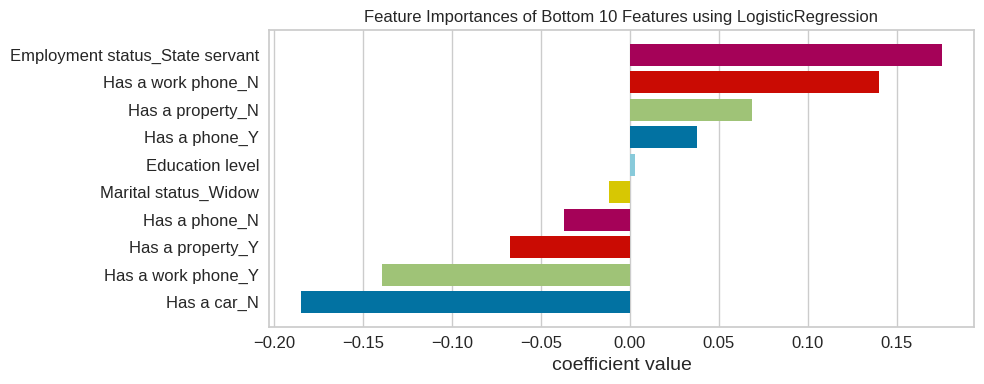







----------------------  decision_tree  ----------------------


              precision    recall  f1-score   support

           0       0.99      0.99      0.99     14858
           1       0.99      0.99      0.99     14858

    accuracy                           0.99     29716
   macro avg       0.99      0.99      0.99     29716
weighted avg       0.99      0.99      0.99     29716



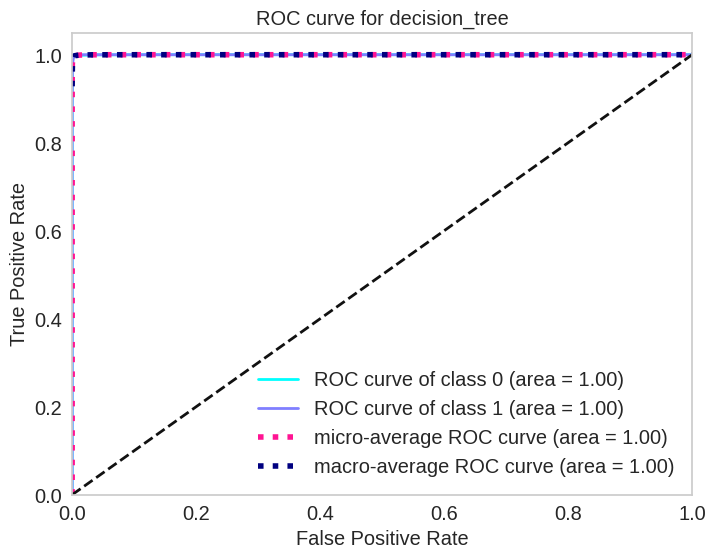

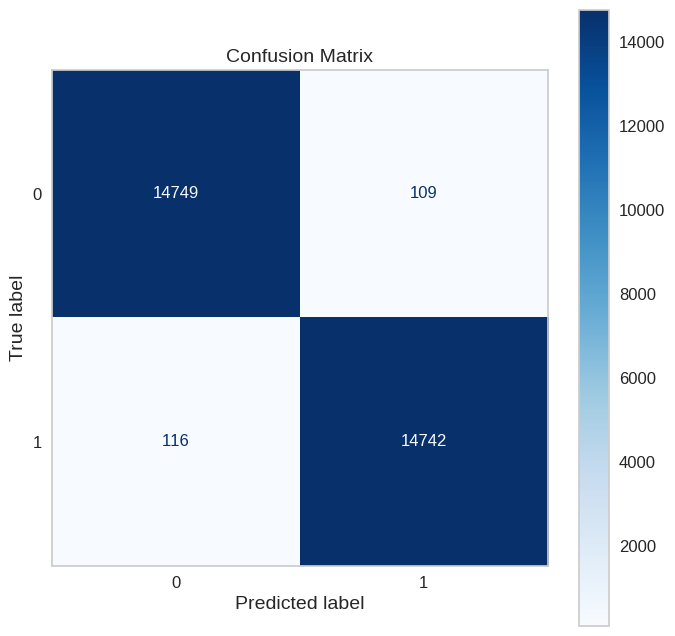

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


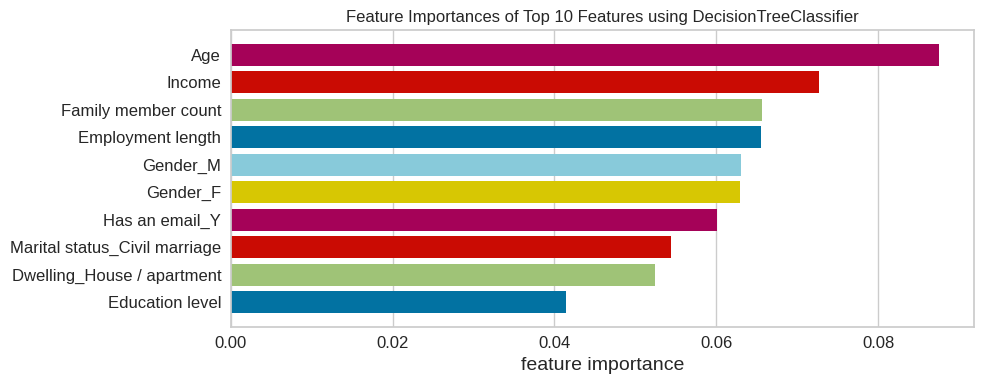

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


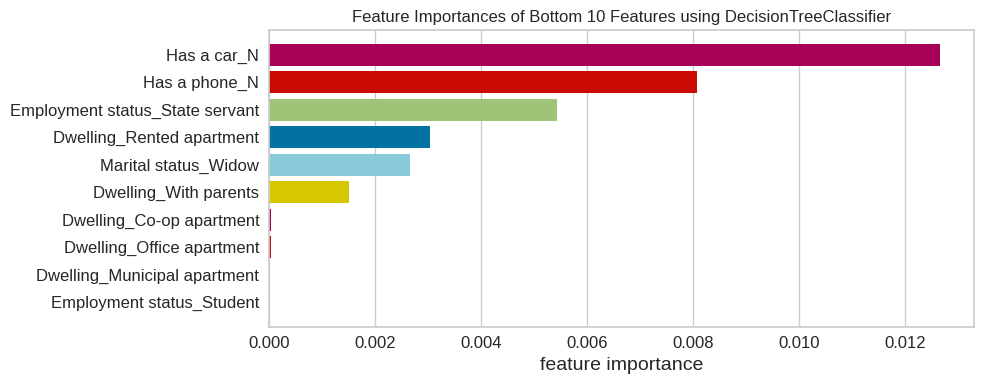







----------------------  random_forest  ----------------------


              precision    recall  f1-score   support

           0       0.99      1.00      1.00     14858
           1       1.00      0.99      1.00     14858

    accuracy                           1.00     29716
   macro avg       1.00      1.00      1.00     29716
weighted avg       1.00      1.00      1.00     29716



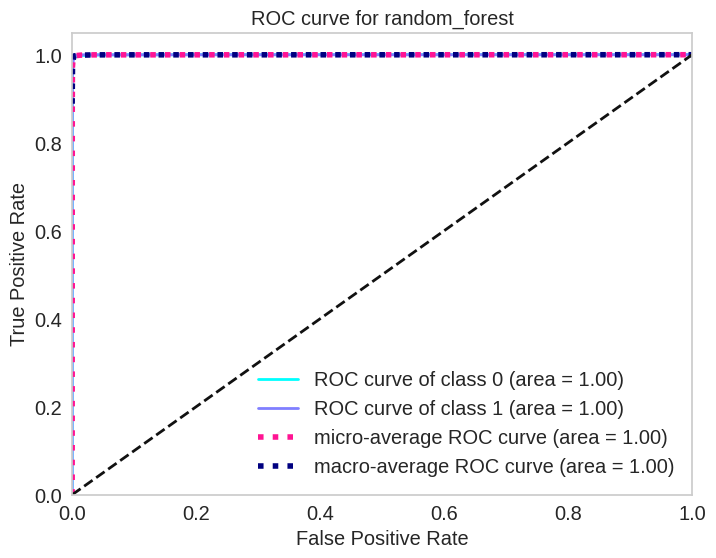

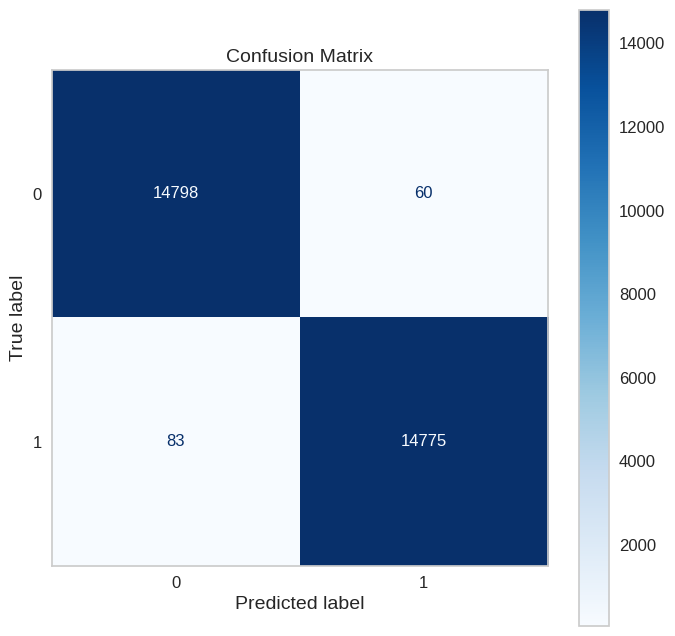

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


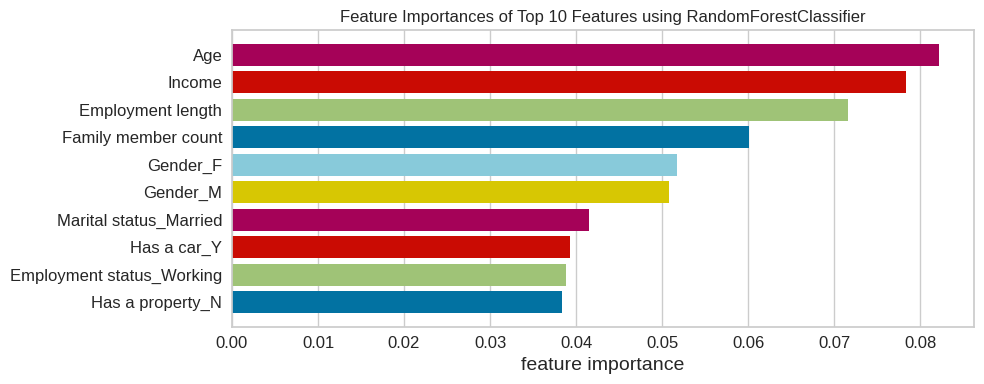

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


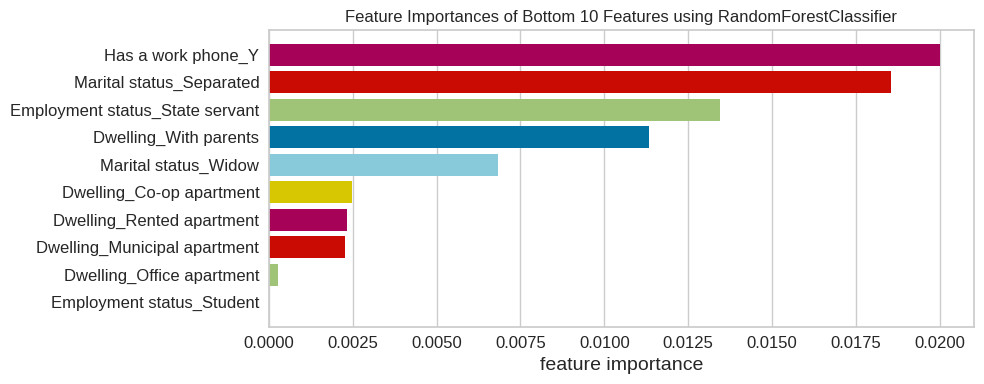







----------------------  gaussian_naive_bayes  ----------------------


              precision    recall  f1-score   support

           0       0.76      0.30      0.43     14858
           1       0.56      0.90      0.69     14858

    accuracy                           0.60     29716
   macro avg       0.66      0.60      0.56     29716
weighted avg       0.66      0.60      0.56     29716



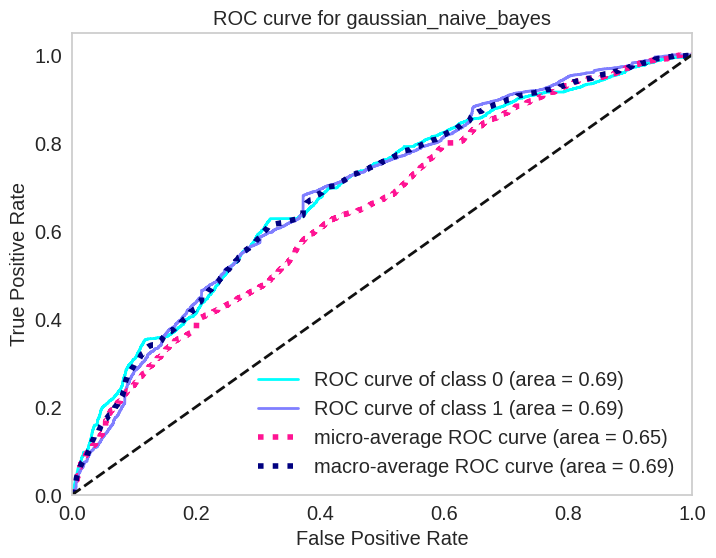

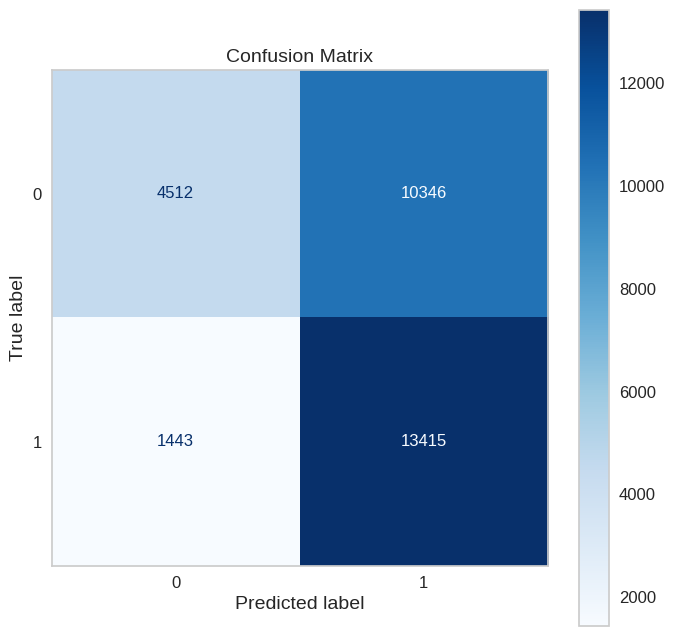



No feature importance for gaussian_naive_bayes






----------------------  k_nearest_neighbors  ----------------------


              precision    recall  f1-score   support

           0       0.94      0.98      0.96     14858
           1       0.98      0.94      0.96     14858

    accuracy                           0.96     29716
   macro avg       0.96      0.96      0.96     29716
weighted avg       0.96      0.96      0.96     29716



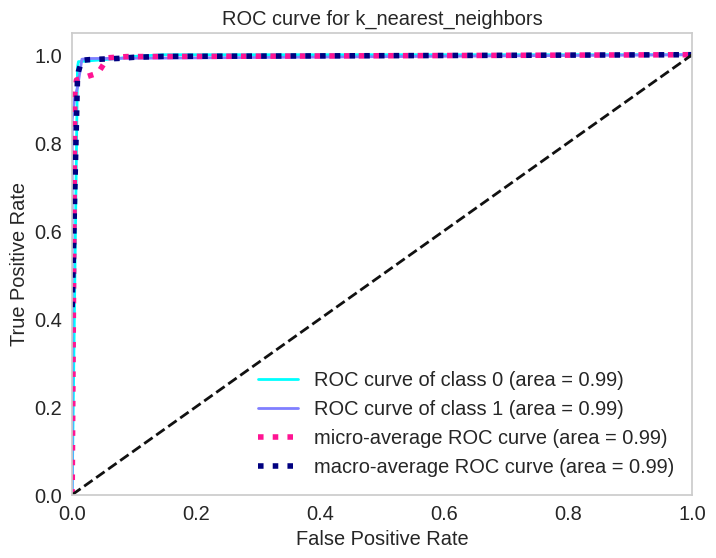

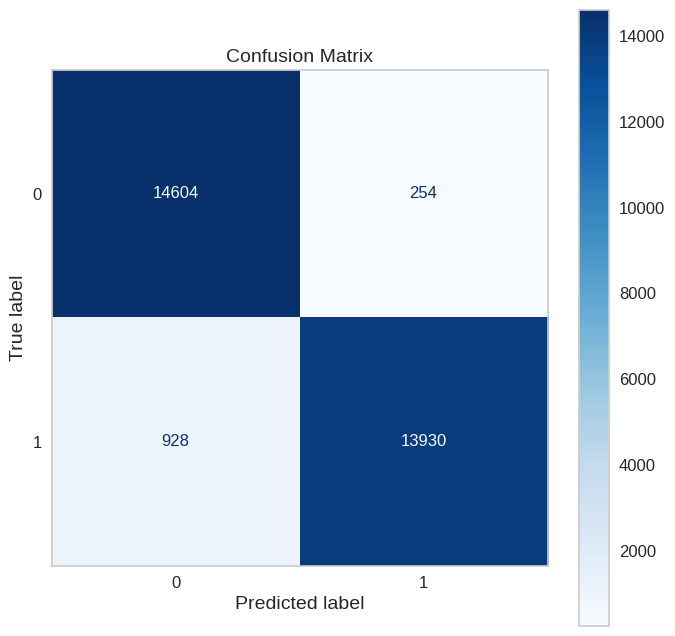



No feature importance for k_nearest_neighbors






----------------------  gradient_boosting  ----------------------


              precision    recall  f1-score   support

           0       0.97      0.96      0.97     14858
           1       0.96      0.97      0.97     14858

    accuracy                           0.97     29716
   macro avg       0.97      0.97      0.97     29716
weighted avg       0.97      0.97      0.97     29716



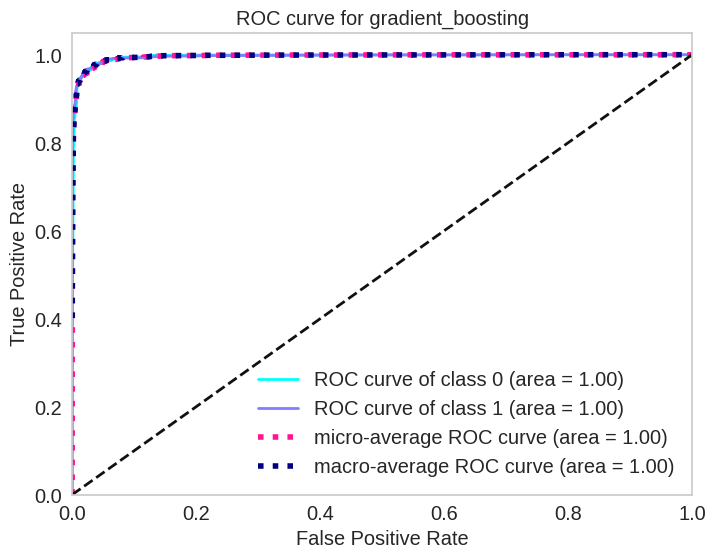

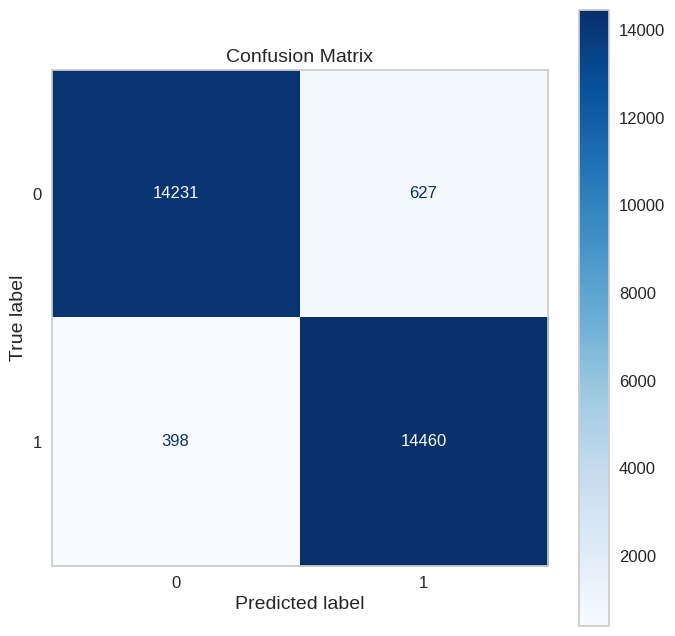

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


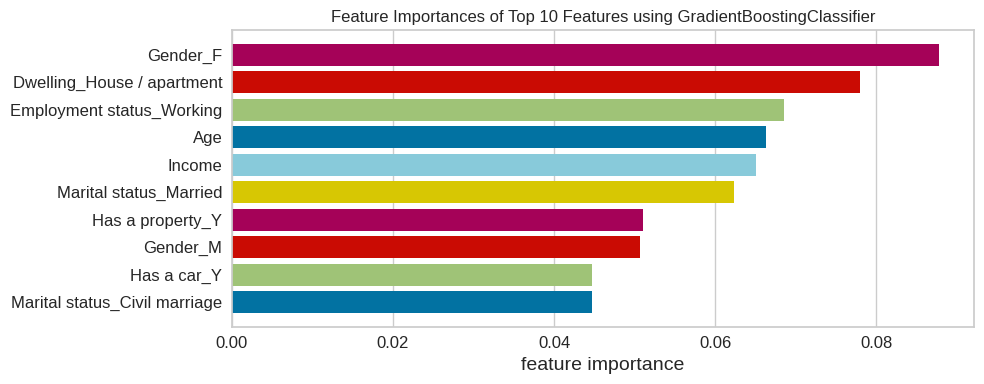

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


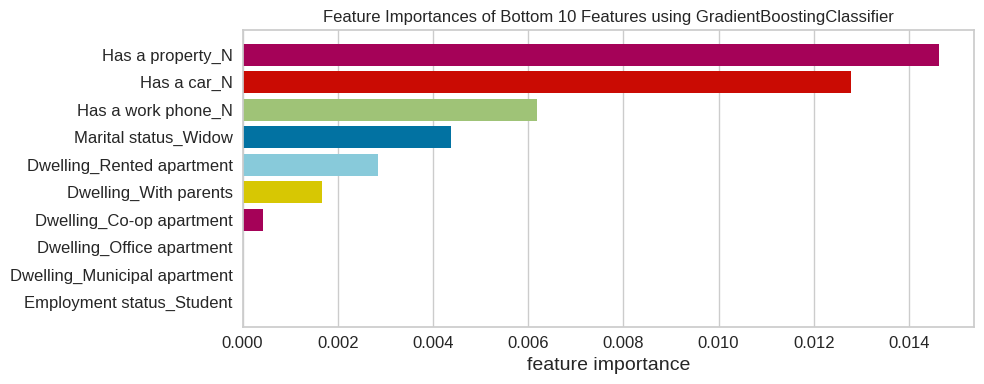







----------------------  linear_discriminant_analysis  ----------------------


              precision    recall  f1-score   support

           0       0.67      0.58      0.62     14858
           1       0.63      0.72      0.67     14858

    accuracy                           0.65     29716
   macro avg       0.65      0.65      0.65     29716
weighted avg       0.65      0.65      0.65     29716



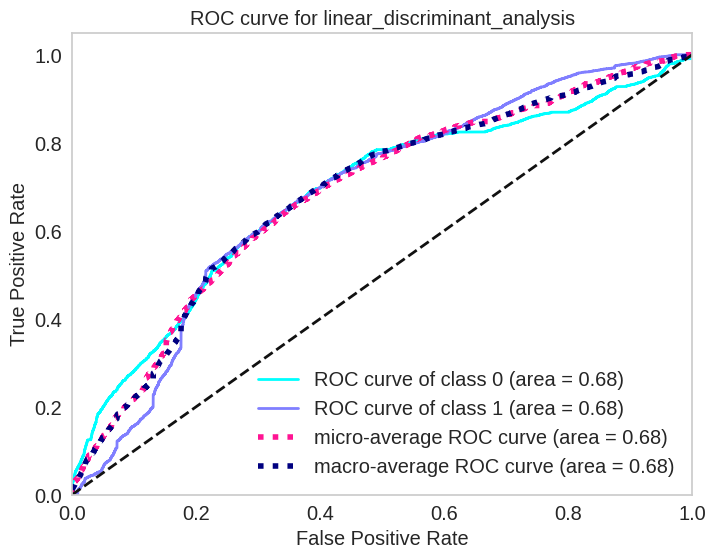

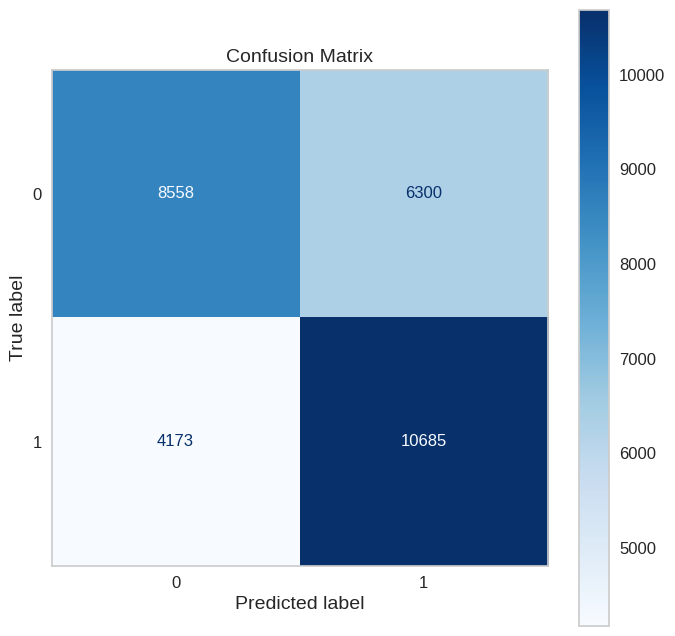

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearDiscriminantAnalysis was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/yellowbrick/model_selection/importances.py:194: YellowbrickWarning: detected multi-dimensional feature importances but stack=False, using mean to aggregate them.
  warnings.warn(


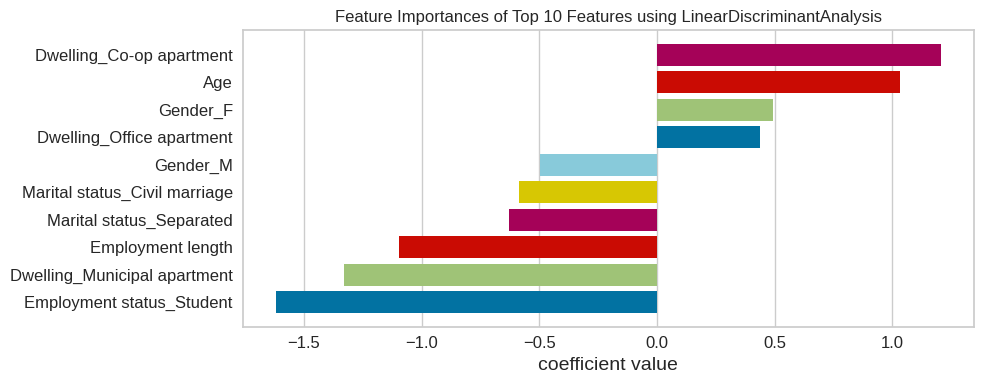

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearDiscriminantAnalysis was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/yellowbrick/model_selection/importances.py:194: YellowbrickWarning: detected multi-dimensional feature importances but stack=False, using mean to aggregate them.
  warnings.warn(


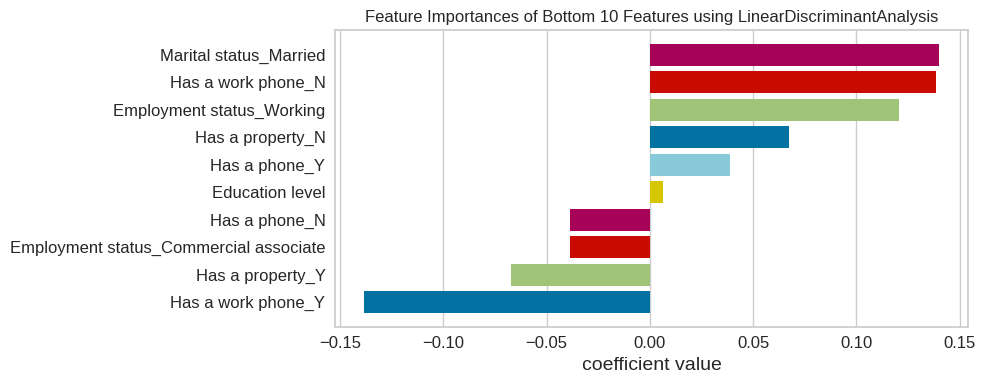







----------------------  bagging  ----------------------


              precision    recall  f1-score   support

           0       0.99      0.99      0.99     14858
           1       0.99      0.99      0.99     14858

    accuracy                           0.99     29716
   macro avg       0.99      0.99      0.99     29716
weighted avg       0.99      0.99      0.99     29716



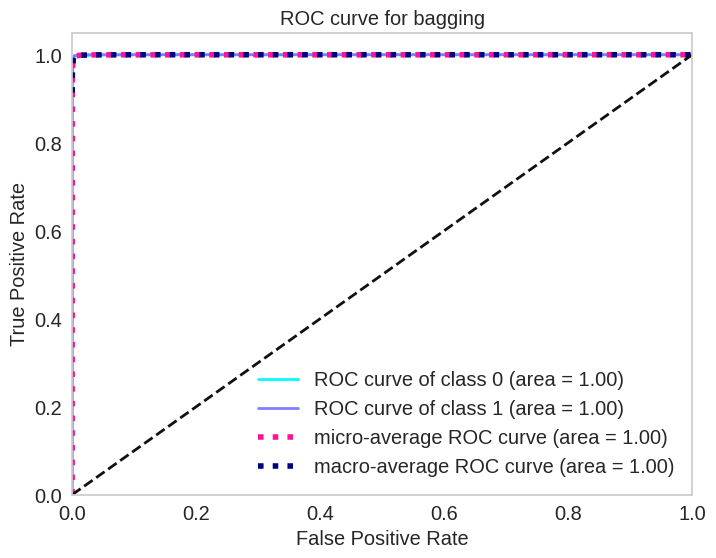

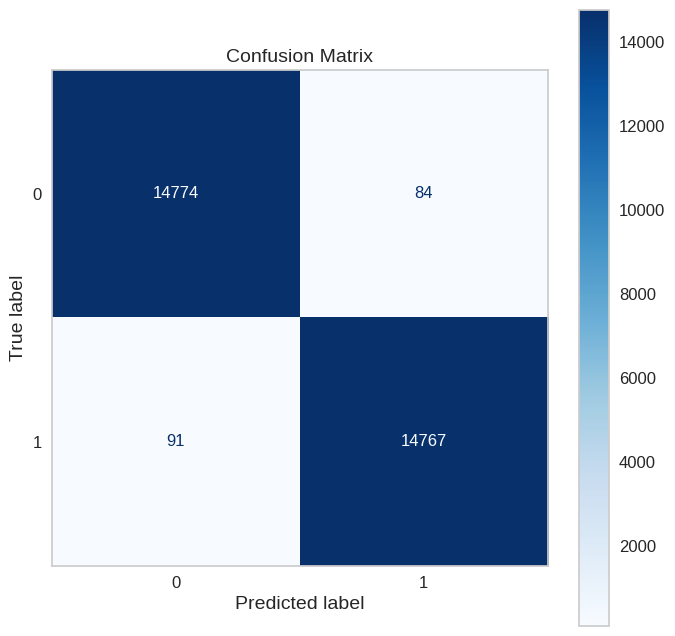



No feature importance for bagging






----------------------  neural_network  ----------------------


              precision    recall  f1-score   support

           0       1.00      0.97      0.99     14858
           1       0.97      1.00      0.99     14858

    accuracy                           0.99     29716
   macro avg       0.99      0.99      0.99     29716
weighted avg       0.99      0.99      0.99     29716



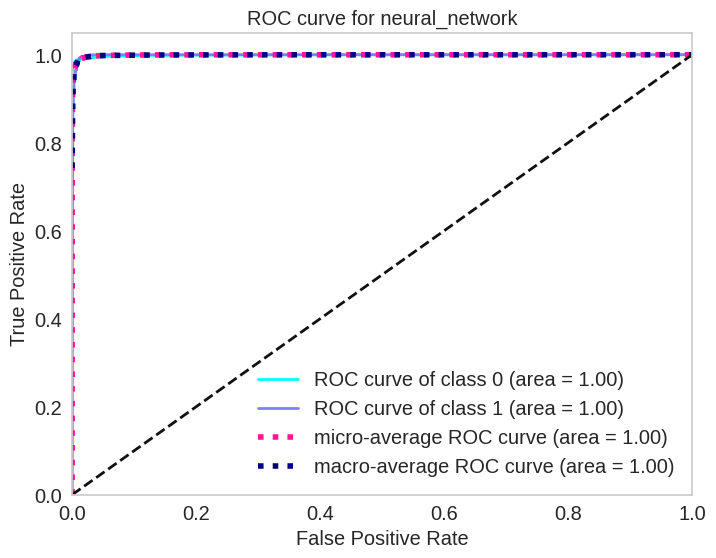

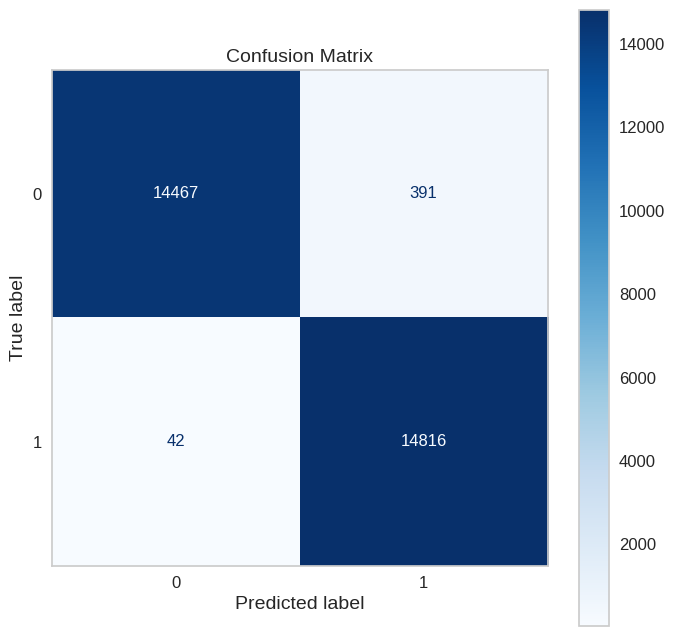



No feature importance for neural_network






----------------------  adaboost  ----------------------


              precision    recall  f1-score   support

           0       0.87      0.87      0.87     14858
           1       0.87      0.87      0.87     14858

    accuracy                           0.87     29716
   macro avg       0.87      0.87      0.87     29716
weighted avg       0.87      0.87      0.87     29716



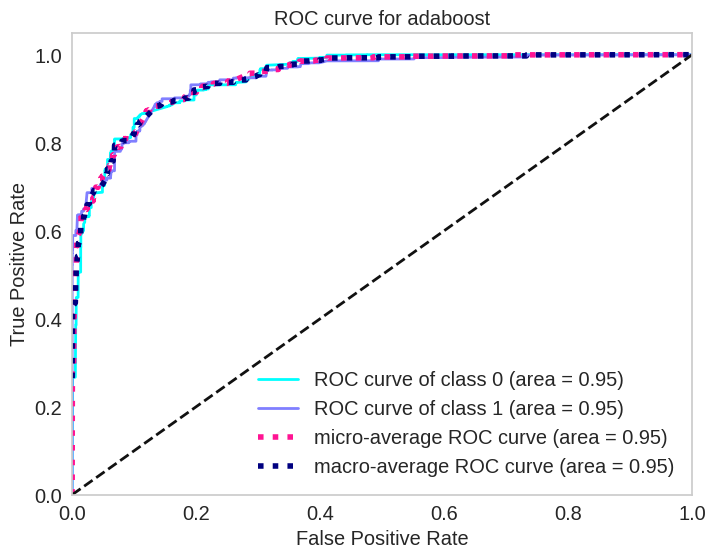

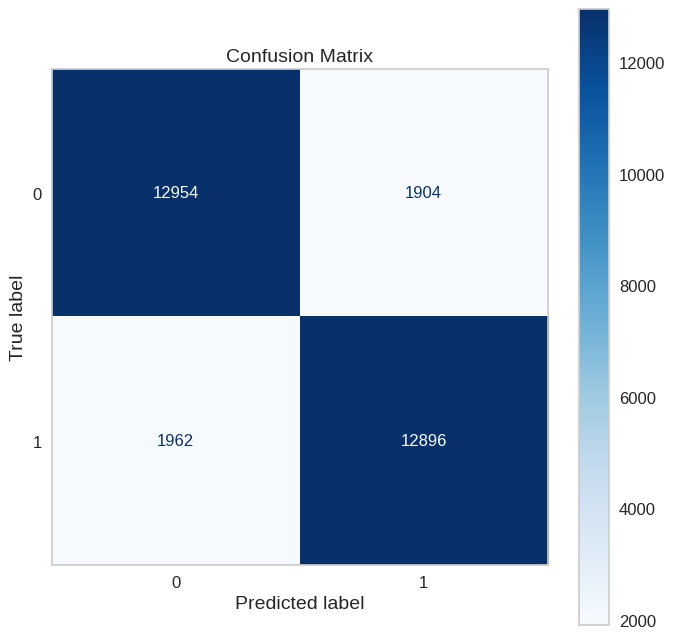

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


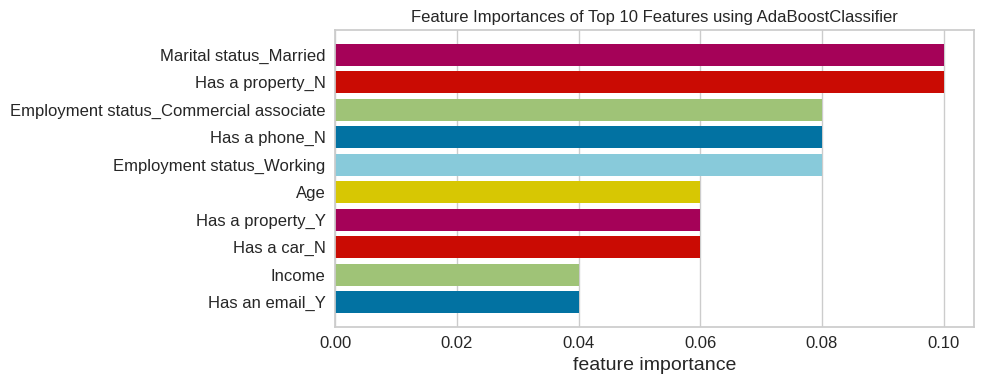

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


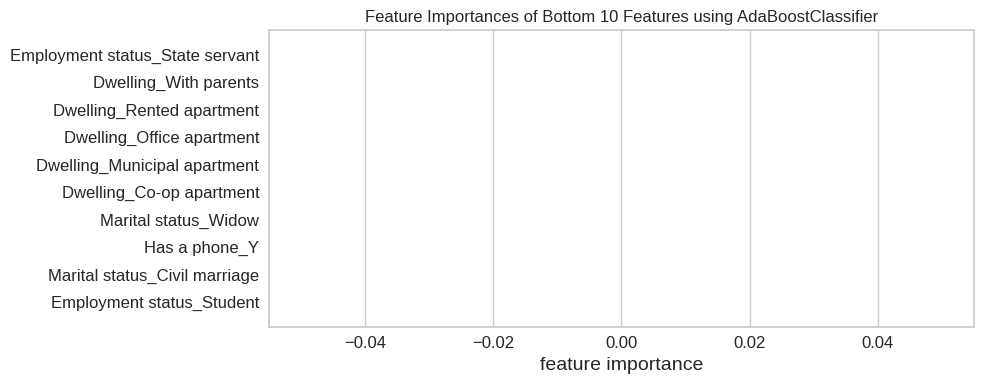







----------------------  extra_trees  ----------------------


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14858
           1       1.00      1.00      1.00     14858

    accuracy                           1.00     29716
   macro avg       1.00      1.00      1.00     29716
weighted avg       1.00      1.00      1.00     29716



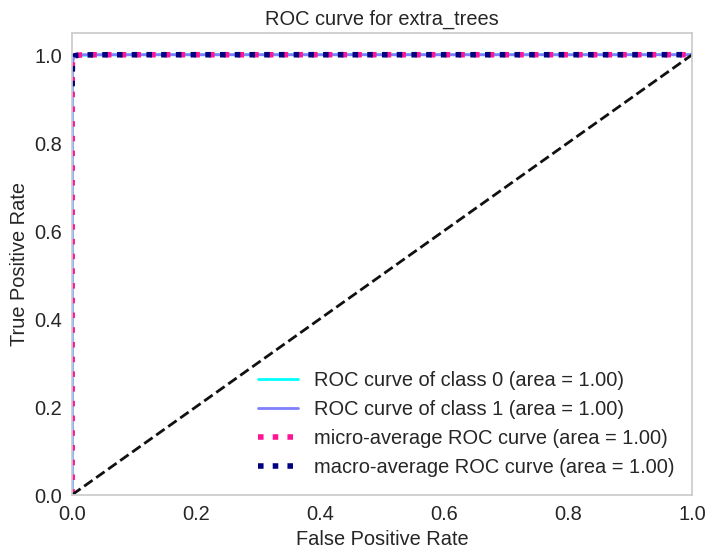

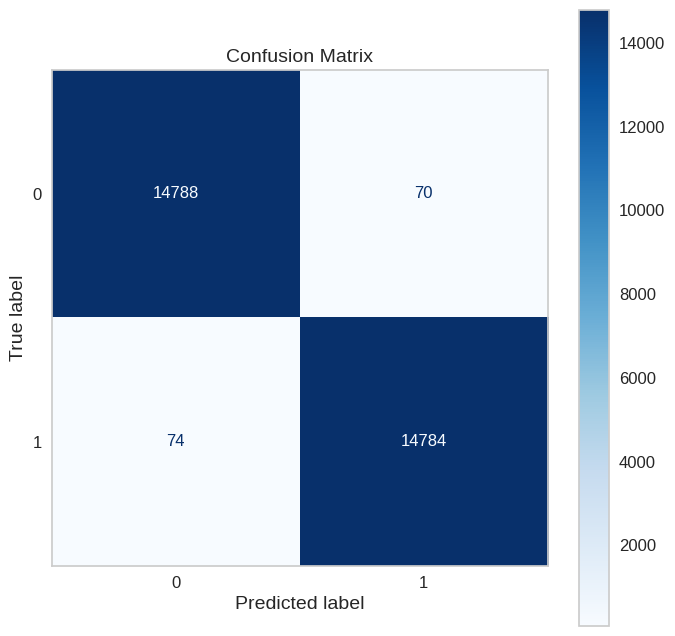

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(


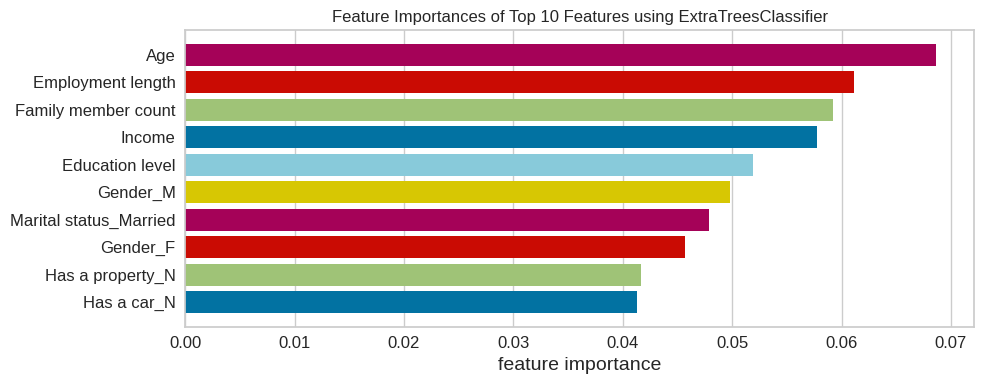

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(


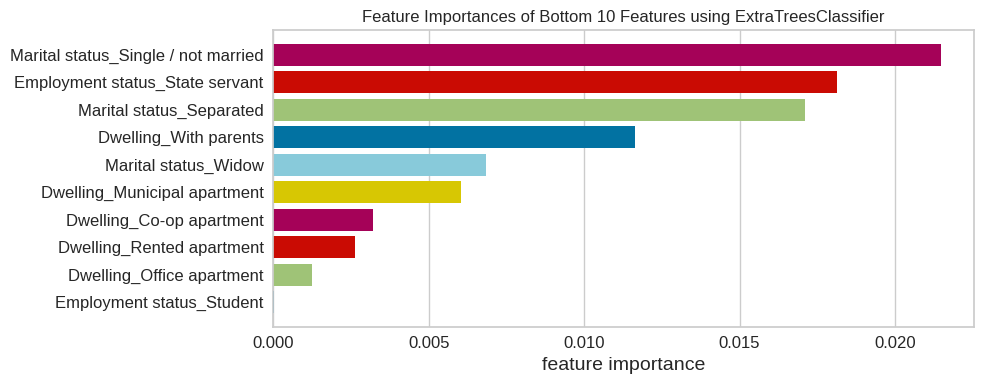

In [137]:
for model_name,model in classifiers.items():
    # title formatting
    print('\n')
    print('\n')
    print('  {}  '.center(50,'-').format(model_name))
    print('\n')
    # check if the folder for saving the model exists, if not create it
    folder_check_model()
    # train the model
    model_trn = train_model(model,model_name)
    score_func(model_trn, model_name)
    # plot the ROC curve
    roc_curve_func(model_trn,model_name)
    # plot the confusion matrix
    confusion_matrix_func(model_trn,model_name)
    # plot feature importance
    feat_importance_plot(model_trn, model_name)

## 4.2 What metrics to use for this problem?

Since the objective of this problem is to minimize the risk of credit default for the financial institution, the metrics to use depends on the current economical situation:

- During the time of a bull market (when the economy is expending), people feel wealthy and usually are employed. Money is usually cheap and the risk of default is low. The financial institution is able to handle the risk of default therefore is not very strict on giving out credit. The financial institution can handle a number of bad clients as long as the vast majority of applicants are good clients (aka those who payback their credit).In this case, having a good recall (sensitivity) is ideal.
- During a bear market (when the economy is contracting), people loose their jobs and their money through the stock market. Many people struggle to meet their financial obligations. The financial institution therefore tend to be more conservative on giving out credit or loans. The financial institution can't afford to give out credit to clients who won't be able to pay back their credit. The financial institution would rather have a smaller number of good clients even if it means that some good clients where denied credit, and ideally not have any bad client. In this case, having a good precision (specificity) is desirable.

Note: There is always a trade-off between precision and recall. Choosing the right metrics depends on the problem you are solving.

Conclusion: In our case, since we are in the longest bull market (not including the March 2020 flash crash), we will use recall as our metric.

## 4.3 Top model

Using the ROC curve and recall, we can that conclude that our top model is:
- Gradient boosting classifier

# 5. Test the final model on the test set

In [138]:
cc_test_copy.head(5)

ID Gender Has a car Has a property  Children count    Income  \
0  5089466      F         N              N               2  67500.00   
1  5061678      M         N              N               0 270000.00   
2  5010990      F         N              Y               0  90000.00   
3  5022689      F         N              Y               0 112500.00   
4  5091592      F         N              Y               0 252000.00   

      Employment status                Education level        Marital status  \
0               Working  Secondary / secondary special               Married   
1               Working  Secondary / secondary special               Married   
2               Working  Secondary / secondary special               Married   
3  Commercial associate  Secondary / secondary special  Single / not married   
4         State servant  Secondary / secondary special               Married   

              Dwelling    Age  Employment length  Has a mobile phone  \
0  Municipal apartment -13891            -248.00                1.00   
1    House / apartment -11822           -4246.00                1.00   
2    House / apartment -20074            -221.00                1.00   
3    House / apartment -15903            -762.00                1.00   
4    House / apartment -18352            -139.00                1.00   

   Has a work phone  Has a phone  Has an email       Job title  \
0              1.00         1.00          0.00      Core staff   
1              0.00         0.00          0.00             NaN   
2              0.00         0.00          0.00  Medicine staff   
3              0.00         0.00          0.00     Sales staff   
4              1.00         1.00          0.00  Medicine staff   

   Family member count  Account age Is high risk  
0                 4.00       -52.00            0  
1                 2.00       -56.00            0  
2                 2.00       -32.00            0  
3                 1.00       -20.00            0  
4                 2.00       -28.00            0

In [139]:
cc_test_prep = full_pipeline(cc_test_copy)

In [140]:
# split the train data into X and y (target)
X_cc_test_prep, y_cc_test_prep = cc_test_prep.loc[:, cc_test_prep.columns != 'Is high risk'], cc_test_prep['Is high risk'].astype('int64')

In [141]:
# train the model
model_trn = train_model(classifiers['gradient_boosting'],'gradient_boosting')

In [142]:
final_predictions = model_trn.predict(X_cc_test_prep)

In [143]:
final_predictions.shape

(7580,)

In [144]:
n_correct = sum(final_predictions == y_cc_test_prep)

In [145]:
print(n_correct/len(final_predictions))

0.9372031662269129
